# Finetuning the last year of fine-rune model

In [1]:
import os
ml_code_path='/home/leilapirhaji/mz_embed_engine/ml'
os.chdir(ml_code_path)

import pandas as pd
import importlib
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import optuna
import imaplib


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score


#importing fundtion to get encoder info and perfrom tasks 
from finetune.get_finetune_encoder import  get_finetune_input_data

from models.models_VAE import VAE

%who



[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
2024-09-13 22:52:49.537471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 22:52:49.769292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 22:52:49.841495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 22:52:50.317908: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions

DataLoader	 LabelEncoder	 TensorDataset	 VAE	 accuracy_score	 f1_score	 get_finetune_input_data	 imaplib	 importlib	 
label_encoder	 ml_code_path	 nn	 np	 optim	 optuna	 os	 pd	 precision_score	 
random	 recall_score	 roc_auc_score	 torch	 


## gettin the model ID and info

#### getting the input data

In [2]:
#input data
input_data_location='/home/leilapirhaji/PROCESSED_DATA_2'
finetune_save_dir='/home/leilapirhaji/finetune_VAE_models' 

#tasks to predict using encoder
task_list_cat=['Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'ORR', 'Benefit', 'IMDC', 'MSKCC', 'Prior_2' ]

#survival tasks
task_list_survival=[ 'OS', 'NIVO OS', 'EVER OS', 'PFS']


#get fine-tuning input data 
(X_data_train, y_data_train, X_data_val, y_data_val, X_data_test, y_data_test)=get_finetune_input_data(input_data_location)

X_data_train.shape, y_data_train.shape, X_data_val.shape, y_data_val.shape, X_data_test.shape, y_data_test.shape

((443, 2736), (443, 58), (149, 2736), (149, 58), (149, 2736), (149, 58))

### loading the fine-tune VAE models w/wo transfer leanrning

In [3]:
#first getting A list of pretrained models and their associated fine-tune 
#pretrain_model_list=os.listdir(finetune_save_dir)
pretrain_model_list=['RCC-37603', 'RCC-37600']

In [4]:
pretrain_model_ID=pretrain_model_list[0]
#path to pre-train and fine-tune models
models_path=f'{finetune_save_dir}/{pretrain_model_ID}'

#pretrain encoder file
pretrain_encoder_file= f'{models_path}/{pretrain_model_ID}_encoder_state_dict.pth'

#finetune models files
finetune_VAE_TL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_True_model.pth'
finetune_VAE_TL=torch.load(finetune_VAE_TL_file)

finetune_VAE_noTL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_False_model.pth'
finetune_VAE_noTL=torch.load(finetune_VAE_noTL_file)

/var/tmp/ipykernel_435196/4275380214.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_VAE_TL=torch.load(finetune_VAE_TL_file)
/var/tmp/ipykernel_435196/42753802

In [5]:
finetune_VAE_TL.latent_size, finetune_VAE_TL.num_hidden_layers, finetune_VAE_noTL.latent_size, finetune_VAE_noTL.num_hidden_layers

(400, 2, 400, 2)

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (f'Device: {device}')

Device: cuda


In [7]:
import finetune.eval_finetune_latent_main

importlib.reload(finetune.eval_finetune_latent_main)
from finetune.eval_finetune_latent_main import compute_losses, predict_task_from_latent_avg, predict_survival_from_latent_avg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


pretrain_model_list=['RCC-37603', 'RCC-37600']
all_results = []


for pretrain_model_ID in pretrain_model_list:
    
    #loading the VAE modesl developed with and without transfer leanring
    print (f'Predicting tasks using the latnet space of the VAE models with pre-train model ID: {pretrain_model_ID}') 

    #path to pre-train and fine-tune models
    models_path=f'{finetune_save_dir}/{pretrain_model_ID}'

    #finetune models files
    finetune_VAE_TL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_True_model.pth'
    finetune_VAE_TL=torch.load(finetune_VAE_TL_file)

    finetune_VAE_noTL_file= f'{models_path}/Finetune_VAE_pretain_{pretrain_model_ID}_TL_False_model.pth'
    finetune_VAE_noTL=torch.load(finetune_VAE_noTL_file)


    latent_size= finetune_VAE_TL.latent_size
    num_hidden_layers= finetune_VAE_TL.num_hidden_layers

    #getting the recon loss of the models
    # Example usage
    # Assuming model is your trained VAE model
    losses_TL = compute_losses(finetune_VAE_TL, X_data_train, X_data_val, X_data_test, device)
    losses_noTL = compute_losses(finetune_VAE_TL, X_data_train, X_data_val, X_data_test, device)


    for task in task_list_cat:
        print (f'Predicting task: {task}')
        # predicting tasks using the latnet space of the VAE models with transfer learning 
        best_val_accuracy_TL, best_val_auc_TL, test_accuracy_TL, test_auc_TL= predict_task_from_latent_avg (finetune_VAE_TL, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

        # predicting tasks using the latnet space of the VAE models without transfer learning
        best_val_accuracy_noTL, best_val_auc_noTL, test_accuracy_noTL, test_auc_noTL= predict_task_from_latent_avg (finetune_VAE_noTL, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)


        # Append the results to the list
        result_dict = {
            'Pretrain Model ID': pretrain_model_ID,
            'Latent Size': latent_size,
            'Num Hidden Layers': num_hidden_layers,
            'Validation Recon Loss TL': np.log(losses_TL['val_recon_loss']),
            'Validation KL Loss TL': np.log(losses_TL['val_kl_loss']),
            'Test Recon Loss TL':np.log(losses_TL['test_recon_loss']),
            'Test KL Loss TL': np.log(losses_TL['test_kl_loss']),
            'Validation Recon Loss NO TL': np.log(losses_noTL['val_recon_loss']),
            'Validation KL Loss NO TL': np.log(losses_noTL['val_kl_loss']),
            'Test Recon Loss NO TL':np.log(losses_noTL['test_recon_loss']),
            'Test KL Loss NO TL':np.log(losses_noTL['test_kl_loss']),
            'Task': task,
            'Type': 'Classification',
            'Best Val Accuracy TL': best_val_accuracy_TL,
            'Best Val AUC TL': best_val_auc_TL,
            'Test Accuracy TL': test_accuracy_TL,
            'Test AUC TL': test_auc_TL,
            'Best Val Accuracy NO TL': best_val_accuracy_noTL,
            'Best Val AUC NO TL': best_val_auc_noTL,
            'Test Accuracy NO TL': test_accuracy_noTL,
            'Test AUC NO TL': test_auc_noTL
        }
        all_results.append(result_dict)


    # predicting survival tasks using the latnet space of the VAE models
    for task in task_list_survival:
        print (f'Predicting survival task: {task}')

        if task=='OS' or task=='NIVO OS' or task=='EVER OS':
            task_event= 'OS_Event'
        elif task=='PFS':
            task_event= 'PFS_Event'
        else:
            task_event= None

        # predicting survival tasks using the latnet space of the VAE models with transfer learning 
        best_val_c_index_TL, best_test_c_index_TL, best_params_TL= predict_survival_from_latent_avg (finetune_VAE_TL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

        # predicting survival tasks using the latnet space of the VAE models without transfer learning
        best_val_c_index_noTL, best_test_c_index_noTL, best_params_noTL= predict_survival_from_latent_avg (finetune_VAE_noTL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)


        # Append the results to the list
        result_dict = {
            'Pretrain Model ID': pretrain_model_ID,
            'Latent Size': latent_size,
            'Num Hidden Layers': num_hidden_layers,
            'Validation Recon Loss TL': np.log(losses_TL['val_recon_loss']),
            'Validation KL Loss TL': np.log(losses_TL['val_kl_loss']),
            'Test Recon Loss TL':np.log(losses_TL['test_recon_loss']),
            'Test KL Loss TL': np.log(losses_TL['test_kl_loss']),
            'Validation Recon Loss NO TL': np.log(losses_noTL['val_recon_loss']),
            'Validation KL Loss NO TL': np.log(losses_noTL['val_kl_loss']),
            'Test Recon Loss NO TL':np.log(losses_noTL['test_recon_loss']),
            'Test KL Loss NO TL':np.log(losses_noTL['test_kl_loss']),
            'Task': task,
            'Type': 'Survival',
            'Best Val C-Index TL': best_val_c_index_TL,
            'Best Test C-Index TL': best_test_c_index_TL,
            'Best Val C-Index NO TL': best_val_c_index_noTL,
            'Best Test C-Index NO TL': best_test_c_index_noTL,
        }
        all_results.append(result_dict)
    



Predicting tasks using the latnet space of the VAE models with pre-train model ID: RCC-37603


/var/tmp/ipykernel_435196/1531597276.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetune_VAE_TL=torch.load(finetune_VAE_TL_file)
/var/tmp/ipykernel_435196/15315972

Predicting task: Benefit BINARY
Test Accuracy with best model: 0.5455
Test AUC with best model: 0.5657
Test Accuracy with best model: 0.4773
Test AUC with best model: 0.4752
Predicting task: Nivo Benefit BINARY
Test Accuracy with best model: 0.6863
Test AUC with best model: 0.7015
Test Accuracy with best model: 0.5490
Test AUC with best model: 0.5569
Predicting task: MSKCC BINARY
Test Accuracy with best model: 0.7976
Test AUC with best model: 0.8521
Test Accuracy with best model: 0.8214
Test AUC with best model: 0.8831
Predicting task: IMDC BINARY
Test Accuracy with best model: 0.7719
Test AUC with best model: 0.8721
Test Accuracy with best model: 0.7719
Test AUC with best model: 0.8261
Predicting task: Benefit ORDINAL
Test Accuracy with best model: 0.4295
Test AUC with best model: 0.5595
Test Accuracy with best model: 0.3960
Test AUC with best model: 0.4621
Predicting task: MSKCC ORDINAL
Test Accuracy with best model: 0.5839
Test AUC with best model: 0.7362
Test Accuracy with best mod

/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)


AttributeError: 'float' object has no attribute 'get'

In [ ]:
all_results

## Perdciting tasks from latnet space

In [39]:
#tasks to predict using encoder
task_list_cat=['Benefit BINARY', 'Nivo Benefit BINARY', 'MSKCC BINARY', 'IMDC BINARY', 'Benefit ORDINAL', 'MSKCC ORDINAL', 'IMDC ORDINAL', 'ORR', 'Benefit', 'IMDC', 'MSKCC', 'Prior_2' ]

task= 'IMDC BINARY'


import finetune.eval_finetune_latent_main

importlib.reload(finetune.eval_finetune_latent_main)
from finetune.eval_finetune_latent_main import predict_task_from_latent_avg



best_val_accuracy, best_val_auc, test_accuracy, test_auc= predict_task_from_latent_avg (finetune_VAE_TL, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_accuracy, best_val_auc, test_accuracy, test_auc

Test Accuracy with best model: 0.8772
Test AUC with best model: 0.9476


(0.8524590163934426,
 0.8904428904428904,
 0.8771929824561403,
 0.9475703324808185)

In [41]:
best_val_accuracy, best_val_auc, test_accuracy, test_auc= predict_task_from_latent_avg (finetune_VAE_noTL, task, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_accuracy, test_accuracy

Test Accuracy with best model: 0.8070
Test AUC with best model: 0.8862


(0.8688524590163934, 0.8070175438596491)

## Predicting Survival from latnent avergae

### OS prediction

In [50]:
import finetune.latent_task_predict_main
importlib.reload(finetune.latent_task_predict_main)
from finetune.latent_task_predict_main import predict_survival_from_latent_avg


task= 'OS'
task_event='OS_Event'

best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_TL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)


(0.6944472642371333, 0.6613498155717277, 0.1)

In [51]:
best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_noTL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)


(0.7064257435793321, 0.6192802312830227, 0.001)

### PFS Predictions

In [52]:
task= 'PFS'
task_event='PFS_Event'

best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_TL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)


(0.5581518291393529, 0.5083023814725803, 0.1)

In [53]:
task= 'PFS'
task_event='PFS_Event'

best_val_c_index, best_test_c_index, best_params= predict_survival_from_latent_avg (finetune_VAE_noTL, task, task_event, X_data_train, y_data_train, X_data_val, y_data_val, X_data_test,y_data_test, batch_size=64, num_times=10)

best_val_c_index, best_test_c_index, best_params

/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)
/home/leilapirhaji/mz_embed_engine/ml/finetune/latent_task_predict.py:268: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_train_clean, Y_train)


(0.5698879255656587, 0.48918505571334936, 0.001)

## VAE model with fine-tuned last layer

In [5]:
#loading the seed file
with open('/home/leilapirhaji/mz_embed_engine/ml/seed_Aug31.txt', 'r') as f:
    seed = int(f.read())

In [6]:
y_data_val['MSKCC ORDINAL'].describe()

count    149.000000
mean       1.174497
std        0.723463
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: MSKCC ORDINAL, dtype: float64

In [115]:
hidden_layers = encoder_layers[:-1]
hidden_layers

[Linear(in_features=2736, out_features=981, bias=True),
 Linear(in_features=981, out_features=352, bias=True)]

In [126]:
encoder_layers = [layer for layer in finetune_VAE_TL.encoder.network.children() if isinstance(layer, nn.Linear)]
encoder_layers



[Linear(in_features=2736, out_features=981, bias=True),
 Linear(in_features=981, out_features=352, bias=True),
 Linear(in_features=352, out_features=352, bias=True)]

In [130]:
import imaplib
import freez_encoder_latent_avg
importlib.reload(freez_encoder_latent_avg)
from freez_encoder_latent_avg import fine_tune_model

task='IMDC BINARY'
num_classes = 2

model, metrics = fine_tune_model(
    VAE_model=finetune_VAE_TL,  # VAE model with transfer learning 
    X_train=X_data_train, 
    y_data_train=y_data_train[task],
    X_val=X_data_val, 
    y_data_val=y_data_val[task], 
    num_classes=num_classes, 
    num_layers_to_retrain=3, 
    add_post_latent_layers=False, 
    num_post_latent_layers=1, 
    post_latent_layer_size=32, 
    num_epochs=20, 
    batch_size=32, 
    learning_rate=1e-5, 
    dropout=0.25, 
    l1_reg_weight=1e-7, 
    l2_reg_weight=1e-7, 
    latent_passes=10, 
    seed=seed # Set seed for reproducibility
    )

model



Total hidden layers (excluding latent): 3
Number of layers to retrain: 3
network.0.weight: requires_grad = False
network.0.bias: requires_grad = False
network.3.weight: requires_grad = False
network.3.bias: requires_grad = False
network.6.weight: requires_grad = False
network.6.bias: requires_grad = False

After unfreezing:
network.0.weight: requires_grad = True
network.0.bias: requires_grad = True
network.3.weight: requires_grad = True
network.3.bias: requires_grad = True
network.6.weight: requires_grad = True
network.6.bias: requires_grad = True
Epoch 1/20, Loss: 0.00010329243325811279
Epoch 2/20, Loss: 0.00010417186214389014
Epoch 3/20, Loss: 0.00010063631011040084
Epoch 4/20, Loss: 0.0001008155673584302
Epoch 5/20, Loss: 9.951359762843432e-05
Epoch 6/20, Loss: 9.932893902129893e-05
Epoch 7/20, Loss: 9.788441353261337e-05
Epoch 8/20, Loss: 9.731639927070188e-05
Epoch 9/20, Loss: 9.775282160262577e-05
Epoch 10/20, Loss: 9.653707352949173e-05
Epoch 11/20, Loss: 9.66111355020465e-05
E

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



FineTuneModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=981, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.16024047402106825, inplace=False)
      (3): Linear(in_features=981, out_features=352, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.16024047402106825, inplace=False)
      (6): Linear(in_features=352, out_features=352, bias=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=176, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [81]:
model

FineTuneModel(
  (encoder): Dense_Layers(
    (network): Sequential(
      (0): Linear(in_features=2736, out_features=981, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.16024047402106825, inplace=False)
      (3): Linear(in_features=981, out_features=352, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): Dropout(p=0.16024047402106825, inplace=False)
      (6): Linear(in_features=352, out_features=352, bias=True)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=176, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

## Latent Avergaing - training last layer of the encoder to predict classification tasks 

In [121]:
#makign seeds that are the same for all the tasks
#import set_seed
#from set_seed import set_seed
#seed = set_seed(42)  # Explicitly set and save the seed

#with open('/home/leilapirhaji/mz_embed_engine/ml/seed_Aug31.txt', 'w') as f:
#    f.write(str(seed))
#loading the seed file
with open('/home/leilapirhaji/mz_embed_engine/ml/seed_Aug31.txt', 'r') as f:
    seed = int(f.read())

### optuna optimization

In [186]:
import optuna

import imaplib
import freez_encoder_latent_avg
importlib.reload(freez_encoder_latent_avg)
from freez_encoder_latent_avg import fine_tune_model, FineTuneModel

task='MSKCC ORDINAL'
num_classes = 3


def objective(trial):
    global best_model, best_auc
    
    # Hyperparameters to optimize
    add_post_latent_layers = trial.suggest_categorical('add_post_latent_layers', [True, False])
    # Conditionally suggest post_latent_layer_size only if add_post_latent_layers is True
    if add_post_latent_layers:
        post_latent_layer_size = trial.suggest_categorical('post_latent_layer_size', [8, 32, 64, 128])
    else:
        post_latent_layer_size = 1  # or set a default value if needed
  
    num_layers_to_retrain = trial.suggest_categorical('num_layers_to_retrain', [0, 1, 2, 3])
    
    num_epochs = trial.suggest_int('num_epochs', 20, 20)
    batch_size = trial.suggest_categorical('batch_size', [32])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-5)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.4)
    l1_reg_weight = trial.suggest_loguniform('l1_reg_weight', 1e-8, 1e-3)
    l2_reg_weight = trial.suggest_loguniform('l2_reg_weight', 1e-8, 1e-3)

    best_model=None # Variable to store the best model
    best_model_TL = None  # Variable to store the best model
    best_model_noTL = None  # Variable to store the best model
    best_auc = -float('inf')  # Initialize to a very low value to keep track of the best AUC


    # Perform fine-tuning with the current hyperparameters
    model_TL, metrics_TL = fine_tune_model(
        VAE_model=finetune_VAE_TL,  # VAE model with transfer learning 
        X_train=X_data_train, 
        y_data_train=y_data_train[task],
        X_val=X_data_val, 
        y_data_val=y_data_val[task], 
        num_classes=num_classes, 
        num_layers_to_retrain=num_layers_to_retrain, 
        add_post_latent_layers=add_post_latent_layers, 
        num_post_latent_layers=1, 
        post_latent_layer_size=post_latent_layer_size, 
        num_epochs=num_epochs, 
        batch_size=batch_size, 
        learning_rate=learning_rate, 
        dropout=dropout, 
        l1_reg_weight=l1_reg_weight, 
        l2_reg_weight=l2_reg_weight, 
        latent_passes=10, 
        seed=seed # Set seed for reproducibility
    )

    # Perform fine-tuning with the current hyperparameters
    model_noTL, metrics_noTL = fine_tune_model(
        VAE_model=finetune_VAE_noTL,  # VAE model with transfer learning 
        X_train=X_data_train, 
        y_data_train=y_data_train[task],
        X_val=X_data_val, 
        y_data_val=y_data_val[task], 
        num_classes=num_classes, 
        num_layers_to_retrain=num_layers_to_retrain, 
        add_post_latent_layers=add_post_latent_layers, 
        num_post_latent_layers=1, 
        post_latent_layer_size=post_latent_layer_size, 
        num_epochs=num_epochs, 
        batch_size=batch_size, 
        learning_rate=learning_rate, 
        dropout=dropout, 
        l1_reg_weight=l1_reg_weight, 
        l2_reg_weight=l2_reg_weight, 
        latent_passes=10, 
        seed=seed # Set seed for reproducibility
    )

    
    # Use the AUC score from the last epoch as the objective to maximize
    auc_avg = (metrics_TL['AUC'].iloc[-1] + metrics_noTL['AUC'].iloc[-1]) / 2

    # Save the model if it has the best AUC so far
    if auc_avg > best_auc:
        best_auc = auc_avg
        best_model_TL = model_TL
        best_model_noTL = model_noTL

    #saving the best model
    torch.save(best_model_TL, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_TL_{task}_best_model.pth')  # Save the best model

    #saving the best model
    torch.save(best_model_noTL, f'{models_path}/pre-train_{pretrain_model_ID}_finetune_noTL_{task}_best_model.pth')  # Save the best model

    return auc_avg



# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(f"Best trial: {study.best_trial.value}")
print(f"Best hyperparameters: {study.best_trial.params}")


[I 2024-09-12 05:44:51,889] A new study created in memory with name: no-name-bc63ba70-3f59-4901-a09f-1dfba75fff7d
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

Epoch 1/20, Loss: 1.3238264407430376
Epoch 2/20, Loss: 1.3217865994998388
Epoch 3/20, Loss: 1.3217152271951949
Epoch 4/20, Loss: 1.3202832085745675
Epoch 5/20, Loss: 1.3201293349266052
Epoch 6/20, Loss: 1.3196117537362235
Epoch 7/20, Loss: 1.3170402475765772
Epoch 8/20, Loss: 1.316924512386322
Epoch 9/20, Loss: 1.3150755337306432
Epoch 10/20, Loss: 1.3130587765148707
Epoch 11/20, Loss: 1.314440369606018
Epoch 12/20, Loss: 1.3129125322614397
Epoch 13/20, Loss: 1.3132316044398717
Epoch 14/20, Loss: 1.3105043428284782
Epoch 15/20, Loss: 1.3102432319096156
Epoch 16/20, Loss: 1.3071093474115645
Epoch 17/20, Loss: 1.3054220931870597
Epoch 18/20, Loss: 1.3066466195242745
Epoch 19/20, Loss: 1.3076154930250985
Epoch 20/20, Loss: 1.3037927406174796
Validation started


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.2552729845046997, Accuracy: 23.48993288590604%, Precision: 28.494150146514496%, Recall: 23.48993288590604%, F1 Score: 24.32370031175081%, AUC: 35.4183969336007%
Fine-tuning completed.
Epoch 1/20, Loss: 1.3336068476949419
Epoch 2/20, Loss: 1.3329264862196786
Epoch 3/20, Loss: 1.3311472535133362
Epoch 4/20, Loss: 1.329513464655195
Epoch 5/20, Loss: 1.3301356434822083
Epoch 6/20, Loss: 1.3290197338376726
Epoch 7/20, Loss: 1.3272239991596766
Epoch 8/20, Loss: 1.3265894395964486
Epoch 9/20, Loss: 1.325097143650055
Epoch 10/20, Loss: 1.3234818237168449
Epoch 11/20, Loss: 1.3236483761242457
Epoch 12/20, Loss: 1.3219159926686967
Epoch 13/20, Loss: 1.3216920495033264
Epoch 14/20, Loss: 1.3207870296069555
Epoch 15/20, Loss: 1.3202276059559412
Epoch 16/20, Loss: 1.319020586354392
Epoch 17/20, Loss: 1.3172416687011719
Epoch 18/20, Loss: 1.3165704267365592


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:44:56,050] Trial 0 finished with value: 35.39329593502363 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.3418675045915692e-06, 'dropout': 0.333679798720971, 'l1_reg_weight': 2.2127829876802383e-07, 'l2_reg_weight': 0.00014894862697999568}. Best is trial 0 with value: 35

Epoch 19/20, Loss: 1.317079791000911
Epoch 20/20, Loss: 1.3141034586088998
Validation started
Validation Loss: 1.2485593795776366, Accuracy: 30.201342281879196%, Precision: 27.16646723202053%, Recall: 30.201342281879196%, F1 Score: 27.50953273736742%, AUC: 35.36819493644657%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 1.3085960916110448
Epoch 2/20, Loss: 1.296370906489236
Epoch 3/20, Loss: 1.285318340573992
Epoch 4/20, Loss: 1.2738450935908727
Epoch 5/20, Loss: 1.264235760484423
Epoch 6/20, Loss: 1.2539029291697912
Epoch 7/20, Loss: 1.2406024081366402
Epoch 8/20, Loss: 1.2300986732755388
Epoch 9/20, Loss: 1.219423541000911
Epoch 10/20, Loss: 1.208155402115413
Epoch 11/20, Loss: 1.1995811121804374
Epoch 12/20, Loss: 1.189814337662288
Epoch 13/20, Loss: 1.1789410369736808
Epoch 14/20, Loss: 1.170742392539978
Epoch 15/20, Loss: 1.1603812660489763
Epoch 16/20, Loss: 1.149427252156394
Epoch 17/20, Loss: 1.1373724937438965
Epoch 18/20, Loss: 1.131054358822959
Epoch 19/20, Loss: 1.1220041172845023
Epoch 20/20, Loss: 1.1153284694467271
Validation started
Validation Loss: 1.139157485961914, Accuracy: 40.26845637583892%, Precision: 23.784136356614425%, Recall: 40.26845637583892%, F1 Score: 29.872314306174445%, AUC: 35.974042499638934%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.3180540885244096
Epoch 2/20, Loss: 1.3016520568302699
Epoch 3/20, Loss: 1.2834819555282593
Epoch 4/20, Loss: 1.2646659782954626
Epoch 5/20, Loss: 1.246748183454786
Epoch 6/20, Loss: 1.227139677320208
Epoch 7/20, Loss: 1.2061555555888586
Epoch 8/20, Loss: 1.1858215928077698
Epoch 9/20, Loss: 1.1672741600445338
Epoch 10/20, Loss: 1.14958256483078
Epoch 11/20, Loss: 1.1324750781059265
Epoch 12/20, Loss: 1.1173102344785417
Epoch 13/20, Loss: 1.099226061786924
Epoch 14/20, Loss: 1.0824686288833618
Epoch 15/20, Loss: 1.0677137800625391
Epoch 16/20, Loss: 1.0532462384019579
Epoch 17/20, Loss: 1.0407729276588984
Epoch 18/20, Loss: 1.030730928693499
Epoch 19/20, Loss: 1.0248134774821145
Epoch 20/20, Loss: 1.0171212426253728
Validation started
Validation Loss: 1.0501855850219726, Accuracy: 44.29530201342282%, Precision: 20.89989602041781%, Recall: 44.29530201342282%, F1 Score: 28.399858707170605%, AUC: 53.294385070549176%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:02,340] Trial 1 finished with value: 44.634213785094055 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 8.702370633944008e-06, 'dropout': 0.20023766748642596, 'l1_reg_weight': 1.0837301204956623e-05, 'l2_reg_weight': 2.228517632440761e-08}. Best is trial 1 with value: 4

Epoch 1/20, Loss: 1.053607348884855
Epoch 2/20, Loss: 1.0476999708584376
Epoch 3/20, Loss: 1.0402916031224387
Epoch 4/20, Loss: 1.0352034781660353
Epoch 5/20, Loss: 1.0329432913235255
Epoch 6/20, Loss: 1.033757439681462
Epoch 7/20, Loss: 1.0343918885503496
Epoch 8/20, Loss: 1.0361603839056832
Epoch 9/20, Loss: 1.0289267812456404
Epoch 10/20, Loss: 1.028923852103097
Epoch 11/20, Loss: 1.028908989259175
Epoch 12/20, Loss: 1.0284083868776048
Epoch 13/20, Loss: 1.0253272184303828
Epoch 14/20, Loss: 1.022638235773359
Epoch 15/20, Loss: 1.0236509782927377
Epoch 16/20, Loss: 1.0262384457247598
Epoch 17/20, Loss: 1.0179221800395422
Epoch 18/20, Loss: 1.0271926351955958
Epoch 19/20, Loss: 1.0152864243303026
Epoch 20/20, Loss: 1.0242266058921814
Validation started
Validation Loss: 1.047748899459839, Accuracy: 43.624161073825505%, Precision: 42.418782838374014%, Recall: 43.624161073825505%, F1 Score: 32.79563811739098%, AUC: 67.1669738362706%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.1194287538528442
Epoch 2/20, Loss: 1.1146849989891052
Epoch 3/20, Loss: 1.1111532194273812
Epoch 4/20, Loss: 1.1082461391176497
Epoch 5/20, Loss: 1.1066278219223022
Epoch 6/20, Loss: 1.104383042880467
Epoch 7/20, Loss: 1.1049487675939287
Epoch 8/20, Loss: 1.102852395602635
Epoch 9/20, Loss: 1.1000849774905614
Epoch 10/20, Loss: 1.0973187599863325
Epoch 11/20, Loss: 1.0989856549671717
Epoch 12/20, Loss: 1.0998418756893702
Epoch 13/20, Loss: 1.0950212138039725
Epoch 14/20, Loss: 1.0939871328217643
Epoch 15/20, Loss: 1.0932431391307287
Epoch 16/20, Loss: 1.0939571516854423
Epoch 17/20, Loss: 1.091606284890856
Epoch 18/20, Loss: 1.0945931587900435
Epoch 19/20, Loss: 1.0885822517531258
Epoch 20/20, Loss: 1.0896066171782357
Validation started
Validation Loss: 1.0902483701705932, Accuracy: 36.241610738255034%, Precision: 13.134543489032025%, Recall: 36.241610738255034%, F1 Score: 19.281251033160316%, AUC: 45.27558014982313%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:08,511] Trial 2 finished with value: 56.221276993046864 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.3501799413999706e-06, 'dropout': 0.18318229632504193, 'l1_reg_weight': 1.0079658760535598e-06, 'l2_reg_weight': 0.00011633478102264355}.

Epoch 1/20, Loss: 1.0231453393186842
Epoch 2/20, Loss: 1.0243277975491114
Epoch 3/20, Loss: 1.0160176157951355
Epoch 4/20, Loss: 1.01058794770922
Epoch 5/20, Loss: 1.0064183558736528
Epoch 6/20, Loss: 1.0069632700511388
Epoch 7/20, Loss: 1.0073646221842085
Epoch 8/20, Loss: 1.001835627215249
Epoch 9/20, Loss: 1.0014037191867828
Epoch 10/20, Loss: 0.9982440684522901
Epoch 11/20, Loss: 0.9905089948858533
Epoch 12/20, Loss: 0.9924076242106301
Epoch 13/20, Loss: 0.9873480243342263
Epoch 14/20, Loss: 0.9879344063145774
Epoch 15/20, Loss: 0.9804531676428658
Epoch 16/20, Loss: 0.981741053717477
Epoch 17/20, Loss: 0.9807087012699672
Epoch 18/20, Loss: 0.9753786623477936
Epoch 19/20, Loss: 0.9688806576388223
Epoch 20/20, Loss: 0.9744328515870231
Validation started
Validation Loss: 1.0199976086616516, Accuracy: 49.664429530201346%, Precision: 41.25571839474045%, Recall: 49.664429530201346%, F1 Score: 42.749543906683456%, AUC: 66.79818467033924%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.0944778408323015
Epoch 2/20, Loss: 1.0927590216909135
Epoch 3/20, Loss: 1.0877235531806946
Epoch 4/20, Loss: 1.0851558617183141
Epoch 5/20, Loss: 1.0826334612710136
Epoch 6/20, Loss: 1.079407044819423
Epoch 7/20, Loss: 1.0803428888320923
Epoch 8/20, Loss: 1.0762021711894445
Epoch 9/20, Loss: 1.0747232181685311
Epoch 10/20, Loss: 1.0727357608931405
Epoch 11/20, Loss: 1.0704366905348641
Epoch 12/20, Loss: 1.071306049823761
Epoch 13/20, Loss: 1.06757880960192
Epoch 14/20, Loss: 1.0653640287263053
Epoch 15/20, Loss: 1.063201367855072
Epoch 16/20, Loss: 1.0634692992482866
Epoch 17/20, Loss: 1.0617073007992335
Epoch 18/20, Loss: 1.0605973175593786
Epoch 19/20, Loss: 1.0565027679715837
Epoch 20/20, Loss: 1.0574673754828317
Validation started
Validation Loss: 1.069383430480957, Accuracy: 54.36241610738255%, Precision: 44.31964009145217%, Recall: 54.36241610738255%, F1 Score: 48.16298379181367%, AUC: 58.26419959118295%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:14,527] Trial 3 finished with value: 62.5311921307611 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.0914696525275777e-06, 'dropout': 0.11016355041954501, 'l1_reg_weight': 3.43864194848648e-08, 'l2_reg_weight': 3.369409949886343e-06}. Best

Epoch 1/20, Loss: 1.0722790360450745
Epoch 2/20, Loss: 1.0589400955608912
Epoch 3/20, Loss: 1.0576523372105189
Epoch 4/20, Loss: 1.0589175266878945
Epoch 5/20, Loss: 1.053375197308404
Epoch 6/20, Loss: 1.044837589774813
Epoch 7/20, Loss: 1.046285331249237
Epoch 8/20, Loss: 1.0431121460029058
Epoch 9/20, Loss: 1.0360652463776725
Epoch 10/20, Loss: 1.0219677473817552
Epoch 11/20, Loss: 1.0256447408880507
Epoch 12/20, Loss: 1.0235212871006556
Epoch 13/20, Loss: 1.0153224893978663
Epoch 14/20, Loss: 1.0197449369089944
Epoch 15/20, Loss: 1.0024462555136
Epoch 16/20, Loss: 1.0027283132076263
Epoch 17/20, Loss: 1.0032461626189095
Epoch 18/20, Loss: 0.9926731501306806
Epoch 19/20, Loss: 0.9933737729276929
Epoch 20/20, Loss: 0.9824815392494202
Validation started
Validation Loss: 1.0385817408561706, Accuracy: 56.375838926174495%, Precision: 49.15897125363745%, Recall: 56.375838926174495%, F1 Score: 49.67559507566116%, AUC: 56.61606830753803%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.1323331083570207
Epoch 2/20, Loss: 1.1208096402032035
Epoch 3/20, Loss: 1.1189266102654594
Epoch 4/20, Loss: 1.119528659752437
Epoch 5/20, Loss: 1.1123545254979814
Epoch 6/20, Loss: 1.1063177245003837
Epoch 7/20, Loss: 1.0985966069357735
Epoch 8/20, Loss: 1.0988838502338953
Epoch 9/20, Loss: 1.0914196457181657
Epoch 10/20, Loss: 1.0842168245996748
Epoch 11/20, Loss: 1.0856932146208627
Epoch 12/20, Loss: 1.0831755655152457
Epoch 13/20, Loss: 1.078238001891545
Epoch 14/20, Loss: 1.0758866156850542
Epoch 15/20, Loss: 1.0705868261201041
Epoch 16/20, Loss: 1.0650540675435747
Epoch 17/20, Loss: 1.067246207169124
Epoch 18/20, Loss: 1.0563301954950606
Epoch 19/20, Loss: 1.0559542902878352
Epoch 20/20, Loss: 1.052691055195672
Validation started
Validation Loss: 1.0710342168807983, Accuracy: 49.664429530201346%, Precision: 49.354672173464124%, Recall: 49.664429530201346%, F1 Score: 39.453738021302875%, AUC: 54.72243065369741%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:20,587] Trial 4 finished with value: 55.66924948061772 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.3320951345465e-06, 'dropout': 0.2527011698309752, 'l1_reg_weight': 1.0528322979502345e-05, 'l2_reg_weight': 5.071679193436002e-07}. Best is trial 3 with value: 62.5311921307611.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugge

Epoch 1/20, Loss: 1.1297915535313743
Epoch 2/20, Loss: 1.1219326428004675
Epoch 3/20, Loss: 1.113306965146746
Epoch 4/20, Loss: 1.1092413749013628
Epoch 5/20, Loss: 1.1044233994824546
Epoch 6/20, Loss: 1.0987576246261597
Epoch 7/20, Loss: 1.090591732944761
Epoch 8/20, Loss: 1.084128771509443
Epoch 9/20, Loss: 1.080595361334937
Epoch 10/20, Loss: 1.07713668687003
Epoch 11/20, Loss: 1.0735667220183782
Epoch 12/20, Loss: 1.071599325963429
Epoch 13/20, Loss: 1.0674140453338623
Epoch 14/20, Loss: 1.0683604436261314
Epoch 15/20, Loss: 1.0653889094080244
Epoch 16/20, Loss: 1.064858934709004
Epoch 17/20, Loss: 1.061259103672845
Epoch 18/20, Loss: 1.0616565091269357
Epoch 19/20, Loss: 1.0614779889583588
Epoch 20/20, Loss: 1.0588399725300925
Validation started
Validation Loss: 1.106947112083435, Accuracy: 42.281879194630875%, Precision: 21.46125686394143%, Recall: 42.281879194630875%, F1 Score: 28.4712151360831%, AUC: 37.74616832257791%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.0162921803338187
Epoch 2/20, Loss: 1.011734732559749
Epoch 3/20, Loss: 1.0075796672276087
Epoch 4/20, Loss: 1.0042639928204673
Epoch 5/20, Loss: 1.0021906622818537
Epoch 6/20, Loss: 0.9984269908496312
Epoch 7/20, Loss: 0.9917286464146206
Epoch 8/20, Loss: 0.9860658007008689
Epoch 9/20, Loss: 0.9790262452193669
Epoch 10/20, Loss: 0.9728786562170301
Epoch 11/20, Loss: 0.9660793244838715
Epoch 12/20, Loss: 0.9592759907245636
Epoch 13/20, Loss: 0.9501484334468842
Epoch 14/20, Loss: 0.9404365803514209
Epoch 15/20, Loss: 0.9320098885468074
Epoch 16/20, Loss: 0.9219663185732705
Epoch 17/20, Loss: 0.9110122152737209
Epoch 18/20, Loss: 0.8999693521431514
Epoch 19/20, Loss: 0.891128488949367
Epoch 20/20, Loss: 0.8806046545505524
Validation started
Validation Loss: 0.9716627120971679, Accuracy: 59.06040268456376%, Precision: 49.17144600366077%, Recall: 59.06040268456376%, F1 Score: 52.951713928507004%, AUC: 59.043757629748775%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:26,429] Trial 5 finished with value: 48.39496297616334 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.600095396153394e-06, 'dropout': 0.3555733613335834, 'l1_reg_weight': 2.650852316659042e-08, 'l2_reg_weight': 7.823703777819455e-07}. Best is trial 3 with value: 62.5

Epoch 1/20, Loss: 1.0317992568016052
Epoch 2/20, Loss: 1.0296995810100011
Epoch 3/20, Loss: 1.019537742648806
Epoch 4/20, Loss: 1.013877464192254
Epoch 5/20, Loss: 1.0067110529967718
Epoch 6/20, Loss: 1.0044339086328233
Epoch 7/20, Loss: 1.0065656730106898
Epoch 8/20, Loss: 1.0089390959058488
Epoch 9/20, Loss: 1.0006968975067139
Epoch 10/20, Loss: 1.0029062713895525
Epoch 11/20, Loss: 0.9956286379269191
Epoch 12/20, Loss: 0.9956050685473851
Epoch 13/20, Loss: 0.9983276682240623
Epoch 14/20, Loss: 0.9971195885113308
Epoch 15/20, Loss: 0.9861765291009631
Epoch 16/20, Loss: 0.9887930154800415
Epoch 17/20, Loss: 0.9883284824235099
Epoch 18/20, Loss: 0.9922974194799151
Epoch 19/20, Loss: 0.9759508328778403
Epoch 20/20, Loss: 0.98539052265031
Validation started
Validation Loss: 1.0342402458190918, Accuracy: 44.966442953020135%, Precision: 37.331804075829666%, Recall: 44.966442953020135%, F1 Score: 37.66114515024279%, AUC: 65.50797971078991%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.1232100129127502
Epoch 2/20, Loss: 1.1186869144439697
Epoch 3/20, Loss: 1.112198029245649
Epoch 4/20, Loss: 1.1054285509245736
Epoch 5/20, Loss: 1.1052143148013525
Epoch 6/20, Loss: 1.0963485496384757
Epoch 7/20, Loss: 1.097351917198726
Epoch 8/20, Loss: 1.0953510744231088
Epoch 9/20, Loss: 1.089941884790148
Epoch 10/20, Loss: 1.0866023812975203
Epoch 11/20, Loss: 1.086227766105107
Epoch 12/20, Loss: 1.083011201449803
Epoch 13/20, Loss: 1.0809073277882166
Epoch 14/20, Loss: 1.0761295131274633
Epoch 15/20, Loss: 1.0720932483673096
Epoch 16/20, Loss: 1.0721665109906877
Epoch 17/20, Loss: 1.0696257948875427
Epoch 18/20, Loss: 1.070687438760485
Epoch 19/20, Loss: 1.0634860140936715
Epoch 20/20, Loss: 1.0614126409803117
Validation started
Validation Loss: 1.0719613313674927, Accuracy: 52.348993288590606%, Precision: 49.141563914468556%, Recall: 52.348993288590606%, F1 Score: 43.59954393511441%, AUC: 48.62267973346086%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:31,478] Trial 6 finished with value: 57.065329722125384 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.174301917653926e-06, 'dropout': 0.1362187792319886, 'l1_reg_weight': 1.6666879324149656e-08, 'l2_reg_weight': 3.909966510753842e-08}. Be

Epoch 1/20, Loss: 1.2109903012003218
Epoch 2/20, Loss: 1.1991190995488847
Epoch 3/20, Loss: 1.1869248407227653
Epoch 4/20, Loss: 1.181540846824646
Epoch 5/20, Loss: 1.1699256811823164
Epoch 6/20, Loss: 1.147374417100634
Epoch 7/20, Loss: 1.1433102233069283
Epoch 8/20, Loss: 1.1397502422332764
Epoch 9/20, Loss: 1.1282525062561035
Epoch 10/20, Loss: 1.1115271278790064
Epoch 11/20, Loss: 1.1011810217584883
Epoch 12/20, Loss: 1.097729640347617
Epoch 13/20, Loss: 1.0786338533673967
Epoch 14/20, Loss: 1.0693097880908422
Epoch 15/20, Loss: 1.0645966870444161
Epoch 16/20, Loss: 1.0455285481044225
Epoch 17/20, Loss: 1.0414641031197138
Epoch 18/20, Loss: 1.0320358191217696
Epoch 19/20, Loss: 1.024041725056512
Epoch 20/20, Loss: 1.0110405896391188
Validation started
Validation Loss: 1.0520279169082642, Accuracy: 55.70469798657718%, Precision: 46.14073817446441%, Recall: 55.70469798657718%, F1 Score: 49.8875621023272%, AUC: 58.85790183281604%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.1702321001461573
Epoch 2/20, Loss: 1.1626199228422982
Epoch 3/20, Loss: 1.1521886501993452
Epoch 4/20, Loss: 1.144582143851689
Epoch 5/20, Loss: 1.1387141602379935
Epoch 6/20, Loss: 1.1242300186838423
Epoch 7/20, Loss: 1.1150147318840027
Epoch 8/20, Loss: 1.1175612211227417
Epoch 9/20, Loss: 1.1077826704297746
Epoch 10/20, Loss: 1.0959640315600805
Epoch 11/20, Loss: 1.0915775980268205
Epoch 12/20, Loss: 1.0883955018860954
Epoch 13/20, Loss: 1.0778584906033106
Epoch 14/20, Loss: 1.0718475920813424
Epoch 15/20, Loss: 1.07030531338283
Epoch 16/20, Loss: 1.0618971926825387
Epoch 17/20, Loss: 1.0586293510028295
Epoch 18/20, Loss: 1.0512286935533797
Epoch 19/20, Loss: 1.0467476461614882
Epoch 20/20, Loss: 1.0333027754511153
Validation started
Validation Loss: 1.0597368240356446, Accuracy: 59.73154362416108%, Precision: 48.610096723253065%, Recall: 59.73154362416108%, F1 Score: 53.58470684731393%, AUC: 67.24340793515576%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:36,188] Trial 7 finished with value: 63.0506548839859 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 7.018636493160417e-06, 'dropout': 0.20858115885642015, 'l1_reg_weight': 3.2091723937776637e-06, 'l2_reg_weight': 0.00021601484197444128}. B

Epoch 1/20, Loss: 1.067464896610805
Epoch 2/20, Loss: 1.0641314813068934
Epoch 3/20, Loss: 1.0621937896524156
Epoch 4/20, Loss: 1.0598006759371077
Epoch 5/20, Loss: 1.0618082795824324
Epoch 6/20, Loss: 1.061218730040959
Epoch 7/20, Loss: 1.057469802243369
Epoch 8/20, Loss: 1.0559092972959792
Epoch 9/20, Loss: 1.0550746406827654
Epoch 10/20, Loss: 1.0546789509909493
Epoch 11/20, Loss: 1.0537861670766557
Epoch 12/20, Loss: 1.054025730916432
Epoch 13/20, Loss: 1.0509068965911865
Epoch 14/20, Loss: 1.052928775548935
Epoch 15/20, Loss: 1.0515111940247672
Epoch 16/20, Loss: 1.0512723156384058
Epoch 17/20, Loss: 1.0489197415964944
Epoch 18/20, Loss: 1.04946083681924
Epoch 19/20, Loss: 1.0502123704978399
Epoch 20/20, Loss: 1.0476091035774775
Validation started
Validation Loss: 1.1025742292404175, Accuracy: 43.624161073825505%, Precision: 21.812080536912752%, Recall: 43.624161073825505%, F1 Score: 29.082774049217004%, AUC: 40.0214959504229%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.9077127235276359
Epoch 2/20, Loss: 0.8944301945822579
Epoch 3/20, Loss: 0.8832664745194572
Epoch 4/20, Loss: 0.8756112498896462
Epoch 5/20, Loss: 0.8688893233026777
Epoch 6/20, Loss: 0.8635280004569462
Epoch 7/20, Loss: 0.8550947776862553
Epoch 8/20, Loss: 0.8487018644809723
Epoch 9/20, Loss: 0.8429630867072514
Epoch 10/20, Loss: 0.836749907050814
Epoch 11/20, Loss: 0.8312694643224988
Epoch 12/20, Loss: 0.8271279122148242
Epoch 13/20, Loss: 0.8204299168927329
Epoch 14/20, Loss: 0.814521883215223
Epoch 15/20, Loss: 0.8099424966744014
Epoch 16/20, Loss: 0.8056749020303998
Epoch 17/20, Loss: 0.8001067127500262
Epoch 18/20, Loss: 0.7949241995811462
Epoch 19/20, Loss: 0.7924922960145133
Epoch 20/20, Loss: 0.788786883865084
Validation started
Validation Loss: 0.9451752066612243, Accuracy: 59.73154362416108%, Precision: 49.08787719461025%, Recall: 59.73154362416108%, F1 Score: 53.608907870652835%, AUC: 60.07161404884832%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:41,999] Trial 8 finished with value: 50.04655499963561 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.115639654892437e-06, 'dropout': 0.1456209638489998, 'l1_reg_weight': 1.2500367261281003e-06, 'l2_reg_weight': 5.0533974764649144e-05}. Best is trial 7 with value: 63

Epoch 1/20, Loss: 1.0090928333146232
Epoch 2/20, Loss: 0.9920382968017033
Epoch 3/20, Loss: 0.9923313472952161
Epoch 4/20, Loss: 0.9858026845114571
Epoch 5/20, Loss: 0.9791058727673122
Epoch 6/20, Loss: 0.9633381962776184
Epoch 7/20, Loss: 0.9663851090839931
Epoch 8/20, Loss: 0.959796130657196
Epoch 9/20, Loss: 0.9470909791333335
Epoch 10/20, Loss: 0.9332068562507629
Epoch 11/20, Loss: 0.935155838727951
Epoch 12/20, Loss: 0.9268016517162323
Epoch 13/20, Loss: 0.9185359392847333
Epoch 14/20, Loss: 0.9179608992167881
Epoch 15/20, Loss: 0.9000314133507865
Epoch 16/20, Loss: 0.8963018442903247
Epoch 17/20, Loss: 0.8911434752600533
Epoch 18/20, Loss: 0.8823629447392055
Epoch 19/20, Loss: 0.8778315527098519
Epoch 20/20, Loss: 0.8721887256417956
Validation started
Validation Loss: 1.0019381165504455, Accuracy: 57.71812080536913%, Precision: 50.65926233889647%, Recall: 57.71812080536913%, F1 Score: 51.22296793437733%, AUC: 62.905167296549166%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.035689468894686
Epoch 2/20, Loss: 1.0159885159560613
Epoch 3/20, Loss: 1.0062420197895594
Epoch 4/20, Loss: 1.0027131864002772
Epoch 5/20, Loss: 0.9943016214030129
Epoch 6/20, Loss: 0.9813392843518939
Epoch 7/20, Loss: 0.9783351123332977
Epoch 8/20, Loss: 0.9695060551166534
Epoch 9/20, Loss: 0.9544766800744193
Epoch 10/20, Loss: 0.943329244852066
Epoch 11/20, Loss: 0.9448030633585793
Epoch 12/20, Loss: 0.93162431035723
Epoch 13/20, Loss: 0.9207503199577332
Epoch 14/20, Loss: 0.9149562759058816
Epoch 15/20, Loss: 0.9053618865353721
Epoch 16/20, Loss: 0.893063655921391
Epoch 17/20, Loss: 0.8853517855916705
Epoch 18/20, Loss: 0.8733480232102531
Epoch 19/20, Loss: 0.8674205797059196
Epoch 20/20, Loss: 0.8630536709512983
Validation started
Validation Loss: 0.9972864151000976, Accuracy: 59.06040268456376%, Precision: 48.97376640918492%, Recall: 59.06040268456376%, F1 Score: 53.077124064295%, AUC: 62.01935882855302%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:48,121] Trial 9 finished with value: 62.46226306255109 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 6.944124635581172e-06, 'dropout': 0.2103797007113319, 'l1_reg_weight': 5.339030140734822e-06, 'l2_reg_weight': 1.8019263474473045e-05}. Be

Epoch 1/20, Loss: 4.055607557296753
Epoch 2/20, Loss: 4.036410331726074
Epoch 3/20, Loss: 4.017338361058917
Epoch 4/20, Loss: 3.9925732953207835
Epoch 5/20, Loss: 3.9834876230784824
Epoch 6/20, Loss: 3.9445410626275197
Epoch 7/20, Loss: 3.932772159576416
Epoch 8/20, Loss: 3.9338923692703247
Epoch 9/20, Loss: 3.9013334001813615
Epoch 10/20, Loss: 3.873111810003008
Epoch 11/20, Loss: 3.863385949816023
Epoch 12/20, Loss: 3.855246799332755
Epoch 13/20, Loss: 3.821253912789481
Epoch 14/20, Loss: 3.8037674597331455
Epoch 15/20, Loss: 3.8012313672474454
Epoch 16/20, Loss: 3.766077825001308
Epoch 17/20, Loss: 3.763957841055734
Epoch 18/20, Loss: 3.741802862712315
Epoch 19/20, Loss: 3.731701271874564
Epoch 20/20, Loss: 3.7091921057019914
Validation started
Validation Loss: 3.742034673690796, Accuracy: 57.04697986577181%, Precision: 46.29287777686378%, Recall: 57.04697986577181%, F1 Score: 51.013585051528295%, AUC: 60.95393998443228%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 4.9489955220903665
Epoch 2/20, Loss: 4.933536086763654
Epoch 3/20, Loss: 4.9093325819287985
Epoch 4/20, Loss: 4.8832509858267645
Epoch 5/20, Loss: 4.879895789282663
Epoch 6/20, Loss: 4.843229736600604
Epoch 7/20, Loss: 4.824220555169242
Epoch 8/20, Loss: 4.8229047911507745
Epoch 9/20, Loss: 4.79146317073277
Epoch 10/20, Loss: 4.767024959836688
Epoch 11/20, Loss: 4.758415460586548
Epoch 12/20, Loss: 4.7452472278050015
Epoch 13/20, Loss: 4.716335466929844
Epoch 14/20, Loss: 4.693701812199184
Epoch 15/20, Loss: 4.694781133106777
Epoch 16/20, Loss: 4.673930610929217
Epoch 17/20, Loss: 4.663850137165615
Epoch 18/20, Loss: 4.6406660761152
Epoch 19/20, Loss: 4.634450810296195
Epoch 20/20, Loss: 4.608428682599749
Validation started
Validation Loss: 4.6700592041015625, Accuracy: 58.38926174496645%, Precision: 47.4396275470101%, Recall: 58.38926174496645%, F1 Score: 52.216360241988845%, AUC: 71.20274083994693%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:53,704] Trial 10 finished with value: 66.0783404121896 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.431448037161858e-06, 'dropout': 0.285701469963885, 'l1_reg_weight': 0.0008304376897989384, 'l2_reg_weight': 0.0009055815989232394}. Best

Epoch 1/20, Loss: 3.5281047991343906
Epoch 2/20, Loss: 3.513058509145464
Epoch 3/20, Loss: 3.497723068509783
Epoch 4/20, Loss: 3.4791870628084456
Epoch 5/20, Loss: 3.471421309879848
Epoch 6/20, Loss: 3.4401339973722185
Epoch 7/20, Loss: 3.4338119540895735
Epoch 8/20, Loss: 3.4335581745420183
Epoch 9/20, Loss: 3.407789264406477
Epoch 10/20, Loss: 3.3870488575526645
Epoch 11/20, Loss: 3.3782005310058594
Epoch 12/20, Loss: 3.373835325241089
Epoch 13/20, Loss: 3.345459427152361
Epoch 14/20, Loss: 3.332959532737732
Epoch 15/20, Loss: 3.3305100883756364
Epoch 16/20, Loss: 3.3012377875191823
Epoch 17/20, Loss: 3.3010354042053223
Epoch 18/20, Loss: 3.284286209515163
Epoch 19/20, Loss: 3.2738699402127946
Epoch 20/20, Loss: 3.255324499947684
Validation started
Validation Loss: 3.299018621444702, Accuracy: 60.40268456375839%, Precision: 49.060182156325126%, Recall: 60.40268456375839%, F1 Score: 54.14317673378076%, AUC: 60.25823568192248%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 4.339184965406146
Epoch 2/20, Loss: 4.322857209614345
Epoch 3/20, Loss: 4.3063163076128275
Epoch 4/20, Loss: 4.287266935620989
Epoch 5/20, Loss: 4.284237657274518
Epoch 6/20, Loss: 4.251761811120169
Epoch 7/20, Loss: 4.242055790764945
Epoch 8/20, Loss: 4.240751232419695
Epoch 9/20, Loss: 4.2150929655347555
Epoch 10/20, Loss: 4.198486498423985
Epoch 11/20, Loss: 4.190685340336391
Epoch 12/20, Loss: 4.183481591088431
Epoch 13/20, Loss: 4.161876405988421
Epoch 14/20, Loss: 4.145052024296352
Epoch 15/20, Loss: 4.147103343691144
Epoch 16/20, Loss: 4.132596526827131
Epoch 17/20, Loss: 4.125583989279611
Epoch 18/20, Loss: 4.107006924492972
Epoch 19/20, Loss: 4.103890725544521
Epoch 20/20, Loss: 4.083226067679269
Validation started
Validation Loss: 4.142660617828369, Accuracy: 59.06040268456376%, Precision: 49.1902801389012%, Recall: 59.06040268456376%, F1 Score: 53.048606874110234%, AUC: 68.34847017203701%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:45:59,553] Trial 11 finished with value: 64.30335292697974 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.699130115373241e-06, 'dropout': 0.2709903546768072, 'l1_reg_weight': 0.0007598099336717451, 'l2_reg_weight': 0.000882803567057289}. Bes

Epoch 1/20, Loss: 3.951856459890093
Epoch 2/20, Loss: 3.949898157800947
Epoch 3/20, Loss: 3.9492315905434743
Epoch 4/20, Loss: 3.941171254430498
Epoch 5/20, Loss: 3.945495843887329
Epoch 6/20, Loss: 3.928105984415327
Epoch 7/20, Loss: 3.9327761105128696
Epoch 8/20, Loss: 3.9452719688415527
Epoch 9/20, Loss: 3.93096193245479
Epoch 10/20, Loss: 3.922304732458932
Epoch 11/20, Loss: 3.9225790160042897
Epoch 12/20, Loss: 3.932583280972072
Epoch 13/20, Loss: 3.9126218046460832
Epoch 14/20, Loss: 3.910661901746477
Epoch 15/20, Loss: 3.921212519918169
Epoch 16/20, Loss: 3.9013263327734813
Epoch 17/20, Loss: 3.909734215055193
Epoch 18/20, Loss: 3.9013011625834872
Epoch 19/20, Loss: 3.9034132105963573
Epoch 20/20, Loss: 3.8962421928133284
Validation started


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 3.940536689758301, Accuracy: 59.73154362416108%, Precision: 48.499522358741565%, Recall: 59.73154362416108%, F1 Score: 53.53209836054589%, AUC: 60.124019670513476%
Fine-tuning completed.
Epoch 1/20, Loss: 5.007513352802822
Epoch 2/20, Loss: 5.005459785461426
Epoch 3/20, Loss: 5.001854658126831
Epoch 4/20, Loss: 4.996246712548392
Epoch 5/20, Loss: 5.005995512008667
Epoch 6/20, Loss: 4.988052776881626
Epoch 7/20, Loss: 4.988290207726615
Epoch 8/20, Loss: 4.998207126344953
Epoch 9/20, Loss: 4.9854870183127264
Epoch 10/20, Loss: 4.98250767162868
Epoch 11/20, Loss: 4.982838426317487
Epoch 12/20, Loss: 4.989076750619071
Epoch 13/20, Loss: 4.973433460508074
Epoch 14/20, Loss: 4.967999764851162
Epoch 15/20, Loss: 4.98155791418893
Epoch 16/20, Loss: 4.973303386143276
Epoch 17/20, Loss: 4.978131123951504
Epoch 18/20, Loss: 4.968673774174282
Epoch 19/20, Loss: 4.97783933367048
Epoch 20/20, Loss: 4.9647693293435236
Validation started
Validation Loss: 5.026405334472656, Accuracy: 5

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:03,325] Trial 12 finished with value: 64.32152346607813 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.392590604732705e-06, 'dropout': 0.29614942434610436, 'l1_reg_weight': 0.0009748896774027223, 'l2_reg_weight': 0.0008829261659932992}. B

Epoch 1/20, Loss: 3.381809081350054
Epoch 2/20, Loss: 3.3787123475755965
Epoch 3/20, Loss: 3.379404527800424
Epoch 4/20, Loss: 3.371978759765625
Epoch 5/20, Loss: 3.376356703894479
Epoch 6/20, Loss: 3.358848673956735
Epoch 7/20, Loss: 3.363312840461731
Epoch 8/20, Loss: 3.3749523162841797
Epoch 9/20, Loss: 3.362056544848851
Epoch 10/20, Loss: 3.3528690678732738
Epoch 11/20, Loss: 3.355910982404436
Epoch 12/20, Loss: 3.365395631108965
Epoch 13/20, Loss: 3.3438384532928467
Epoch 14/20, Loss: 3.3430306059973582
Epoch 15/20, Loss: 3.3541053192956105
Epoch 16/20, Loss: 3.3353162493024553
Epoch 17/20, Loss: 3.343767898423331
Epoch 18/20, Loss: 3.3342060702187672
Epoch 19/20, Loss: 3.3383927004677907
Epoch 20/20, Loss: 3.330041834286281
Validation started
Validation Loss: 3.37240047454834, Accuracy: 59.73154362416108%, Precision: 48.499522358741565%, Recall: 59.73154362416108%, F1 Score: 53.53209836054589%, AUC: 59.842018396381604%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 4.219084569386074
Epoch 2/20, Loss: 4.21777217728751
Epoch 3/20, Loss: 4.214633090155465
Epoch 4/20, Loss: 4.208651985440936
Epoch 5/20, Loss: 4.219621930803571
Epoch 6/20, Loss: 4.201547827039446
Epoch 7/20, Loss: 4.201131105422974
Epoch 8/20, Loss: 4.210334914071219
Epoch 9/20, Loss: 4.1988308770315985
Epoch 10/20, Loss: 4.195319277899606
Epoch 11/20, Loss: 4.1979197434016635
Epoch 12/20, Loss: 4.203109400612967
Epoch 13/20, Loss: 4.187039920261928
Epoch 14/20, Loss: 4.18230904851641
Epoch 15/20, Loss: 4.19770131792341
Epoch 16/20, Loss: 4.188978978565761
Epoch 17/20, Loss: 4.192464896610805
Epoch 18/20, Loss: 4.182866607393537
Epoch 19/20, Loss: 4.1938431944165915


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:06,610] Trial 13 finished with value: 64.257346287955 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.0835945672117382e-06, 'dropout': 0.3038433404994799, 'l1_reg_weight': 0.0007829107812794049, 'l2_reg_weight': 0.000708748929181902}. Best

Epoch 20/20, Loss: 4.180191074098859
Validation started
Validation Loss: 4.240156269073486, Accuracy: 61.07382550335571%, Precision: 50.589897562698695%, Recall: 61.07382550335571%, F1 Score: 54.9258430690198%, AUC: 68.6726741795284%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 1.3848310708999634
Epoch 2/20, Loss: 1.3825412137167794
Epoch 3/20, Loss: 1.3744955148015703
Epoch 4/20, Loss: 1.3784734777041845
Epoch 5/20, Loss: 1.3729204280035836
Epoch 6/20, Loss: 1.3621546626091003
Epoch 7/20, Loss: 1.3621137653078352
Epoch 8/20, Loss: 1.358669902597155
Epoch 9/20, Loss: 1.3540723494121008
Epoch 10/20, Loss: 1.3523275256156921
Epoch 11/20, Loss: 1.3542800886290414
Epoch 12/20, Loss: 1.3520259005682809
Epoch 13/20, Loss: 1.3475318721362524
Epoch 14/20, Loss: 1.3427362867764063
Epoch 15/20, Loss: 1.343324865613665
Epoch 16/20, Loss: 1.3436530487877982
Epoch 17/20, Loss: 1.3386588522366114
Epoch 18/20, Loss: 1.32866085427148
Epoch 19/20, Loss: 1.32121741771698
Epoch 20/20, Loss: 1.3289582473891122
Validation started
Validation Loss: 1.3720871448516845, Accuracy: 53.02013422818792%, Precision: 55.63651858953872%, Recall: 53.02013422818792%, F1 Score: 43.241098685470604%, AUC: 62.2199051860669%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.520162318434034
Epoch 2/20, Loss: 1.5216477428163802
Epoch 3/20, Loss: 1.519233524799347
Epoch 4/20, Loss: 1.523788571357727
Epoch 5/20, Loss: 1.510711065360478
Epoch 6/20, Loss: 1.5091348716190882
Epoch 7/20, Loss: 1.5081593479428972
Epoch 8/20, Loss: 1.5117829271725245
Epoch 9/20, Loss: 1.5085035477365767
Epoch 10/20, Loss: 1.4951545255524772
Epoch 11/20, Loss: 1.49522864818573
Epoch 12/20, Loss: 1.507536062172481
Epoch 13/20, Loss: 1.4942540952137537
Epoch 14/20, Loss: 1.4955383283751351
Epoch 15/20, Loss: 1.4949655788285392
Epoch 16/20, Loss: 1.489439138344356
Epoch 17/20, Loss: 1.4911951678139823
Epoch 18/20, Loss: 1.4827838029180254
Epoch 19/20, Loss: 1.476367814200265


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:09,507] Trial 14 finished with value: 59.40122327044206 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.2013657969008623e-06, 'dropout': 0.3820043337275585, 'l1_reg_weight': 9.578166868807523e-05, 'l2_reg_weight': 1.3336193890373545e-05}.

Epoch 20/20, Loss: 1.4828993592943465
Validation started
Validation Loss: 1.499872636795044, Accuracy: 44.966442953020135%, Precision: 20.219809918472144%, Recall: 44.966442953020135%, F1 Score: 27.89584886900323%, AUC: 56.58254135481721%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 1.3392503602164132
Epoch 2/20, Loss: 1.3398961424827576
Epoch 3/20, Loss: 1.3392762797219413
Epoch 4/20, Loss: 1.3333408406802587
Epoch 5/20, Loss: 1.338164176259722
Epoch 6/20, Loss: 1.3220253842217582
Epoch 7/20, Loss: 1.3272170339311873
Epoch 8/20, Loss: 1.341515166418893
Epoch 9/20, Loss: 1.3283560105732508
Epoch 10/20, Loss: 1.320066979953221
Epoch 11/20, Loss: 1.322473909173693
Epoch 12/20, Loss: 1.3326681511742728
Epoch 13/20, Loss: 1.3139185905456543
Epoch 14/20, Loss: 1.3133631433759416
Epoch 15/20, Loss: 1.324439525604248
Epoch 16/20, Loss: 1.3035007800374712
Epoch 17/20, Loss: 1.3141140512057714
Epoch 18/20, Loss: 1.307404603276934
Epoch 19/20, Loss: 1.310016359601702
Epoch 20/20, Loss: 1.3032707146235876
Validation started
Validation Loss: 1.3400510549545288, Accuracy: 59.73154362416108%, Precision: 48.499522358741565%, Recall: 59.73154362416108%, F1 Score: 53.53209836054589%, AUC: 58.849027437628365%
Fine-tuning completed.
Epoch 1/20, Loss: 1.400672222886

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 1.40049124615533
Epoch 3/20, Loss: 1.3975914035524641
Epoch 4/20, Loss: 1.3934558715139116
Epoch 5/20, Loss: 1.402920126914978
Epoch 6/20, Loss: 1.3866705468722753
Epoch 7/20, Loss: 1.387607719217028
Epoch 8/20, Loss: 1.3987878731318883
Epoch 9/20, Loss: 1.3871769223894392
Epoch 10/20, Loss: 1.3833120465278625
Epoch 11/20, Loss: 1.3864291736057825
Epoch 12/20, Loss: 1.3911630511283875
Epoch 13/20, Loss: 1.377347571509225
Epoch 14/20, Loss: 1.3728457263537817
Epoch 15/20, Loss: 1.3863120930535453
Epoch 16/20, Loss: 1.378633507660457
Epoch 17/20, Loss: 1.3838297384125846
Epoch 18/20, Loss: 1.3750775797026498
Epoch 19/20, Loss: 1.3845075794628687


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:12,387] Trial 15 finished with value: 64.00334182062284 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.2119068872402385e-06, 'dropout': 0.29191911630017314, 'l1_reg_weight': 9.729985317583433e-05, 'l2_reg_weight': 0.0009599494728668434}. 

Epoch 20/20, Loss: 1.37198383467538
Validation started
Validation Loss: 1.4292957305908203, Accuracy: 61.74496644295302%, Precision: 50.551195035326536%, Recall: 61.74496644295302%, F1 Score: 55.44446583937634%, AUC: 69.15765620361732%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 1.4490097505705697
Epoch 2/20, Loss: 1.442613661289215
Epoch 3/20, Loss: 1.4416119456291199
Epoch 4/20, Loss: 1.4287185413496835
Epoch 5/20, Loss: 1.4363775508744376
Epoch 6/20, Loss: 1.4137477108410426
Epoch 7/20, Loss: 1.4178518227168493
Epoch 8/20, Loss: 1.4257211003984724
Epoch 9/20, Loss: 1.408333684716906
Epoch 10/20, Loss: 1.3986752118383134
Epoch 11/20, Loss: 1.400007154260363
Epoch 12/20, Loss: 1.4080449768475123
Epoch 13/20, Loss: 1.384296408721379
Epoch 14/20, Loss: 1.381457167012351
Epoch 15/20, Loss: 1.3905798877988542
Epoch 16/20, Loss: 1.3720799003328596
Epoch 17/20, Loss: 1.3757191555840629
Epoch 18/20, Loss: 1.3662621464048113
Epoch 19/20, Loss: 1.3682386108807154
Epoch 20/20, Loss: 1.3595270429338728
Validation started
Validation Loss: 1.4255551815032959, Accuracy: 61.74496644295302%, Precision: 50.87144470551582%, Recall: 61.74496644295302%, F1 Score: 55.43320505078591%, AUC: 61.27723420770961%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.5518315604754858
Epoch 2/20, Loss: 1.545322801385607
Epoch 3/20, Loss: 1.54269163949149
Epoch 4/20, Loss: 1.5321345329284668
Epoch 5/20, Loss: 1.5457585453987122
Epoch 6/20, Loss: 1.5231254867144994
Epoch 7/20, Loss: 1.5227285964148385
Epoch 8/20, Loss: 1.527597291128976
Epoch 9/20, Loss: 1.5134123393467493
Epoch 10/20, Loss: 1.5096817782946996
Epoch 11/20, Loss: 1.5102019820894514
Epoch 12/20, Loss: 1.5155580469540186
Epoch 13/20, Loss: 1.4979101164000375
Epoch 14/20, Loss: 1.4911206364631653
Epoch 15/20, Loss: 1.5047581110681807
Epoch 16/20, Loss: 1.4971246889659338
Epoch 17/20, Loss: 1.4954990489142281
Epoch 18/20, Loss: 1.4856339182172502
Epoch 19/20, Loss: 1.4938404389790125
Epoch 20/20, Loss: 1.4790117144584656
Validation started
Validation Loss: 1.5599136114120484, Accuracy: 59.06040268456376%, Precision: 49.1902801389012%, Recall: 59.06040268456376%, F1 Score: 53.048606874110234%, AUC: 68.04175222909245%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:16,247] Trial 16 finished with value: 64.65949321840102 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.698653968054844e-06, 'dropout': 0.3194714072915151, 'l1_reg_weight': 0.000133884781780225, 'l2_reg_weight': 2.2350691820483934e-05}. Be

Epoch 1/20, Loss: 1.4030571665082658
Epoch 2/20, Loss: 1.399738345827375
Epoch 3/20, Loss: 1.3920516456876482
Epoch 4/20, Loss: 1.3975786055837358
Epoch 5/20, Loss: 1.386894370828356
Epoch 6/20, Loss: 1.3736346789768763
Epoch 7/20, Loss: 1.3724044220788139
Epoch 8/20, Loss: 1.3705748745373316
Epoch 9/20, Loss: 1.3632187332425798
Epoch 10/20, Loss: 1.3561298847198486
Epoch 11/20, Loss: 1.3589459998267037
Epoch 12/20, Loss: 1.3609086785997664
Epoch 13/20, Loss: 1.3540116463388716
Epoch 14/20, Loss: 1.347390924181257
Epoch 15/20, Loss: 1.347179855619158
Epoch 16/20, Loss: 1.3451301796095712
Epoch 17/20, Loss: 1.3414998991148812
Epoch 18/20, Loss: 1.3296163763318742
Epoch 19/20, Loss: 1.324488137449537
Epoch 20/20, Loss: 1.3276406185967582
Validation started
Validation Loss: 1.3819533824920653, Accuracy: 53.691275167785236%, Precision: 55.97315436241611%, Recall: 53.691275167785236%, F1 Score: 44.23694193171871%, AUC: 61.97326214413725%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.5446279900414603
Epoch 2/20, Loss: 1.5466610533850533
Epoch 3/20, Loss: 1.5428841710090637
Epoch 4/20, Loss: 1.5484161291803633
Epoch 5/20, Loss: 1.5311065060751778
Epoch 6/20, Loss: 1.5305834753172738
Epoch 7/20, Loss: 1.52457594871521
Epoch 8/20, Loss: 1.5290488856179374
Epoch 9/20, Loss: 1.5235595192228044
Epoch 10/20, Loss: 1.509674574647631
Epoch 11/20, Loss: 1.5086530872753687
Epoch 12/20, Loss: 1.5214460321835108
Epoch 13/20, Loss: 1.5070170675005232
Epoch 14/20, Loss: 1.5068681495530265
Epoch 15/20, Loss: 1.5045051915305
Epoch 16/20, Loss: 1.5003821168627058
Epoch 17/20, Loss: 1.4987081459590368
Epoch 18/20, Loss: 1.487690465790885


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:20,115] Trial 17 finished with value: 60.031560635174024 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.6790146985359705e-06, 'dropout': 0.3350680913615028, 'l1_reg_weight': 0.00010014809273224646, 'l2_reg_weight': 4.529299642839223e-06}

Epoch 19/20, Loss: 1.480777655329023
Epoch 20/20, Loss: 1.4848719324384416
Validation started
Validation Loss: 1.5135123491287232, Accuracy: 45.63758389261745%, Precision: 56.59804099401414%, Recall: 45.63758389261745%, F1 Score: 29.343473757396033%, AUC: 58.0898591262108%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 1.5939271024295263
Epoch 2/20, Loss: 1.5913117698260717
Epoch 3/20, Loss: 1.5869412507329668
Epoch 4/20, Loss: 1.5865428362573897
Epoch 5/20, Loss: 1.583663787160601
Epoch 6/20, Loss: 1.5827130590166365
Epoch 7/20, Loss: 1.5772774304662431
Epoch 8/20, Loss: 1.573683270386287
Epoch 9/20, Loss: 1.572303124836513
Epoch 10/20, Loss: 1.570988186768123
Epoch 11/20, Loss: 1.5675375972475325
Epoch 12/20, Loss: 1.5664473601749964
Epoch 13/20, Loss: 1.561602464744023
Epoch 14/20, Loss: 1.5643704959324427
Epoch 15/20, Loss: 1.5620075038501195
Epoch 16/20, Loss: 1.5590779951640539
Epoch 17/20, Loss: 1.5553720167704992
Epoch 18/20, Loss: 1.555851365838732
Epoch 19/20, Loss: 1.5538357751710075
Epoch 20/20, Loss: 1.5522459149360657
Validation started
Validation Loss: 1.6142957925796508, Accuracy: 39.59731543624161%, Precision: 24.396896742811407%, Recall: 39.5973154362416%, F1 Score: 30.18967806768833%, AUC: 39.07128566488146%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.579008434500013
Epoch 2/20, Loss: 1.5680163162095206
Epoch 3/20, Loss: 1.5569913302149092
Epoch 4/20, Loss: 1.5496001073292323
Epoch 5/20, Loss: 1.5428098695618766
Epoch 6/20, Loss: 1.5385090368134635
Epoch 7/20, Loss: 1.529653080872127
Epoch 8/20, Loss: 1.524892611163003
Epoch 9/20, Loss: 1.519990393093654
Epoch 10/20, Loss: 1.5161496145384652
Epoch 11/20, Loss: 1.5136946865490504
Epoch 12/20, Loss: 1.5117663315364294
Epoch 13/20, Loss: 1.5080682805606298
Epoch 14/20, Loss: 1.5047887904303414
Epoch 15/20, Loss: 1.5033600670950753
Epoch 16/20, Loss: 1.5020737477711268
Epoch 17/20, Loss: 1.4994281104632787
Epoch 18/20, Loss: 1.4978283643722534
Epoch 19/20, Loss: 1.4978853634425573
Epoch 20/20, Loss: 1.4967169676508223
Validation started
Validation Loss: 1.652824878692627, Accuracy: 59.06040268456376%, Precision: 49.42911929872621%, Recall: 59.06040268456376%, F1 Score: 53.00659513708623%, AUC: 61.11661535084739%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:23,744] Trial 18 finished with value: 50.09395050786442 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.493142554334977e-06, 'dropout': 0.3977247410275804, 'l1_reg_weight': 0.00018908475241079088, 'l2_reg_weight': 5.304258104739467e-07}. Best is trial 10 with value: 6

Epoch 1/20, Loss: 1.1085458738463265
Epoch 2/20, Loss: 1.1049521565437317
Epoch 3/20, Loss: 1.1021776625088282
Epoch 4/20, Loss: 1.1000020333698817
Epoch 5/20, Loss: 1.1041510105133057
Epoch 6/20, Loss: 1.0899133256503515
Epoch 7/20, Loss: 1.0908300621168954
Epoch 8/20, Loss: 1.100371582167489
Epoch 9/20, Loss: 1.0899242333003454
Epoch 10/20, Loss: 1.0832956859043665
Epoch 11/20, Loss: 1.0861164161137171
Epoch 12/20, Loss: 1.0918009110859461
Epoch 13/20, Loss: 1.0755298393113273
Epoch 14/20, Loss: 1.076577067375183
Epoch 15/20, Loss: 1.0834180797849382
Epoch 16/20, Loss: 1.0636719805853707
Epoch 17/20, Loss: 1.0740326813289098
Epoch 18/20, Loss: 1.0737885917936052
Epoch 19/20, Loss: 1.0691608871732439
Epoch 20/20, Loss: 1.0623102869306291
Validation started
Validation Loss: 1.121160626411438, Accuracy: 59.73154362416108%, Precision: 51.15056939491299%, Recall: 59.73154362416108%, F1 Score: 53.543057044780184%, AUC: 59.9137999438719%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.091001374380929
Epoch 2/20, Loss: 1.086694027696337
Epoch 3/20, Loss: 1.0867229870387487
Epoch 4/20, Loss: 1.0844827038901192
Epoch 5/20, Loss: 1.0900494456291199
Epoch 6/20, Loss: 1.0764333690915788
Epoch 7/20, Loss: 1.076126558440072
Epoch 8/20, Loss: 1.0814570358821325
Epoch 9/20, Loss: 1.073035980973925
Epoch 10/20, Loss: 1.0679676532745361
Epoch 11/20, Loss: 1.0694132447242737
Epoch 12/20, Loss: 1.0727366379329137
Epoch 13/20, Loss: 1.0622467228344508
Epoch 14/20, Loss: 1.0600162829671587
Epoch 15/20, Loss: 1.0684775114059448
Epoch 16/20, Loss: 1.0612073370388575
Epoch 17/20, Loss: 1.0646700773920332
Epoch 18/20, Loss: 1.0602871009281702
Epoch 19/20, Loss: 1.0629929729870387
Epoch 20/20, Loss: 1.0511194893292017
Validation started
Validation Loss: 1.1292356729507447, Accuracy: 62.41610738255034%, Precision: 51.337290556417315%, Recall: 62.41610738255034%, F1 Score: 56.097708446701745%, AUC: 68.84708581145583%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:27,630] Trial 19 finished with value: 64.38044287766387 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.7641573048621837e-06, 'dropout': 0.24689240314411595, 'l1_reg_weight': 2.8302481487951405e-05, 'l2_reg_weight': 2.4994271345063e-05}. B

Epoch 1/20, Loss: 1.1046579395021712
Epoch 2/20, Loss: 1.105021527835301
Epoch 3/20, Loss: 1.107570001057216
Epoch 4/20, Loss: 1.099393103803907
Epoch 5/20, Loss: 1.1078896352222987
Epoch 6/20, Loss: 1.090308393750872
Epoch 7/20, Loss: 1.0974237493106298
Epoch 8/20, Loss: 1.1094125424112593
Epoch 9/20, Loss: 1.0944056170327323
Epoch 10/20, Loss: 1.0909931404250008
Epoch 11/20, Loss: 1.0937935539654322
Epoch 12/20, Loss: 1.104234320776803
Epoch 13/20, Loss: 1.0845363310405187
Epoch 14/20, Loss: 1.0824622086116247
Epoch 15/20, Loss: 1.0968772683824812
Epoch 16/20, Loss: 1.080524776663099
Epoch 17/20, Loss: 1.0886101041521346
Epoch 18/20, Loss: 1.079039284161159
Epoch 19/20, Loss: 1.0849520393780299
Epoch 20/20, Loss: 1.076623729297093
Validation started
Validation Loss: 1.1367646694183349, Accuracy: 57.04697986577181%, Precision: 49.32041113249167%, Recall: 57.04697986577181%, F1 Score: 50.78434322492578%, AUC: 59.901294566418585%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.0951857481684004
Epoch 2/20, Loss: 1.0914592402321952
Epoch 3/20, Loss: 1.0943023221833366
Epoch 4/20, Loss: 1.0856436065265112
Epoch 5/20, Loss: 1.1007515447480338
Epoch 6/20, Loss: 1.0830971683774675
Epoch 7/20, Loss: 1.0837740898132324
Epoch 8/20, Loss: 1.089448094367981
Epoch 9/20, Loss: 1.0786685603005546
Epoch 10/20, Loss: 1.0783938595226832
Epoch 11/20, Loss: 1.079902972493853
Epoch 12/20, Loss: 1.0876477445874895
Epoch 13/20, Loss: 1.0713091237204415
Epoch 14/20, Loss: 1.0667277574539185
Epoch 15/20, Loss: 1.0811390280723572
Epoch 16/20, Loss: 1.0760498642921448
Epoch 17/20, Loss: 1.0775967836380005
Epoch 18/20, Loss: 1.0672602823802404
Epoch 19/20, Loss: 1.0781809900488173
Epoch 20/20, Loss: 1.064154360975538
Validation started
Validation Loss: 1.1450920820236206, Accuracy: 61.07382550335571%, Precision: 49.67669290285179%, Recall: 61.07382550335571%, F1 Score: 54.75821717432455%, AUC: 69.65808236321989%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:32,750] Trial 20 finished with value: 64.77968846481923 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.0001609831128898e-06, 'dropout': 0.3250208609729266, 'l1_reg_weight': 3.301318622887401e-05, 'l2_reg_weight': 1.0265714862269075e-07}. 

Epoch 1/20, Loss: 1.8008732455117362
Epoch 2/20, Loss: 1.800402683871133
Epoch 3/20, Loss: 1.802693452153887
Epoch 4/20, Loss: 1.7942376562527247
Epoch 5/20, Loss: 1.80272399527686
Epoch 6/20, Loss: 1.7845755815505981
Epoch 7/20, Loss: 1.7896685940878732
Epoch 8/20, Loss: 1.8006441933768136
Epoch 9/20, Loss: 1.785196806703295
Epoch 10/20, Loss: 1.7822668637548174
Epoch 11/20, Loss: 1.7839386207716805
Epoch 12/20, Loss: 1.7938554201807295
Epoch 13/20, Loss: 1.774025057043348
Epoch 14/20, Loss: 1.7709700805800301
Epoch 15/20, Loss: 1.7860174434525626
Epoch 16/20, Loss: 1.7678380438259669
Epoch 17/20, Loss: 1.7750731791768755
Epoch 18/20, Loss: 1.7656746421541487
Epoch 19/20, Loss: 1.7711372886385237
Epoch 20/20, Loss: 1.7621953231947762
Validation started
Validation Loss: 1.824327778816223, Accuracy: 57.04697986577181%, Precision: 49.32041113249167%, Recall: 57.04697986577181%, F1 Score: 50.78434322492578%, AUC: 60.31093519140215%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 2.0540720905576433
Epoch 2/20, Loss: 2.0497032148497447
Epoch 3/20, Loss: 2.052173580442156
Epoch 4/20, Loss: 2.0430554832730974
Epoch 5/20, Loss: 2.0575097799301147
Epoch 6/20, Loss: 2.0394820826394215
Epoch 7/20, Loss: 2.040683593068804
Epoch 8/20, Loss: 2.044321596622467
Epoch 9/20, Loss: 2.0330417496817454
Epoch 10/20, Loss: 2.0342730283737183
Epoch 11/20, Loss: 2.0356830103056773
Epoch 12/20, Loss: 2.0430441243307933
Epoch 13/20, Loss: 2.0275401047297885
Epoch 14/20, Loss: 2.022320262023381
Epoch 15/20, Loss: 2.0377183726855685
Epoch 16/20, Loss: 2.0307702847889493
Epoch 17/20, Loss: 2.032729114804949
Epoch 18/20, Loss: 2.0238633496420726
Epoch 19/20, Loss: 2.035122130598341
Epoch 20/20, Loss: 2.020509353705815
Validation started
Validation Loss: 2.1026016235351563, Accuracy: 61.74496644295302%, Precision: 50.86573057454201%, Recall: 61.74496644295302%, F1 Score: 55.488865161683954%, AUC: 68.81474527207526%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:37,483] Trial 21 finished with value: 64.5628402317387 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.1383314189063126e-06, 'dropout': 0.32686047066973456, 'l1_reg_weight': 0.00026646229233676403, 'l2_reg_weight': 9.27634582048069e-08}. B

Epoch 1/20, Loss: 1.144826854978289
Epoch 2/20, Loss: 1.1430720942361015
Epoch 3/20, Loss: 1.144419823374067
Epoch 4/20, Loss: 1.1320684892790658
Epoch 5/20, Loss: 1.1440062522888184
Epoch 6/20, Loss: 1.1184565935816084
Epoch 7/20, Loss: 1.1223649638039725
Epoch 8/20, Loss: 1.1293909975460596
Epoch 9/20, Loss: 1.1118602667536055
Epoch 10/20, Loss: 1.1040255682809013
Epoch 11/20, Loss: 1.1073471648352486
Epoch 12/20, Loss: 1.1148300937243871
Epoch 13/20, Loss: 1.0934409584317888
Epoch 14/20, Loss: 1.090354595865522
Epoch 15/20, Loss: 1.0981976389884949
Epoch 16/20, Loss: 1.0794041752815247
Epoch 17/20, Loss: 1.082978103842054
Epoch 18/20, Loss: 1.080631503037044
Epoch 19/20, Loss: 1.082216271332332
Epoch 20/20, Loss: 1.064495759350913
Validation started
Validation Loss: 1.1651175260543822, Accuracy: 58.38926174496645%, Precision: 50.25054109601498%, Recall: 58.38926174496645%, F1 Score: 52.18186405611345%, AUC: 62.8584745548474%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.1588219489370073
Epoch 2/20, Loss: 1.1537951741899763
Epoch 3/20, Loss: 1.1556982823780604
Epoch 4/20, Loss: 1.1431398391723633
Epoch 5/20, Loss: 1.154447683266231
Epoch 6/20, Loss: 1.132986502987998
Epoch 7/20, Loss: 1.1317017929894584
Epoch 8/20, Loss: 1.135238528251648
Epoch 9/20, Loss: 1.1215691566467285
Epoch 10/20, Loss: 1.114980936050415
Epoch 11/20, Loss: 1.1161760517529078
Epoch 12/20, Loss: 1.1196186712809972
Epoch 13/20, Loss: 1.1071462035179138
Epoch 14/20, Loss: 1.0990487762859888
Epoch 15/20, Loss: 1.1093097499438695
Epoch 16/20, Loss: 1.098979081426348
Epoch 17/20, Loss: 1.0996740971292769
Epoch 18/20, Loss: 1.096354705946786
Epoch 19/20, Loss: 1.0998815894126892
Epoch 20/20, Loss: 1.0814764244215829
Validation started
Validation Loss: 1.2066332578659058, Accuracy: 60.40268456375839%, Precision: 49.43730330262011%, Recall: 60.40268456375839%, F1 Score: 54.23020047219328%, AUC: 68.68213360654876%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:42,176] Trial 22 finished with value: 65.77030408069808 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.053749295764284e-06, 'dropout': 0.36216509399233954, 'l1_reg_weight': 5.4445547378811987e-05, 'l2_reg_weight': 1.1140613431653158e-07}.

Epoch 1/20, Loss: 1.0391935195241655
Epoch 2/20, Loss: 1.0377700967448098
Epoch 3/20, Loss: 1.038635207074029
Epoch 4/20, Loss: 1.027998732669013
Epoch 5/20, Loss: 1.0389255966459001
Epoch 6/20, Loss: 1.0136420641626631
Epoch 7/20, Loss: 1.0181835293769836
Epoch 8/20, Loss: 1.0235662375177657
Epoch 9/20, Loss: 1.0069696775504522
Epoch 10/20, Loss: 1.0000859243529183
Epoch 11/20, Loss: 1.0017888844013214
Epoch 12/20, Loss: 1.008594913142068
Epoch 13/20, Loss: 0.9899012403828757
Epoch 14/20, Loss: 0.9873194779668536
Epoch 15/20, Loss: 0.9929783088820321
Epoch 16/20, Loss: 0.9770947226456234
Epoch 17/20, Loss: 0.9798255860805511
Epoch 18/20, Loss: 0.9798601269721985
Epoch 19/20, Loss: 0.9804402504648481
Epoch 20/20, Loss: 0.9634684366839272
Validation started
Validation Loss: 1.0874905824661254, Accuracy: 57.71812080536913%, Precision: 49.78972969644726%, Recall: 57.71812080536913%, F1 Score: 51.48783638181039%, AUC: 64.93799415057867%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.009444875376565
Epoch 2/20, Loss: 1.0052979247910636
Epoch 3/20, Loss: 1.0068597069808416
Epoch 4/20, Loss: 0.995317497423717
Epoch 5/20, Loss: 1.0048129217965263
Epoch 6/20, Loss: 0.9845925867557526
Epoch 7/20, Loss: 0.985414479460035
Epoch 8/20, Loss: 0.9867974647453853
Epoch 9/20, Loss: 0.9744604527950287
Epoch 10/20, Loss: 0.9703938492706844
Epoch 11/20, Loss: 0.9705583878925869
Epoch 12/20, Loss: 0.9736744165420532
Epoch 13/20, Loss: 0.9629229605197906
Epoch 14/20, Loss: 0.9565398735659463
Epoch 15/20, Loss: 0.9659324416092464
Epoch 16/20, Loss: 0.9569827318191528
Epoch 17/20, Loss: 0.9578646676880973
Epoch 18/20, Loss: 0.9557721742561885
Epoch 19/20, Loss: 0.9587435339178357
Epoch 20/20, Loss: 0.9416119158267975
Validation started
Validation Loss: 1.0940147399902345, Accuracy: 61.07382550335571%, Precision: 49.82508826853639%, Recall: 61.07382550335571%, F1 Score: 54.802375820100345%, AUC: 68.90522275446762%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:46,912] Trial 23 finished with value: 66.92160845252315 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.358682434614709e-06, 'dropout': 0.3645716778830171, 'l1_reg_weight': 3.087069815774009e-05, 'l2_reg_weight': 9.13298168741717e-08}. Bes

Epoch 1/20, Loss: 1.0127686389854975
Epoch 2/20, Loss: 1.0124070857252394
Epoch 3/20, Loss: 1.0139812273638589
Epoch 4/20, Loss: 1.004225105047226
Epoch 5/20, Loss: 1.015380812542779
Epoch 6/20, Loss: 0.9931575059890747
Epoch 7/20, Loss: 0.997380473784038
Epoch 8/20, Loss: 1.0019861800330025
Epoch 9/20, Loss: 0.9886783702032906
Epoch 10/20, Loss: 0.981873516525541
Epoch 11/20, Loss: 0.9842234168733869
Epoch 12/20, Loss: 0.9902572291237968
Epoch 13/20, Loss: 0.9735994594437736
Epoch 14/20, Loss: 0.971635103225708
Epoch 15/20, Loss: 0.9764312931469509
Epoch 16/20, Loss: 0.9633741549083165
Epoch 17/20, Loss: 0.9666562080383301
Epoch 18/20, Loss: 0.9670787453651428
Epoch 19/20, Loss: 0.9680857786110469
Epoch 20/20, Loss: 0.951862416097096
Validation started
Validation Loss: 1.08913733959198, Accuracy: 57.04697986577181%, Precision: 48.55780862178654%, Recall: 57.04697986577181%, F1 Score: 50.83989045745583%, AUC: 66.40102204907714%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.9756048917770386
Epoch 2/20, Loss: 0.9732931809765952
Epoch 3/20, Loss: 0.9753581838948386
Epoch 4/20, Loss: 0.9665794670581818
Epoch 5/20, Loss: 0.9742014024938855
Epoch 6/20, Loss: 0.9585170830999102
Epoch 7/20, Loss: 0.9599008049283709
Epoch 8/20, Loss: 0.9616187810897827
Epoch 9/20, Loss: 0.9527653966631208
Epoch 10/20, Loss: 0.9497901456696647
Epoch 11/20, Loss: 0.9509728295462472
Epoch 12/20, Loss: 0.9532482028007507
Epoch 13/20, Loss: 0.9455745731081281
Epoch 14/20, Loss: 0.9400748099599566
Epoch 15/20, Loss: 0.9492913995470319
Epoch 16/20, Loss: 0.9428081682750157
Epoch 17/20, Loss: 0.944059316601072
Epoch 18/20, Loss: 0.9429968127182552
Epoch 19/20, Loss: 0.9460304549762181
Epoch 20/20, Loss: 0.9307935876505715
Validation started
Validation Loss: 1.0986178398132325, Accuracy: 60.40268456375839%, Precision: 49.32433451474248%, Recall: 60.40268456375839%, F1 Score: 54.19802733472815%, AUC: 69.27279915404702%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:51,674] Trial 24 finished with value: 67.83691060156208 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.146012686734028e-06, 'dropout': 0.36631608157511525, 'l1_reg_weight': 3.2749302564020876e-05, 'l2_reg_weight': 1.2760433690339401e-08}.

Epoch 1/20, Loss: 0.9664250612258911
Epoch 2/20, Loss: 0.9535079087529864
Epoch 3/20, Loss: 0.9496251174381801
Epoch 4/20, Loss: 0.9631677227360862
Epoch 5/20, Loss: 0.9561500677040645
Epoch 6/20, Loss: 0.9529457007135663
Epoch 7/20, Loss: 0.9591324499675206
Epoch 8/20, Loss: 0.9467875489166805
Epoch 9/20, Loss: 0.9336217556680951
Epoch 10/20, Loss: 0.9359394269330161
Epoch 11/20, Loss: 0.9435839780739376
Epoch 12/20, Loss: 0.9438287445477077
Epoch 13/20, Loss: 0.9366278307778495
Epoch 14/20, Loss: 0.9452007412910461
Epoch 15/20, Loss: 0.9360310563019344
Epoch 16/20, Loss: 0.9277685880661011
Epoch 17/20, Loss: 0.9310890010425023
Epoch 18/20, Loss: 0.92973935178348
Epoch 19/20, Loss: 0.914696855204446
Epoch 20/20, Loss: 0.9246652041162763
Validation started
Validation Loss: 1.0391218662261963, Accuracy: 57.71812080536913%, Precision: 50.65926233889647%, Recall: 57.71812080536913%, F1 Score: 51.22296793437733%, AUC: 62.91152590977717%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.9694279730319977
Epoch 2/20, Loss: 0.9569559012140546
Epoch 3/20, Loss: 0.958151855639049
Epoch 4/20, Loss: 0.9655501885073525
Epoch 5/20, Loss: 0.9605929383209774
Epoch 6/20, Loss: 0.9563995557171958
Epoch 7/20, Loss: 0.9471975437232426
Epoch 8/20, Loss: 0.9474811681679317
Epoch 9/20, Loss: 0.9347259487424578
Epoch 10/20, Loss: 0.9299140274524689
Epoch 11/20, Loss: 0.9409889110497066
Epoch 12/20, Loss: 0.9341055154800415
Epoch 13/20, Loss: 0.9311085769108364
Epoch 14/20, Loss: 0.9289523107664925
Epoch 15/20, Loss: 0.9325852138655526
Epoch 16/20, Loss: 0.9214582783835275
Epoch 17/20, Loss: 0.9250029495784214
Epoch 18/20, Loss: 0.911871177809579
Epoch 19/20, Loss: 0.9118616027491433
Epoch 20/20, Loss: 0.9114534216267722
Validation started
Validation Loss: 1.0437744855880737, Accuracy: 60.40268456375839%, Precision: 49.914711876728155%, Recall: 60.40268456375839%, F1 Score: 54.316026343878555%, AUC: 64.85905864219976%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:46:56,589] Trial 25 finished with value: 63.88529227598846 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.7564962817178746e-06, 'dropout': 0.36615216645005333, 'l1_reg_weight': 1.6935187988375246e-05, 'l2_reg_weight': 1.5643637207858995e-08}

Epoch 1/20, Loss: 2.001122065952846
Epoch 2/20, Loss: 1.9914716056415014
Epoch 3/20, Loss: 1.9837166581835066
Epoch 4/20, Loss: 1.9767717548779078
Epoch 5/20, Loss: 1.9715036409241813
Epoch 6/20, Loss: 1.9651027066367013
Epoch 7/20, Loss: 1.9556249294962202
Epoch 8/20, Loss: 1.9486326915877206
Epoch 9/20, Loss: 1.9429847172328405
Epoch 10/20, Loss: 1.9370738438197546
Epoch 11/20, Loss: 1.9307069608143397
Epoch 12/20, Loss: 1.9268579993929182
Epoch 13/20, Loss: 1.9186764359474182
Epoch 14/20, Loss: 1.917189087186541
Epoch 15/20, Loss: 1.911558176789965
Epoch 16/20, Loss: 1.9057578444480896
Epoch 17/20, Loss: 1.8998875873429435
Epoch 18/20, Loss: 1.8973110658781869
Epoch 19/20, Loss: 1.892381693635668
Epoch 20/20, Loss: 1.8883813789912633
Validation started
Validation Loss: 1.9544695377349854, Accuracy: 40.26845637583892%, Precision: 24.395607193205215%, Recall: 40.26845637583892%, F1 Score: 30.37866790977416%, AUC: 40.8564616757054%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 2.186379756246294
Epoch 2/20, Loss: 2.177011864525931
Epoch 3/20, Loss: 2.1677599804741994
Epoch 4/20, Loss: 2.159955518586295
Epoch 5/20, Loss: 2.1539920568466187
Epoch 6/20, Loss: 2.1488312482833862
Epoch 7/20, Loss: 2.140298681599753
Epoch 8/20, Loss: 2.13326404775892
Epoch 9/20, Loss: 2.127367547580174
Epoch 10/20, Loss: 2.1208629267556325
Epoch 11/20, Loss: 2.11512895992824
Epoch 12/20, Loss: 2.1105562448501587
Epoch 13/20, Loss: 2.1031811237335205
Epoch 14/20, Loss: 2.096565638269697
Epoch 15/20, Loss: 2.09158923796245
Epoch 16/20, Loss: 2.086371064186096
Epoch 17/20, Loss: 2.0801670125552585
Epoch 18/20, Loss: 2.074354342051915
Epoch 19/20, Loss: 2.0708174194608415
Epoch 20/20, Loss: 2.066039400441306
Validation started
Validation Loss: 2.241768312454224, Accuracy: 59.73154362416108%, Precision: 49.65963946798375%, Recall: 59.73154362416108%, F1 Score: 53.68061968577138%, AUC: 61.63255290597631%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:01,085] Trial 26 finished with value: 51.24450729084086 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.351191436212306e-06, 'dropout': 0.3996430594449092, 'l1_reg_weight': 0.0003243558855761871, 'l2_reg_weight': 1.0187119896274306e-08}. Best is trial 24 with value: 6

Epoch 1/20, Loss: 1.0477888669286455
Epoch 2/20, Loss: 1.0387012915951865
Epoch 3/20, Loss: 1.025824683053153
Epoch 4/20, Loss: 1.0231463525976454
Epoch 5/20, Loss: 1.008875961814608
Epoch 6/20, Loss: 0.9926894009113312
Epoch 7/20, Loss: 0.9865755140781403
Epoch 8/20, Loss: 0.9782546545778003
Epoch 9/20, Loss: 0.9645619307245527
Epoch 10/20, Loss: 0.9568410004888263
Epoch 11/20, Loss: 0.9569338432380131
Epoch 12/20, Loss: 0.950323326247079
Epoch 13/20, Loss: 0.9402187509196145
Epoch 14/20, Loss: 0.9309060190405164
Epoch 15/20, Loss: 0.9245112197739738
Epoch 16/20, Loss: 0.916501155921391
Epoch 17/20, Loss: 0.9098126930849892
Epoch 18/20, Loss: 0.8945571397032056
Epoch 19/20, Loss: 0.8855929843017033
Epoch 20/20, Loss: 0.8866685714040484
Validation started
Validation Loss: 0.9987468123435974, Accuracy: 57.04697986577181%, Precision: 51.373472724143866%, Recall: 57.04697986577181%, F1 Score: 50.39664497390762%, AUC: 67.15216323564768%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.0705798183168684
Epoch 2/20, Loss: 1.0635665314538139
Epoch 3/20, Loss: 1.0511119493416377
Epoch 4/20, Loss: 1.0464842745235987
Epoch 5/20, Loss: 1.0181047448090144
Epoch 6/20, Loss: 1.0091232189110346
Epoch 7/20, Loss: 0.9887604628290448
Epoch 8/20, Loss: 0.9848268330097198
Epoch 9/20, Loss: 0.9662077852657863
Epoch 10/20, Loss: 0.9419666145529065
Epoch 11/20, Loss: 0.9349614722388131
Epoch 12/20, Loss: 0.9303794758660453
Epoch 13/20, Loss: 0.9071376579148429
Epoch 14/20, Loss: 0.9009737925870078
Epoch 15/20, Loss: 0.8827867039612362
Epoch 16/20, Loss: 0.873133225100381
Epoch 17/20, Loss: 0.8652656418936593
Epoch 18/20, Loss: 0.852671240057264
Epoch 19/20, Loss: 0.8347976548331124
Epoch 20/20, Loss: 0.8363577425479889
Validation started
Validation Loss: 0.9685059547424316, Accuracy: 59.73154362416108%, Precision: 48.945477110253776%, Recall: 59.73154362416108%, F1 Score: 53.62149107370414%, AUC: 67.8043034713005%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:06,038] Trial 27 finished with value: 67.47823335347408 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 6.169832769255256e-06, 'dropout': 0.3517628462106297, 'l1_reg_weight': 6.639767596824746e-07, 'l2_reg_weight': 2.4388762537201233e-07}. 

Epoch 1/20, Loss: 0.9781298041343689
Epoch 2/20, Loss: 0.9703591125352042
Epoch 3/20, Loss: 0.9527446499892643
Epoch 4/20, Loss: 0.9510774527277265
Epoch 5/20, Loss: 0.9390625655651093
Epoch 6/20, Loss: 0.9223573463303703
Epoch 7/20, Loss: 0.9179229736328125
Epoch 8/20, Loss: 0.9088206674371447
Epoch 9/20, Loss: 0.8974368231637138
Epoch 10/20, Loss: 0.8936587146350315
Epoch 11/20, Loss: 0.8897839954921177
Epoch 12/20, Loss: 0.8819111117294857
Epoch 13/20, Loss: 0.873980313539505
Epoch 14/20, Loss: 0.8684988788196019
Epoch 15/20, Loss: 0.8616205368723188
Epoch 16/20, Loss: 0.8547882735729218
Epoch 17/20, Loss: 0.8478440599782127
Epoch 18/20, Loss: 0.8360047255243573
Epoch 19/20, Loss: 0.8289335199764797
Epoch 20/20, Loss: 0.8312454947403499
Validation started
Validation Loss: 0.9780387997627258, Accuracy: 56.375838926174495%, Precision: 47.69491312801857%, Recall: 56.375838926174495%, F1 Score: 50.08485690040886%, AUC: 69.91964621003753%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.9415580970900399
Epoch 2/20, Loss: 0.9319197322641101
Epoch 3/20, Loss: 0.9168963602610997
Epoch 4/20, Loss: 0.90712884919984
Epoch 5/20, Loss: 0.8814541697502136
Epoch 6/20, Loss: 0.8759994293962207
Epoch 7/20, Loss: 0.8569335128579821
Epoch 8/20, Loss: 0.8540121572358268
Epoch 9/20, Loss: 0.8425124415329525
Epoch 10/20, Loss: 0.8263135850429535
Epoch 11/20, Loss: 0.824125166450228
Epoch 12/20, Loss: 0.8223819817815509
Epoch 13/20, Loss: 0.810104272195271
Epoch 14/20, Loss: 0.8096307388373783
Epoch 15/20, Loss: 0.7982838664736066
Epoch 16/20, Loss: 0.7938860825129918
Epoch 17/20, Loss: 0.7913029279027667
Epoch 18/20, Loss: 0.7846121915749141
Epoch 19/20, Loss: 0.7752208113670349
Epoch 20/20, Loss: 0.7770102534975324
Validation started
Validation Loss: 0.9453211665153504, Accuracy: 61.07382550335571%, Precision: 49.82508826853639%, Recall: 61.07382550335571%, F1 Score: 54.802375820100345%, AUC: 69.15488348921892%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:11,048] Trial 28 finished with value: 69.53726484962823 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 6.619531331707501e-06, 'dropout': 0.35957217090428834, 'l1_reg_weight': 1.9152513133835971e-07, 'l2_reg_weight': 2.9217568883973305e-07}

Epoch 1/20, Loss: 1.0665433534554072
Epoch 2/20, Loss: 1.056325682571956
Epoch 3/20, Loss: 1.0522159125123705
Epoch 4/20, Loss: 1.0479146029267992
Epoch 5/20, Loss: 1.0478744975158147
Epoch 6/20, Loss: 1.0453914148466927
Epoch 7/20, Loss: 1.041331865957805
Epoch 8/20, Loss: 1.0391605581556047
Epoch 9/20, Loss: 1.038416530404772
Epoch 10/20, Loss: 1.0370169069085802
Epoch 11/20, Loss: 1.034312175852912
Epoch 12/20, Loss: 1.0348958585943495
Epoch 13/20, Loss: 1.0308616416794913
Epoch 14/20, Loss: 1.0307296769959586
Epoch 15/20, Loss: 1.0290922820568085
Epoch 16/20, Loss: 1.0269982772214072
Epoch 17/20, Loss: 1.0233126069818224
Epoch 18/20, Loss: 1.024523641381945
Epoch 19/20, Loss: 1.0227233554635728
Epoch 20/20, Loss: 1.0211579757077354
Validation started
Validation Loss: 1.086061668395996, Accuracy: 44.966442953020135%, Precision: 24.353383818445014%, Recall: 44.966442953020135%, F1 Score: 31.045458463083502%, AUC: 45.54473894913138%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7528016524655479
Epoch 2/20, Loss: 0.7445456683635712
Epoch 3/20, Loss: 0.7395752668380737
Epoch 4/20, Loss: 0.737655086176736
Epoch 5/20, Loss: 0.737642935344151
Epoch 6/20, Loss: 0.7386242193835122
Epoch 7/20, Loss: 0.7365783452987671
Epoch 8/20, Loss: 0.7354133129119873
Epoch 9/20, Loss: 0.7359768322535923
Epoch 10/20, Loss: 0.7353110270840781
Epoch 11/20, Loss: 0.7355112774031503
Epoch 12/20, Loss: 0.7367716091019767
Epoch 13/20, Loss: 0.7348518456731524
Epoch 14/20, Loss: 0.7340650984219143
Epoch 15/20, Loss: 0.7342863934380668
Epoch 16/20, Loss: 0.7341008867536273
Epoch 17/20, Loss: 0.7332409194537571
Epoch 18/20, Loss: 0.7323330811091832
Epoch 19/20, Loss: 0.7335443837302071
Epoch 20/20, Loss: 0.733606368303299
Validation started
Validation Loss: 0.9441650152206421, Accuracy: 57.71812080536913%, Precision: 47.00996677740863%, Recall: 57.71812080536913%, F1 Score: 51.78751590121507%, AUC: 60.82155574959963%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:15,550] Trial 29 finished with value: 53.183147349365505 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 9.878452581203834e-06, 'dropout': 0.3454423688523685, 'l1_reg_weight': 1.4863853673575076e-07, 'l2_reg_weight': 1.2365803215986956e-06}. Best is trial 28 with value:

Epoch 1/20, Loss: 0.9370679557323456
Epoch 2/20, Loss: 0.9303031648908343
Epoch 3/20, Loss: 0.9121817520686558
Epoch 4/20, Loss: 0.9099627009459904
Epoch 5/20, Loss: 0.8989575845854623
Epoch 6/20, Loss: 0.8804407843521663
Epoch 7/20, Loss: 0.8780943368162427
Epoch 8/20, Loss: 0.869331419467926
Epoch 9/20, Loss: 0.8589619781289782
Epoch 10/20, Loss: 0.8567774891853333
Epoch 11/20, Loss: 0.8511835634708405
Epoch 12/20, Loss: 0.8427916552339282
Epoch 13/20, Loss: 0.8382081772599902
Epoch 14/20, Loss: 0.8353635668754578
Epoch 15/20, Loss: 0.8274431271212441
Epoch 16/20, Loss: 0.8232239314488002
Epoch 17/20, Loss: 0.8152385311467307
Epoch 18/20, Loss: 0.8079854760851178
Epoch 19/20, Loss: 0.8012198465211051
Epoch 20/20, Loss: 0.8059472697121757
Validation started
Validation Loss: 0.9734269618988037, Accuracy: 55.70469798657718%, Precision: 45.9374377035019%, Recall: 55.70469798657718%, F1 Score: 49.51497377474479%, AUC: 70.45377046264196%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.8438560281481061
Epoch 2/20, Loss: 0.8377109340259007
Epoch 3/20, Loss: 0.8316721277577537
Epoch 4/20, Loss: 0.8199720127241952
Epoch 5/20, Loss: 0.8045670432703835
Epoch 6/20, Loss: 0.8034258484840393
Epoch 7/20, Loss: 0.7911254976476941
Epoch 8/20, Loss: 0.791289325271334
Epoch 9/20, Loss: 0.7854615747928619
Epoch 10/20, Loss: 0.7737902998924255
Epoch 11/20, Loss: 0.7738121662821088
Epoch 12/20, Loss: 0.7752930011068072
Epoch 13/20, Loss: 0.7665764306272779
Epoch 14/20, Loss: 0.7701207229069301
Epoch 15/20, Loss: 0.7616058034556252
Epoch 16/20, Loss: 0.7594036545072284
Epoch 17/20, Loss: 0.759067680154528
Epoch 18/20, Loss: 0.757169565984181
Epoch 19/20, Loss: 0.7496798208781651
Epoch 20/20, Loss: 0.752128894839968
Validation started


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:20,793] Trial 30 finished with value: 69.93699332468927 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 6.761018095992482e-06, 'dropout': 0.3789849234781837, 'l1_reg_weight': 2.1662827411275588e-07, 'l2_reg_weight': 2.809038897804269e-07}. 

Validation Loss: 0.9415490746498107, Accuracy: 60.40268456375839%, Precision: 49.32433451474248%, Recall: 60.40268456375839%, F1 Score: 54.19802733472815%, AUC: 69.4202161867366%
Fine-tuning completed.
Epoch 1/20, Loss: 0.8768291601112911
Epoch 2/20, Loss: 0.8726481454713004
Epoch 3/20, Loss: 0.8554922597748893
Epoch 4/20, Loss: 0.8537953410829816
Epoch 5/20, Loss: 0.8446107081004551
Epoch 6/20, Loss: 0.8310298238481794
Epoch 7/20, Loss: 0.8296175428799221
Epoch 8/20, Loss: 0.8234658198697227
Epoch 9/20, Loss: 0.8154031208583287
Epoch 10/20, Loss: 0.8171363260064807
Epoch 11/20, Loss: 0.8122887100492205
Epoch 12/20, Loss: 0.8063122715268817
Epoch 13/20, Loss: 0.802038882459913
Epoch 14/20, Loss: 0.800725736788341
Epoch 15/20, Loss: 0.7953860589436123
Epoch 16/20, Loss: 0.7921541460922786
Epoch 17/20, Loss: 0.7848019174167088
Epoch 18/20, Loss: 0.7796479335853032
Epoch 19/20, Loss: 0.7756003396851676
Epoch 20/20, Loss: 0.7793945329529899
Validation started
Validation Loss: 0.96512709856

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7856768880571637
Epoch 2/20, Loss: 0.7838450159345355
Epoch 3/20, Loss: 0.7827836913721902
Epoch 4/20, Loss: 0.773416497877666
Epoch 5/20, Loss: 0.7637008428573608
Epoch 6/20, Loss: 0.7675874786717551
Epoch 7/20, Loss: 0.7581706941127777
Epoch 8/20, Loss: 0.7601035748209272
Epoch 9/20, Loss: 0.7585516103676387
Epoch 10/20, Loss: 0.7492501395089286
Epoch 11/20, Loss: 0.7505255000931876
Epoch 12/20, Loss: 0.7533543280192784
Epoch 13/20, Loss: 0.7477959564753941
Epoch 14/20, Loss: 0.7513578704425267
Epoch 15/20, Loss: 0.7460543172700065
Epoch 16/20, Loss: 0.7446728476456234
Epoch 17/20, Loss: 0.7444161772727966
Epoch 18/20, Loss: 0.743525390114103
Epoch 19/20, Loss: 0.7384410117353711
Epoch 20/20, Loss: 0.740495502948761
Validation started
Validation Loss: 0.9426515936851502, Accuracy: 60.40268456375839%, Precision: 49.32433451474248%, Recall: 60.40268456375839%, F1 Score: 54.19802733472815%, AUC: 69.77385240725152%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:26,387] Trial 31 finished with value: 70.62772787060817 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 6.9156186565192086e-06, 'dropout': 0.3813339834190599, 'l1_reg_weight': 1.8548490242056373e-07, 'l2_reg_weight': 2.590003282481481e-07}.

Epoch 1/20, Loss: 0.8330369634287698
Epoch 2/20, Loss: 0.8269676991871425
Epoch 3/20, Loss: 0.8103558080536979
Epoch 4/20, Loss: 0.8108748240130288
Epoch 5/20, Loss: 0.8022360163075584
Epoch 6/20, Loss: 0.792651001896177
Epoch 7/20, Loss: 0.7923214946474347
Epoch 8/20, Loss: 0.7865159298692431
Epoch 9/20, Loss: 0.7808818902288165
Epoch 10/20, Loss: 0.7824301549366542
Epoch 11/20, Loss: 0.7800495624542236
Epoch 12/20, Loss: 0.7760437301227024
Epoch 13/20, Loss: 0.7721309406416756
Epoch 14/20, Loss: 0.7708129755088261
Epoch 15/20, Loss: 0.7675097371850695
Epoch 16/20, Loss: 0.7655600735119411
Epoch 17/20, Loss: 0.7589625460760934
Epoch 18/20, Loss: 0.7556867514337812
Epoch 19/20, Loss: 0.7527699598244258
Epoch 20/20, Loss: 0.7558624276093074
Validation started
Validation Loss: 0.9589434146881104, Accuracy: 57.71812080536913%, Precision: 47.31002381467851%, Recall: 57.71812080536913%, F1 Score: 51.72895057962171%, AUC: 72.21503412934517%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7577806115150452
Epoch 2/20, Loss: 0.7580096466200692
Epoch 3/20, Loss: 0.7575407879693168
Epoch 4/20, Loss: 0.7511141044752938
Epoch 5/20, Loss: 0.7439732807023185
Epoch 6/20, Loss: 0.7491401433944702
Epoch 7/20, Loss: 0.7426216176577977
Epoch 8/20, Loss: 0.7448865004948207
Epoch 9/20, Loss: 0.7441823482513428
Epoch 10/20, Loss: 0.7362034661429269
Epoch 11/20, Loss: 0.7377318825040545
Epoch 12/20, Loss: 0.7411523972238813
Epoch 13/20, Loss: 0.7372486804212842
Epoch 14/20, Loss: 0.7406715367521558
Epoch 15/20, Loss: 0.7364566496440342
Epoch 16/20, Loss: 0.7357251175812313
Epoch 17/20, Loss: 0.7349005000931876
Epoch 18/20, Loss: 0.7350784965923854
Epoch 19/20, Loss: 0.7308937992368426
Epoch 20/20, Loss: 0.7326315854276929
Validation started
Validation Loss: 0.9475390315055847, Accuracy: 58.38926174496645%, Precision: 47.53283239314144%, Recall: 58.38926174496645%, F1 Score: 52.37531254112383%, AUC: 69.43656652486757%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:31,393] Trial 32 finished with value: 70.82580032710638 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 8.33907056220838e-06, 'dropout': 0.38084637116058706, 'l1_reg_weight': 1.211853679797778e-07, 'l2_reg_weight': 4.311045126924163e-08}. B

Epoch 1/20, Loss: 0.8006081240517753
Epoch 2/20, Loss: 0.7956340398107257
Epoch 3/20, Loss: 0.7838790459292275
Epoch 4/20, Loss: 0.7842039849076953
Epoch 5/20, Loss: 0.7769932108266013
Epoch 6/20, Loss: 0.7710538251059396
Epoch 7/20, Loss: 0.7733343073299953
Epoch 8/20, Loss: 0.7666374870709011
Epoch 9/20, Loss: 0.7615208072321755
Epoch 10/20, Loss: 0.7636590898036957
Epoch 11/20, Loss: 0.7625700107642582
Epoch 12/20, Loss: 0.760980099439621
Epoch 13/20, Loss: 0.7546387995992389
Epoch 14/20, Loss: 0.7548245489597321
Epoch 15/20, Loss: 0.7532611233847482
Epoch 16/20, Loss: 0.7518735017095294
Epoch 17/20, Loss: 0.745960921049118
Epoch 18/20, Loss: 0.7430569742407117
Epoch 19/20, Loss: 0.7409612366131374
Epoch 20/20, Loss: 0.7442186645099095
Validation started
Validation Loss: 0.9564651608467102, Accuracy: 57.71812080536913%, Precision: 47.07091103758542%, Recall: 57.71812080536913%, F1 Score: 51.67997621272619%, AUC: 72.33223478877865%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.743395243372236
Epoch 2/20, Loss: 0.7455071764332908
Epoch 3/20, Loss: 0.746255316904613
Epoch 4/20, Loss: 0.7413064624582019
Epoch 5/20, Loss: 0.7351737192698887
Epoch 6/20, Loss: 0.7404074115412576
Epoch 7/20, Loss: 0.7358717960970742
Epoch 8/20, Loss: 0.7373044277940478
Epoch 9/20, Loss: 0.7375070069517408
Epoch 10/20, Loss: 0.7304407698767525
Epoch 11/20, Loss: 0.7319360801151821
Epoch 12/20, Loss: 0.7355214655399323
Epoch 13/20, Loss: 0.7324105799198151
Epoch 14/20, Loss: 0.7360495669501168
Epoch 15/20, Loss: 0.7317308570657458
Epoch 16/20, Loss: 0.73069686123303
Epoch 17/20, Loss: 0.7292561275618417
Epoch 18/20, Loss: 0.7300774157047272
Epoch 19/20, Loss: 0.7262659200600216
Epoch 20/20, Loss: 0.7274718114307949
Validation started
Validation Loss: 0.9528256416320801, Accuracy: 57.71812080536913%, Precision: 46.9485294117647%, Recall: 57.71812080536913%, F1 Score: 51.76451394667993%, AUC: 69.11795633193893%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:36,423] Trial 33 finished with value: 70.7250955603588 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 8.030035057830702e-06, 'dropout': 0.38491101997888705, 'l1_reg_weight': 9.391089804828871e-08, 'l2_reg_weight': 3.282584395134964e-08}. B

Epoch 1/20, Loss: 0.7779297275202615
Epoch 2/20, Loss: 0.773370793887547
Epoch 3/20, Loss: 0.7641480990818569
Epoch 4/20, Loss: 0.7650530891759055
Epoch 5/20, Loss: 0.7583489290305546
Epoch 6/20, Loss: 0.7548355673040662
Epoch 7/20, Loss: 0.7580504502568927
Epoch 8/20, Loss: 0.7506689046110425
Epoch 9/20, Loss: 0.7466671126229423
Epoch 10/20, Loss: 0.7484606206417084
Epoch 11/20, Loss: 0.7482998073101044
Epoch 12/20, Loss: 0.74793427331107
Epoch 13/20, Loss: 0.7408678489071983
Epoch 14/20, Loss: 0.7418957565511975
Epoch 15/20, Loss: 0.741375241960798
Epoch 16/20, Loss: 0.7402170172759465
Epoch 17/20, Loss: 0.7347122005053929
Epoch 18/20, Loss: 0.7327027874333518
Epoch 19/20, Loss: 0.7308823423726218
Epoch 20/20, Loss: 0.7334211000374385
Validation started
Validation Loss: 0.9542647957801819, Accuracy: 57.04697986577181%, Precision: 46.48061780356172%, Recall: 57.04697986577181%, F1 Score: 51.09160179147456%, AUC: 72.59910746816281%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7357516671930041
Epoch 2/20, Loss: 0.7383904371942792
Epoch 3/20, Loss: 0.739640372140067
Epoch 4/20, Loss: 0.7353885386671338
Epoch 5/20, Loss: 0.7294141267027173
Epoch 6/20, Loss: 0.7348271054880959
Epoch 7/20, Loss: 0.7311966078622001
Epoch 8/20, Loss: 0.7318372002669743
Epoch 9/20, Loss: 0.7326158881187439
Epoch 10/20, Loss: 0.72547447681427
Epoch 11/20, Loss: 0.7268767399447305
Epoch 12/20, Loss: 0.7302248563085284
Epoch 13/20, Loss: 0.7272650046007973
Epoch 14/20, Loss: 0.7318130348409925
Epoch 15/20, Loss: 0.7266929532800402
Epoch 16/20, Loss: 0.7258591439042773
Epoch 17/20, Loss: 0.7232962421008519
Epoch 18/20, Loss: 0.7250545833792005
Epoch 19/20, Loss: 0.7211245213236127
Epoch 20/20, Loss: 0.7215518312794822
Validation started
Validation Loss: 0.9591405272483826, Accuracy: 57.04697986577181%, Precision: 46.33665840910929%, Recall: 57.04697986577181%, F1 Score: 51.13646532438479%, AUC: 68.58275201917012%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:41,423] Trial 34 finished with value: 70.59092974366646 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 8.265834302782574e-06, 'dropout': 0.38543799469515766, 'l1_reg_weight': 7.956076548420158e-08, 'l2_reg_weight': 3.91299681315677e-08}. B

Epoch 1/20, Loss: 0.7609459417206901
Epoch 2/20, Loss: 0.7576392335551125
Epoch 3/20, Loss: 0.7492028815405709
Epoch 4/20, Loss: 0.7513640693255833
Epoch 5/20, Loss: 0.7449220972401756
Epoch 6/20, Loss: 0.7437282119478498
Epoch 7/20, Loss: 0.7462593785354069
Epoch 8/20, Loss: 0.7388654010636466
Epoch 9/20, Loss: 0.7364214062690735
Epoch 10/20, Loss: 0.7380400342600686
Epoch 11/20, Loss: 0.7383686857564109
Epoch 12/20, Loss: 0.73780586038317
Epoch 13/20, Loss: 0.7309752149241311
Epoch 14/20, Loss: 0.7319942712783813
Epoch 15/20, Loss: 0.732355386018753
Epoch 16/20, Loss: 0.7313782146998814
Epoch 17/20, Loss: 0.7259757007871356
Epoch 18/20, Loss: 0.723416051694325
Epoch 19/20, Loss: 0.722467473575047
Epoch 20/20, Loss: 0.7237872566495623
Validation started
Validation Loss: 0.952535092830658, Accuracy: 57.04697986577181%, Precision: 65.04801258692817%, Recall: 57.04697986577181%, F1 Score: 51.9947016819668%, AUC: 72.80676415531666%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7299215410436902
Epoch 2/20, Loss: 0.7326775959559849
Epoch 3/20, Loss: 0.734704098531178
Epoch 4/20, Loss: 0.7305220748697009
Epoch 5/20, Loss: 0.7243010912622724
Epoch 6/20, Loss: 0.7303998044558934
Epoch 7/20, Loss: 0.7261986860207149
Epoch 8/20, Loss: 0.7269681734698159
Epoch 9/20, Loss: 0.727769638810839
Epoch 10/20, Loss: 0.7205978759697506
Epoch 11/20, Loss: 0.7217097537858146
Epoch 12/20, Loss: 0.7247352216924939
Epoch 13/20, Loss: 0.7214417372431073
Epoch 14/20, Loss: 0.727385835988181
Epoch 15/20, Loss: 0.7203518918582371
Epoch 16/20, Loss: 0.7212431047643934
Epoch 17/20, Loss: 0.7172705999442509
Epoch 18/20, Loss: 0.7195425161293575
Epoch 19/20, Loss: 0.7152939566544124
Epoch 20/20, Loss: 0.7147831916809082
Validation started
Validation Loss: 0.9661606192588806, Accuracy: 57.04697986577181%, Precision: 50.86089805049537%, Recall: 57.04697986577181%, F1 Score: 52.79695770925821%, AUC: 68.27037380454215%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:46,368] Trial 35 finished with value: 70.53856897992941 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 8.545457676861057e-06, 'dropout': 0.3815339816497819, 'l1_reg_weight': 9.632339311216225e-08, 'l2_reg_weight': 3.5821471946055686e-08}. Best is trial 32 with value: 70.82580032710638.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 1.0817246522222246
Epoch 2/20, Loss: 1.068351490156991
Epoch 3/20, Loss: 1.0603023384298598
Epoch 4/20, Loss: 1.0552503509180886
Epoch 5/20, Loss: 1.0545083497251784
Epoch 6/20, Loss: 1.0525182059832983
Epoch 7/20, Loss: 1.048489706856864
Epoch 8/20, Loss: 1.0466372626168388
Epoch 9/20, Loss: 1.045771551983697
Epoch 10/20, Loss: 1.0446657964161463
Epoch 11/20, Loss: 1.0428065742765154
Epoch 12/20, Loss: 1.0437161837305342
Epoch 13/20, Loss: 1.0399600778307234
Epoch 14/20, Loss: 1.041312336921692
Epoch 15/20, Loss: 1.0396574097020286
Epoch 16/20, Loss: 1.0370853585856301
Epoch 17/20, Loss: 1.033931655543191
Epoch 18/20, Loss: 1.0354725846222468
Epoch 19/20, Loss: 1.033135678086962
Epoch 20/20, Loss: 1.030798273427146
Validation started
Validation Loss: 1.1125025033950806, Accuracy: 42.281879194630875%, Precision: 25.6128371900184%, Recall: 42.281879194630875%, F1 Score: 31.879742618747525%, AUC: 43.59117678503361%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7462778346879142
Epoch 2/20, Loss: 0.7367455746446337
Epoch 3/20, Loss: 0.7323415194238935
Epoch 4/20, Loss: 0.7304961213043758
Epoch 5/20, Loss: 0.7308489297117505
Epoch 6/20, Loss: 0.7319694970335279
Epoch 7/20, Loss: 0.7301560725484576
Epoch 8/20, Loss: 0.728966589484896
Epoch 9/20, Loss: 0.7298492704119001
Epoch 10/20, Loss: 0.7291726171970367
Epoch 11/20, Loss: 0.7292212588446481
Epoch 12/20, Loss: 0.7308899334498814
Epoch 13/20, Loss: 0.7291806382792336
Epoch 14/20, Loss: 0.728534711258752
Epoch 15/20, Loss: 0.7288793112550463
Epoch 16/20, Loss: 0.7288764246872493
Epoch 17/20, Loss: 0.7279517310006278
Epoch 18/20, Loss: 0.7273135610989162
Epoch 19/20, Loss: 0.7286336166518075
Epoch 20/20, Loss: 0.7286570710795266
Validation started
Validation Loss: 0.9639722228050231, Accuracy: 57.71812080536913%, Precision: 46.82849430989203%, Recall: 57.71812080536913%, F1 Score: 51.69154910286262%, AUC: 60.4898764386859%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:50,937] Trial 36 finished with value: 52.040526611859754 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 8.350016723105176e-06, 'dropout': 0.3901230457781798, 'l1_reg_weight': 6.4537179299429e-08, 'l2_reg_weight': 3.1444997635835986e-08}. Best is trial 32 with value: 70

Epoch 1/20, Loss: 0.7592121532985142
Epoch 2/20, Loss: 0.7547987614359174
Epoch 3/20, Loss: 0.7453218826225826
Epoch 4/20, Loss: 0.7472747692040035
Epoch 5/20, Loss: 0.7397534038339343
Epoch 6/20, Loss: 0.7400097591536385
Epoch 7/20, Loss: 0.745146244764328
Epoch 8/20, Loss: 0.7361912514482226
Epoch 9/20, Loss: 0.7322705856391362
Epoch 10/20, Loss: 0.7338612505367824
Epoch 11/20, Loss: 0.7348116167954036
Epoch 12/20, Loss: 0.7346493857247489
Epoch 13/20, Loss: 0.7282723784446716
Epoch 14/20, Loss: 0.7293684610298702
Epoch 15/20, Loss: 0.7308344372681209
Epoch 16/20, Loss: 0.7300421936171395
Epoch 17/20, Loss: 0.7235965601035527
Epoch 18/20, Loss: 0.7226871805531638
Epoch 19/20, Loss: 0.7203648856707981
Epoch 20/20, Loss: 0.7224256225994655
Validation started
Validation Loss: 0.9558238625526428, Accuracy: 57.71812080536913%, Precision: 65.0304354612143%, Recall: 57.71812080536913%, F1 Score: 54.10501024283645%, AUC: 72.85003346025404%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.726221923317228
Epoch 2/20, Loss: 0.7299793490341732
Epoch 3/20, Loss: 0.731169445174081
Epoch 4/20, Loss: 0.7260559456689017
Epoch 5/20, Loss: 0.720643013715744
Epoch 6/20, Loss: 0.7279684373310634
Epoch 7/20, Loss: 0.7233193005834307
Epoch 8/20, Loss: 0.721998815025602
Epoch 9/20, Loss: 0.722867774111884
Epoch 10/20, Loss: 0.7193276413849422
Epoch 11/20, Loss: 0.7175843417644501
Epoch 12/20, Loss: 0.7238930634089878
Epoch 13/20, Loss: 0.7184633612632751
Epoch 14/20, Loss: 0.7237136236258915
Epoch 15/20, Loss: 0.7175413029534476
Epoch 16/20, Loss: 0.7176642545631954
Epoch 17/20, Loss: 0.7150382910455976
Epoch 18/20, Loss: 0.7162254410130637
Epoch 19/20, Loss: 0.7101308788572039
Epoch 20/20, Loss: 0.7123004283223834
Validation started
Validation Loss: 0.9742550134658814, Accuracy: 55.033557046979865%, Precision: 49.630146140213256%, Recall: 55.033557046979865%, F1 Score: 51.95563012677107%, AUC: 68.01768499243313%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:47:56,242] Trial 37 finished with value: 70.43385922634359 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 7.848873921638137e-06, 'dropout': 0.3437922151522425, 'l1_reg_weight': 4.314058546584751e-07, 'l2_reg_weight': 4.5639740921906875e-08}. Best is trial 32 with value: 70.82580032710638.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.7382405783448901
Epoch 2/20, Loss: 0.7348372680800301
Epoch 3/20, Loss: 0.7305436219487872
Epoch 4/20, Loss: 0.732992810862405
Epoch 5/20, Loss: 0.725520406450544
Epoch 6/20, Loss: 0.7258565979344505
Epoch 7/20, Loss: 0.7305708357266018
Epoch 8/20, Loss: 0.7210235638277871
Epoch 9/20, Loss: 0.7174035779067448
Epoch 10/20, Loss: 0.7165109046867916
Epoch 11/20, Loss: 0.7188497398580823
Epoch 12/20, Loss: 0.7189905388014657
Epoch 13/20, Loss: 0.7112634011677333
Epoch 14/20, Loss: 0.7135608749730247
Epoch 15/20, Loss: 0.7140908070972988
Epoch 16/20, Loss: 0.7129447630473545
Epoch 17/20, Loss: 0.7071440858500344
Epoch 18/20, Loss: 0.705106041261128
Epoch 19/20, Loss: 0.703970342874527
Epoch 20/20, Loss: 0.7044391121183123
Validation started
Validation Loss: 0.9481910824775696, Accuracy: 59.06040268456376%, Precision: 61.42682277362167%, Recall: 59.06040268456376%, F1 Score: 57.093959731543634%, AUC: 73.51309935741321%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7187692395278386
Epoch 2/20, Loss: 0.7212129788739341
Epoch 3/20, Loss: 0.7205318936279842
Epoch 4/20, Loss: 0.7177215473992484
Epoch 5/20, Loss: 0.7117775167737689
Epoch 6/20, Loss: 0.7179506250790187
Epoch 7/20, Loss: 0.7131509269986834
Epoch 8/20, Loss: 0.7114457317761013
Epoch 9/20, Loss: 0.712709903717041
Epoch 10/20, Loss: 0.7080652500901904
Epoch 11/20, Loss: 0.7072821004050118
Epoch 12/20, Loss: 0.7122715030397687
Epoch 13/20, Loss: 0.7075459233352116
Epoch 14/20, Loss: 0.71300208568573
Epoch 15/20, Loss: 0.7070652629647937
Epoch 16/20, Loss: 0.7068691594260079
Epoch 17/20, Loss: 0.7032465551580701
Epoch 18/20, Loss: 0.7044539792197091
Epoch 19/20, Loss: 0.6994694726807731
Epoch 20/20, Loss: 0.7020744042737144
Validation started
Validation Loss: 0.9817644000053406, Accuracy: 54.36241610738255%, Precision: 53.61457334611697%, Recall: 54.36241610738255%, F1 Score: 53.96450097930564%, AUC: 68.20775671409885%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:01,458] Trial 38 finished with value: 70.86042803575603 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 9.807508245926132e-06, 'dropout': 0.31579620099828626, 'l1_reg_weight': 1.0961175364853396e-08, 'l2_reg_weight': 1.5023855485675945e-06}. Best is trial 38 with value: 70.86042803575603.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

Epoch 1/20, Loss: 1.0559438679899489
Epoch 2/20, Loss: 1.0508722066879272
Epoch 3/20, Loss: 1.0499047551836287
Epoch 4/20, Loss: 1.0471496369157518
Epoch 5/20, Loss: 1.0485592229025704
Epoch 6/20, Loss: 1.046943996633802
Epoch 7/20, Loss: 1.0427348230566298
Epoch 8/20, Loss: 1.0397012957504816
Epoch 9/20, Loss: 1.0367088999067033
Epoch 10/20, Loss: 1.0346941351890564
Epoch 11/20, Loss: 1.0314065515995026
Epoch 12/20, Loss: 1.03103882925851
Epoch 13/20, Loss: 1.026352618421827
Epoch 14/20, Loss: 1.027694740465709
Epoch 15/20, Loss: 1.026769825390407
Epoch 16/20, Loss: 1.0255292057991028
Epoch 17/20, Loss: 1.0224364740507943
Epoch 18/20, Loss: 1.02320910351617
Epoch 19/20, Loss: 1.0228073724678584
Epoch 20/20, Loss: 1.0205034826483046
Validation started
Validation Loss: 1.0903218865394593, Accuracy: 44.29530201342282%, Precision: 24.001988565746952%, Recall: 44.29530201342282%, F1 Score: 30.283296786054443%, AUC: 45.3174632525544%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7327178290912083
Epoch 2/20, Loss: 0.7296225896903447
Epoch 3/20, Loss: 0.7273658428873334
Epoch 4/20, Loss: 0.7267291801316398
Epoch 5/20, Loss: 0.7275226031030927
Epoch 6/20, Loss: 0.7289995678833553
Epoch 7/20, Loss: 0.7275218793324062
Epoch 8/20, Loss: 0.7265474966594151
Epoch 9/20, Loss: 0.7275425451142448
Epoch 10/20, Loss: 0.7268101700714656
Epoch 11/20, Loss: 0.7269468818392072
Epoch 12/20, Loss: 0.7287144916398185
Epoch 13/20, Loss: 0.7269875918115888
Epoch 14/20, Loss: 0.7263788282871246
Epoch 15/20, Loss: 0.7268337309360504
Epoch 16/20, Loss: 0.7268390272344861
Epoch 17/20, Loss: 0.7260468644755227
Epoch 18/20, Loss: 0.725307264498302
Epoch 19/20, Loss: 0.7266613372734615
Epoch 20/20, Loss: 0.7265960063253131
Validation started
Validation Loss: 0.9618537664413452, Accuracy: 58.38926174496645%, Precision: 47.427538096253215%, Recall: 58.38926174496645%, F1 Score: 52.34004474272932%, AUC: 61.489116039589845%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:06,292] Trial 39 finished with value: 53.403289646072125 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 2, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 9.862292487272605e-06, 'dropout': 0.312584600213275, 'l1_reg_weight': 1.1410932537935547e-08, 'l2_reg_weight': 2.6974782379562872e-06}. Best is trial 38 with value: 

Epoch 1/20, Loss: 0.7369268664291927
Epoch 2/20, Loss: 0.7259344203131539
Epoch 3/20, Loss: 0.7186459728649685
Epoch 4/20, Loss: 0.7180480786732265
Epoch 5/20, Loss: 0.7124501892498561
Epoch 6/20, Loss: 0.7097693937165397
Epoch 7/20, Loss: 0.7080391219684056
Epoch 8/20, Loss: 0.7006742698805672
Epoch 9/20, Loss: 0.6954689111028399
Epoch 10/20, Loss: 0.6943893006869725
Epoch 11/20, Loss: 0.6900441987173898
Epoch 12/20, Loss: 0.6893992040838514
Epoch 13/20, Loss: 0.6845429582255227
Epoch 14/20, Loss: 0.6842134637492043
Epoch 15/20, Loss: 0.6800224099840436
Epoch 16/20, Loss: 0.6771391204425267
Epoch 17/20, Loss: 0.6723690671580178
Epoch 18/20, Loss: 0.670292466878891
Epoch 19/20, Loss: 0.6652481172766004
Epoch 20/20, Loss: 0.6644397548266819
Validation started
Validation Loss: 0.9140459895133972, Accuracy: 64.42953020134227%, Precision: 69.8020022742982%, Recall: 64.42953020134227%, F1 Score: 62.39178201278478%, AUC: 76.42379732490504%
Fine-tuning completed.
Epoch 1/20, Loss: 0.710240606

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.7125730727400098
Epoch 3/20, Loss: 0.70402478320258
Epoch 4/20, Loss: 0.7035260839121682
Epoch 5/20, Loss: 0.6919243122850146
Epoch 6/20, Loss: 0.6969072691031865
Epoch 7/20, Loss: 0.6879531230245318
Epoch 8/20, Loss: 0.6830411893980843
Epoch 9/20, Loss: 0.6801513390881675
Epoch 10/20, Loss: 0.674040675163269
Epoch 11/20, Loss: 0.6747050625937325
Epoch 12/20, Loss: 0.6715411075523922
Epoch 13/20, Loss: 0.6684247936521258
Epoch 14/20, Loss: 0.6679138115474156
Epoch 15/20, Loss: 0.6606422662734985
Epoch 16/20, Loss: 0.6587011984416417
Epoch 17/20, Loss: 0.6521620324679783
Epoch 18/20, Loss: 0.6506973675319127
Epoch 19/20, Loss: 0.6449746787548065


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:12,503] Trial 40 finished with value: 72.64973015073167 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.73365461976283e-06, 'dropout': 0.2485111340045142, 'l1_reg_weight': 3.776767672171492e-08, 'l2_reg_weight': 9.764592561591063e-07}. Best is trial 40 with value: 72.64973015073167.


Epoch 20/20, Loss: 0.6413434318133763
Validation started
Validation Loss: 1.0001522183418274, Accuracy: 52.348993288590606%, Precision: 56.40099998385387%, Recall: 52.348993288590606%, F1 Score: 53.91632479440401%, AUC: 68.8756629765583%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.6832710930279323
Epoch 2/20, Loss: 0.6783838186945234
Epoch 3/20, Loss: 0.673693950687136
Epoch 4/20, Loss: 0.6707521251269749
Epoch 5/20, Loss: 0.6634661342416491
Epoch 6/20, Loss: 0.6615817546844482
Epoch 7/20, Loss: 0.6560406003679548
Epoch 8/20, Loss: 0.6489927342959813
Epoch 9/20, Loss: 0.6432838908263615
Epoch 10/20, Loss: 0.6393323625837054
Epoch 11/20, Loss: 0.6349669950348991
Epoch 12/20, Loss: 0.6321945360728672
Epoch 13/20, Loss: 0.6250168851443699
Epoch 14/20, Loss: 0.623099799667086
Epoch 15/20, Loss: 0.6168185727936881
Epoch 16/20, Loss: 0.6137786294732775
Epoch 17/20, Loss: 0.6100107772009713
Epoch 18/20, Loss: 0.6041377655097416
Epoch 19/20, Loss: 0.5988145300320217
Epoch 20/20, Loss: 0.5985141141074044
Validation started


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.8920176744461059, Accuracy: 65.1006711409396%, Precision: 66.35151450587692%, Recall: 65.1006711409396%, F1 Score: 63.8274821496298%, AUC: 77.98083462514546%
Fine-tuning completed.
Epoch 1/20, Loss: 0.6550778661455426
Epoch 2/20, Loss: 0.6526287538664681
Epoch 3/20, Loss: 0.6444524015699115
Epoch 4/20, Loss: 0.6453819658075061
Epoch 5/20, Loss: 0.6321375412600381
Epoch 6/20, Loss: 0.6310710779258183
Epoch 7/20, Loss: 0.6243169733456203
Epoch 8/20, Loss: 0.6204863744122642
Epoch 9/20, Loss: 0.6170300671032497
Epoch 10/20, Loss: 0.6121285600321633
Epoch 11/20, Loss: 0.611392046724047
Epoch 12/20, Loss: 0.6081334863390241
Epoch 13/20, Loss: 0.604766343321119
Epoch 14/20, Loss: 0.6025292575359344
Epoch 15/20, Loss: 0.5960845053195953
Epoch 16/20, Loss: 0.5960498579910823
Epoch 17/20, Loss: 0.5939186343124935
Epoch 18/20, Loss: 0.5900747648307255
Epoch 19/20, Loss: 0.5863083047526223


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:19,107] Trial 41 finished with value: 74.34867584268062 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 7.760088466154538e-06, 'dropout': 0.24046073077062066, 'l1_reg_weight': 3.62224953062856e-08, 'l2_reg_weight': 1.2474393506555113e-06}. Best is trial 41 with value: 74.34867584268062.


Epoch 20/20, Loss: 0.5846441984176636
Validation started
Validation Loss: 1.009512221813202, Accuracy: 53.691275167785236%, Precision: 62.52358483175817%, Recall: 53.691275167785236%, F1 Score: 56.15800409852027%, AUC: 70.71651706021576%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.6357559050832476
Epoch 2/20, Loss: 0.632498208965574
Epoch 3/20, Loss: 0.6278554456574577
Epoch 4/20, Loss: 0.6263077088764736
Epoch 5/20, Loss: 0.6193196518080575
Epoch 6/20, Loss: 0.6186068441186633
Epoch 7/20, Loss: 0.6142184478896004
Epoch 8/20, Loss: 0.6092672390597207
Epoch 9/20, Loss: 0.6061144428593772
Epoch 10/20, Loss: 0.602510324546269
Epoch 11/20, Loss: 0.6007939449378422
Epoch 12/20, Loss: 0.5996034613677433
Epoch 13/20, Loss: 0.5946174902575356
Epoch 14/20, Loss: 0.5938406246049064
Epoch 15/20, Loss: 0.5913932962077004
Epoch 16/20, Loss: 0.589475712605885
Epoch 17/20, Loss: 0.588796466588974
Epoch 18/20, Loss: 0.5848651996680668
Epoch 19/20, Loss: 0.581978576523917
Epoch 20/20, Loss: 0.5822040694100517
Validation started
Validation Loss: 0.8904619097709656, Accuracy: 64.42953020134227%, Precision: 65.57915402652675%, Recall: 64.42953020134227%, F1 Score: 62.8726335748542%, AUC: 77.94361318349209%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.6037753820419312
Epoch 2/20, Loss: 0.5995123301233564
Epoch 3/20, Loss: 0.5968326074736459
Epoch 4/20, Loss: 0.5962601814951215
Epoch 5/20, Loss: 0.5895170228821891
Epoch 6/20, Loss: 0.589956134557724
Epoch 7/20, Loss: 0.5861491135188511
Epoch 8/20, Loss: 0.5851593783923558
Epoch 9/20, Loss: 0.5815983670098441
Epoch 10/20, Loss: 0.5790608099528721
Epoch 11/20, Loss: 0.5802099789891925
Epoch 12/20, Loss: 0.5775287193911416
Epoch 13/20, Loss: 0.5760387352534703
Epoch 14/20, Loss: 0.5754301462854657
Epoch 15/20, Loss: 0.5721011161804199
Epoch 16/20, Loss: 0.5713917655604226
Epoch 17/20, Loss: 0.5715908919061933
Epoch 18/20, Loss: 0.5701267634119306
Epoch 19/20, Loss: 0.568634923015322


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:25,710] Trial 42 finished with value: 74.67337262202793 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.741860098465771e-06, 'dropout': 0.22875260987480245, 'l1_reg_weight': 3.59874726855336e-08, 'l2_reg_weight': 1.4186089990245351e-06}. Best is trial 42 with value: 74.67337262202793.


Epoch 20/20, Loss: 0.5682088604995182
Validation started
Validation Loss: 1.0056689500808715, Accuracy: 56.375838926174495%, Precision: 64.89793854826274%, Recall: 56.375838926174495%, F1 Score: 58.29349717627894%, AUC: 71.40313206056378%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.6067004076072148
Epoch 2/20, Loss: 0.6038412025996617
Epoch 3/20, Loss: 0.5998535709721702
Epoch 4/20, Loss: 0.5998831774507251
Epoch 5/20, Loss: 0.5936213518892016
Epoch 6/20, Loss: 0.5932459788663047
Epoch 7/20, Loss: 0.5895454968724932
Epoch 8/20, Loss: 0.5862756158624377
Epoch 9/20, Loss: 0.584024795464107
Epoch 10/20, Loss: 0.5812961033412388
Epoch 11/20, Loss: 0.5805727796895164
Epoch 12/20, Loss: 0.5799946359225682
Epoch 13/20, Loss: 0.5766197613307408
Epoch 14/20, Loss: 0.5760212923799243
Epoch 15/20, Loss: 0.5744225893701825
Epoch 16/20, Loss: 0.5738272411482674
Epoch 17/20, Loss: 0.5734283711229052
Epoch 18/20, Loss: 0.5705771446228027
Epoch 19/20, Loss: 0.5694902922425952
Epoch 20/20, Loss: 0.5695280986172813
Validation started
Validation Loss: 0.887657356262207, Accuracy: 63.758389261744966%, Precision: 64.94918968720923%, Recall: 63.758389261744966%, F1 Score: 62.253321984865615%, AUC: 77.60698482641342%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5795648949486869
Epoch 2/20, Loss: 0.5756097052778516
Epoch 3/20, Loss: 0.5746113913399833
Epoch 4/20, Loss: 0.574526561158044
Epoch 5/20, Loss: 0.5705179784979139
Epoch 6/20, Loss: 0.5706256713185992
Epoch 7/20, Loss: 0.5693910888263157
Epoch 8/20, Loss: 0.568906158208847
Epoch 9/20, Loss: 0.5677612466471536
Epoch 10/20, Loss: 0.5657816784722465
Epoch 11/20, Loss: 0.566513214792524
Epoch 12/20, Loss: 0.5657619493348258
Epoch 13/20, Loss: 0.5649005983557019
Epoch 14/20, Loss: 0.5648144994463239
Epoch 15/20, Loss: 0.5629231546606336
Epoch 16/20, Loss: 0.5626872522490365
Epoch 17/20, Loss: 0.5632860064506531
Epoch 18/20, Loss: 0.5623779084001269
Epoch 19/20, Loss: 0.561603627034596
Epoch 20/20, Loss: 0.5617004547800336
Validation started
Validation Loss: 1.004495131969452, Accuracy: 55.70469798657718%, Precision: 64.48444173276387%, Recall: 55.70469798657718%, F1 Score: 57.619181109113995%, AUC: 71.900232475118%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:32,089] Trial 43 finished with value: 74.75360865076571 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.702446613357567e-06, 'dropout': 0.23192303987401236, 'l1_reg_weight': 3.454919363806596e-08, 'l2_reg_weight': 1.574222200960023e-06}. Best is trial 43 with value: 74.75360865076571.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 1.1276201733521052
Epoch 2/20, Loss: 1.0731019377708435
Epoch 3/20, Loss: 1.0316278891904014
Epoch 4/20, Loss: 1.014862482036863
Epoch 5/20, Loss: 0.9708556703158787
Epoch 6/20, Loss: 0.9494578923497882
Epoch 7/20, Loss: 0.9502472920077187
Epoch 8/20, Loss: 0.9186160905020577
Epoch 9/20, Loss: 0.901316910982132
Epoch 10/20, Loss: 0.8972358746188027
Epoch 11/20, Loss: 0.8869908962930951
Epoch 12/20, Loss: 0.8742363410336631
Epoch 13/20, Loss: 0.8712779751845768
Epoch 14/20, Loss: 0.8453154691628048
Epoch 15/20, Loss: 0.8491629532405308
Epoch 16/20, Loss: 0.8507395471845355
Epoch 17/20, Loss: 0.8539945696081434
Epoch 18/20, Loss: 0.8441127027784076
Epoch 19/20, Loss: 0.8233430087566376
Epoch 20/20, Loss: 0.8283971675804683
Validation started
Validation Loss: 0.9557597875595093, Accuracy: 61.07382550335571%, Precision: 50.06565509191714%, Recall: 61.07382550335571%, F1 Score: 54.791704456133985%, AUC: 71.56288661320683%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.3634899343763078
Epoch 2/20, Loss: 1.312959917954036
Epoch 3/20, Loss: 1.3099731292043413
Epoch 4/20, Loss: 1.2664810844830103
Epoch 5/20, Loss: 1.2486525774002075
Epoch 6/20, Loss: 1.2052801506859916
Epoch 7/20, Loss: 1.2015947954995292
Epoch 8/20, Loss: 1.1564540692738123
Epoch 9/20, Loss: 1.104111679962703
Epoch 10/20, Loss: 1.0831763063158308
Epoch 11/20, Loss: 1.0354052186012268
Epoch 12/20, Loss: 1.0170717963150568
Epoch 13/20, Loss: 0.9697817095688411
Epoch 14/20, Loss: 0.9563175397259849
Epoch 15/20, Loss: 0.9355732841151101
Epoch 16/20, Loss: 0.9203113572938102
Epoch 17/20, Loss: 0.9214564689568111
Epoch 18/20, Loss: 0.910185877765928
Epoch 19/20, Loss: 0.9095545155661446
Epoch 20/20, Loss: 0.8910034596920013
Validation started
Validation Loss: 1.0222474694252015, Accuracy: 53.02013422818792%, Precision: 53.879068595015276%, Recall: 53.02013422818792%, F1 Score: 53.34332438991717%, AUC: 64.42637954918425%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:38,174] Trial 44 finished with value: 67.99463308119553 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.745574271918895e-06, 'dropout': 0.23233669613854097, 'l1_reg_weight': 3.6250208731691264e-08, 'l2_reg_weight': 1.4299326019286686e-06}. Best is trial 43 with value: 74.75360865076571.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.613500884601048
Epoch 2/20, Loss: 0.6025601710591998
Epoch 3/20, Loss: 0.5967851536614555
Epoch 4/20, Loss: 0.5947420384202685
Epoch 5/20, Loss: 0.5880276347909655
Epoch 6/20, Loss: 0.5865259298256466
Epoch 7/20, Loss: 0.5829869210720062
Epoch 8/20, Loss: 0.5805934071540833
Epoch 9/20, Loss: 0.5786132684775761
Epoch 10/20, Loss: 0.5751774566514152
Epoch 11/20, Loss: 0.5751735014574868
Epoch 12/20, Loss: 0.5745310400213514
Epoch 13/20, Loss: 0.5723596428121839
Epoch 14/20, Loss: 0.5711660512856075
Epoch 15/20, Loss: 0.5702248854296548
Epoch 16/20, Loss: 0.5701606103352138
Epoch 17/20, Loss: 0.569695498262133
Epoch 18/20, Loss: 0.5677595010825566
Epoch 19/20, Loss: 0.5662129436220441
Epoch 20/20, Loss: 0.5664936857564109
Validation started
Validation Loss: 0.8836768865585327, Accuracy: 65.1006711409396%, Precision: 66.07748101239191%, Recall: 65.1006711409396%, F1 Score: 63.50324332107651%, AUC: 77.36329511328947%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.0213571701731001
Epoch 2/20, Loss: 0.9426295629569462
Epoch 3/20, Loss: 0.8369662208216531
Epoch 4/20, Loss: 0.724592753819057
Epoch 5/20, Loss: 0.6225050049168723
Epoch 6/20, Loss: 0.5931893587112427
Epoch 7/20, Loss: 0.5814612976142338
Epoch 8/20, Loss: 0.5799454535756793
Epoch 9/20, Loss: 0.5754792988300323
Epoch 10/20, Loss: 0.5732987012181964
Epoch 11/20, Loss: 0.5738499632903508
Epoch 12/20, Loss: 0.5727698888097491
Epoch 13/20, Loss: 0.5718348068850381
Epoch 14/20, Loss: 0.5700494647026062
Epoch 15/20, Loss: 0.5685595359121051
Epoch 16/20, Loss: 0.5690231919288635
Epoch 17/20, Loss: 0.569055186850684
Epoch 18/20, Loss: 0.5663948314530509
Epoch 19/20, Loss: 0.5659511727946145
Epoch 20/20, Loss: 0.5666895679065159
Validation started
Validation Loss: 1.0296618342399597, Accuracy: 49.664429530201346%, Precision: 61.07626868114819%, Recall: 49.664429530201346%, F1 Score: 52.326098617161854%, AUC: 70.24303132209161%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:44,344] Trial 45 finished with value: 73.80316321769054 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.312979894374886e-06, 'dropout': 0.18908310187771726, 'l1_reg_weight': 2.1562078706864807e-08, 'l2_reg_weight': 7.416872866273609e-06}. Best is trial 43 with value: 74.75360865076571.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Epoch 1/20, Loss: 0.579012257712228
Epoch 2/20, Loss: 0.5772222535950797
Epoch 3/20, Loss: 0.5746698081493378
Epoch 4/20, Loss: 0.5747831676687513
Epoch 5/20, Loss: 0.5709272921085358
Epoch 6/20, Loss: 0.5707969665527344
Epoch 7/20, Loss: 0.5691598270620618
Epoch 8/20, Loss: 0.5678409337997437
Epoch 9/20, Loss: 0.566387197801045
Epoch 10/20, Loss: 0.5644605372633252
Epoch 11/20, Loss: 0.5649265348911285
Epoch 12/20, Loss: 0.5644282613481794
Epoch 13/20, Loss: 0.5633804542677743
Epoch 14/20, Loss: 0.5625318586826324
Epoch 15/20, Loss: 0.561985752412251
Epoch 16/20, Loss: 0.5623778104782104
Epoch 17/20, Loss: 0.5620395243167877
Epoch 18/20, Loss: 0.5608079305716923
Epoch 19/20, Loss: 0.5600663508687701
Epoch 20/20, Loss: 0.5600667553288596
Validation started
Validation Loss: 0.8804261565208436, Accuracy: 65.1006711409396%, Precision: 65.35514541387025%, Recall: 65.1006711409396%, F1 Score: 63.532059658617676%, AUC: 77.54258346128033%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5704144324575152
Epoch 2/20, Loss: 0.5663893648556301
Epoch 3/20, Loss: 0.5668095009667533
Epoch 4/20, Loss: 0.5665237605571747
Epoch 5/20, Loss: 0.5640548723084586
Epoch 6/20, Loss: 0.5642370666776385
Epoch 7/20, Loss: 0.5632334181240627
Epoch 8/20, Loss: 0.563141086271831
Epoch 9/20, Loss: 0.5624888070992061
Epoch 10/20, Loss: 0.5615949077265603
Epoch 11/20, Loss: 0.5616788608687264
Epoch 12/20, Loss: 0.5613459433828082
Epoch 13/20, Loss: 0.56109071629388
Epoch 14/20, Loss: 0.5607326882226127
Epoch 15/20, Loss: 0.5601308601243156
Epoch 16/20, Loss: 0.5602231621742249
Epoch 17/20, Loss: 0.5604423327105386
Epoch 18/20, Loss: 0.55956284063203
Epoch 19/20, Loss: 0.5592881228242602
Epoch 20/20, Loss: 0.5596379850591932
Validation started
Validation Loss: 1.0171356081962586, Accuracy: 55.033557046979865%, Precision: 64.61048605653549%, Recall: 55.033557046979865%, F1 Score: 57.113222348121674%, AUC: 71.64223495750886%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:50,453] Trial 46 finished with value: 74.59240920939459 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.968100552965814e-06, 'dropout': 0.19009558005953603, 'l1_reg_weight': 2.3070357944860735e-08, 'l2_reg_weight': 6.344799887951084e-06}. Best is trial 43 with value: 74.75360865076571.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Epoch 1/20, Loss: 0.8969033658504486
Epoch 2/20, Loss: 0.8639074947152819
Epoch 3/20, Loss: 0.8394212339605603
Epoch 4/20, Loss: 0.8389633170195988
Epoch 5/20, Loss: 0.8207093392099652
Epoch 6/20, Loss: 0.8187724607331412
Epoch 7/20, Loss: 0.8027430304459163
Epoch 8/20, Loss: 0.8141423548970904
Epoch 9/20, Loss: 0.7882676380021232
Epoch 10/20, Loss: 0.7828610241413116
Epoch 11/20, Loss: 0.7873591823237283
Epoch 12/20, Loss: 0.7804189366953713
Epoch 13/20, Loss: 0.7720650902816227
Epoch 14/20, Loss: 0.7694399697440011
Epoch 15/20, Loss: 0.7702946492603847
Epoch 16/20, Loss: 0.7740142388003213
Epoch 17/20, Loss: 0.7801039644650051
Epoch 18/20, Loss: 0.7773367038794926
Epoch 19/20, Loss: 0.7637421488761902
Epoch 20/20, Loss: 0.7637306153774261
Validation started
Validation Loss: 0.944810152053833, Accuracy: 58.38926174496645%, Precision: 47.48043434636224%, Recall: 58.38926174496645%, F1 Score: 52.343594467558155%, AUC: 70.60122122936478%
Fine-tuning completed.
Epoch 1/20, Loss: 1.1176042

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 1.0415507682732172
Epoch 3/20, Loss: 1.0307066312858038
Epoch 4/20, Loss: 0.9749947999204908
Epoch 5/20, Loss: 0.9549477228096553
Epoch 6/20, Loss: 0.9063147859913963
Epoch 7/20, Loss: 0.908704936504364
Epoch 8/20, Loss: 0.8988171986171177
Epoch 9/20, Loss: 0.8626501560211182
Epoch 10/20, Loss: 0.8507494330406189
Epoch 11/20, Loss: 0.8711579995495933
Epoch 12/20, Loss: 0.8568606461797442
Epoch 13/20, Loss: 0.8086594768932888
Epoch 14/20, Loss: 0.8262610265186855
Epoch 15/20, Loss: 0.8300515796457019
Epoch 16/20, Loss: 0.829492952142443
Epoch 17/20, Loss: 0.830462566443852
Epoch 18/20, Loss: 0.8242374530860356
Epoch 19/20, Loss: 0.83493686573846


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:48:56,902] Trial 47 finished with value: 69.36760307263086 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.23411152811975e-06, 'dropout': 0.1841865053392551, 'l1_reg_weight': 2.022624914026961e-08, 'l2_reg_weight': 6.333487855716603e-06}. Best is trial 43 with value: 74.75360865076571.


Epoch 20/20, Loss: 0.8251515712056842
Validation started
Validation Loss: 0.9910199284553528, Accuracy: 54.36241610738255%, Precision: 55.69656294488509%, Recall: 54.36241610738255%, F1 Score: 54.97087245464406%, AUC: 68.13398491589693%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.588432503598077
Epoch 2/20, Loss: 0.5792189836502075
Epoch 3/20, Loss: 0.5739893742970058
Epoch 4/20, Loss: 0.5725925820214408
Epoch 5/20, Loss: 0.5687752664089203
Epoch 6/20, Loss: 0.5683372318744659
Epoch 7/20, Loss: 0.5668504791600364
Epoch 8/20, Loss: 0.5656473594052451
Epoch 9/20, Loss: 0.5644500127860478
Epoch 10/20, Loss: 0.5627470910549164
Epoch 11/20, Loss: 0.5630994950022016
Epoch 12/20, Loss: 0.5627397043364388
Epoch 13/20, Loss: 0.5618600973061153
Epoch 14/20, Loss: 0.5610561881746564
Epoch 15/20, Loss: 0.5606045212064471
Epoch 16/20, Loss: 0.5606017623628888
Epoch 17/20, Loss: 0.560387134552002
Epoch 18/20, Loss: 0.5596403053828648
Epoch 19/20, Loss: 0.5591356711728233
Epoch 20/20, Loss: 0.559077480009624
Validation started
Validation Loss: 0.8905754446983337, Accuracy: 64.42953020134227%, Precision: 65.45594003312124%, Recall: 64.42953020134227%, F1 Score: 62.88995373029781%, AUC: 76.45018209900357%
Fine-tuning completed.
Epoch 1/20, Loss: 0.9934370091

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.8806091632161822
Epoch 3/20, Loss: 0.7390559187957219
Epoch 4/20, Loss: 0.6447243349892753
Epoch 5/20, Loss: 0.5943538248538971
Epoch 6/20, Loss: 0.5821659905569894
Epoch 7/20, Loss: 0.5765327172619956
Epoch 8/20, Loss: 0.5728449523448944
Epoch 9/20, Loss: 0.5703672638961247
Epoch 10/20, Loss: 0.5684307175023215
Epoch 11/20, Loss: 0.5684521155697959
Epoch 12/20, Loss: 0.5674195800508771
Epoch 13/20, Loss: 0.5671640847410474
Epoch 14/20, Loss: 0.5655810066631862
Epoch 15/20, Loss: 0.564909258059093
Epoch 16/20, Loss: 0.5651447219508035
Epoch 17/20, Loss: 0.5647848801953452
Epoch 18/20, Loss: 0.5632775468485696
Epoch 19/20, Loss: 0.5634552836418152


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:03,242] Trial 48 finished with value: 73.61211488885058 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.8490427947228085e-06, 'dropout': 0.1606925742358189, 'l1_reg_weight': 4.922151255074331e-08, 'l2_reg_weight': 9.563819783888555e-06}. Best is trial 43 with value: 74.75360865076571.


Epoch 20/20, Loss: 0.5633932990687234
Validation started
Validation Loss: 1.0398869037628173, Accuracy: 51.006711409395976%, Precision: 62.384524279510465%, Recall: 51.006711409395976%, F1 Score: 52.50139587304846%, AUC: 70.7740476786976%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.8562088310718536
Epoch 2/20, Loss: 0.8361047719206128
Epoch 3/20, Loss: 0.817166975566319
Epoch 4/20, Loss: 0.8114360911505563
Epoch 5/20, Loss: 0.818627770457949
Epoch 6/20, Loss: 0.792931582246508
Epoch 7/20, Loss: 0.8013445224080767
Epoch 8/20, Loss: 0.7838788884026664
Epoch 9/20, Loss: 0.7824570366314479
Epoch 10/20, Loss: 0.7712601040090833
Epoch 11/20, Loss: 0.7765944940703255
Epoch 12/20, Loss: 0.7718122984681811
Epoch 13/20, Loss: 0.7610786046300616
Epoch 14/20, Loss: 0.7591745938573565
Epoch 15/20, Loss: 0.7505023947783879
Epoch 16/20, Loss: 0.7481193968227932
Epoch 17/20, Loss: 0.7494023655142102
Epoch 18/20, Loss: 0.7402991354465485
Epoch 19/20, Loss: 0.7327144401414054
Epoch 20/20, Loss: 0.733853110245296
Validation started
Validation Loss: 0.9413167715072632, Accuracy: 61.07382550335571%, Precision: 50.392087601554216%, Recall: 61.07382550335571%, F1 Score: 54.80984340044742%, AUC: 69.5171072630084%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.8706559198243278
Epoch 2/20, Loss: 0.8370680894170489
Epoch 3/20, Loss: 0.8221841880253383
Epoch 4/20, Loss: 0.7808458209037781
Epoch 5/20, Loss: 0.7917802717004504
Epoch 6/20, Loss: 0.7480763792991638
Epoch 7/20, Loss: 0.7609812148979732
Epoch 8/20, Loss: 0.7618395175252642
Epoch 9/20, Loss: 0.7470001535756248
Epoch 10/20, Loss: 0.7253052123955318
Epoch 11/20, Loss: 0.7484173774719238
Epoch 12/20, Loss: 0.7280874167169843
Epoch 13/20, Loss: 0.7171410747936794
Epoch 14/20, Loss: 0.7373416210923877
Epoch 15/20, Loss: 0.7274305139269147
Epoch 16/20, Loss: 0.7044784000941685
Epoch 17/20, Loss: 0.7000074344021934
Epoch 18/20, Loss: 0.6977241550173078
Epoch 19/20, Loss: 0.7257728619234902
Epoch 20/20, Loss: 0.6894769668579102
Validation started
Validation Loss: 0.9699227690696717, Accuracy: 58.38926174496645%, Precision: 57.21003439707846%, Recall: 58.38926174496645%, F1 Score: 57.67913664936126%, AUC: 68.3928176772219%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:09,484] Trial 49 finished with value: 68.95496247011515 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 6.1985989148398775e-06, 'dropout': 0.2248715800797513, 'l1_reg_weight': 2.105424496601931e-08, 'l2_reg_weight': 2.45353176098887e-06}. Best is trial 43 with value: 74.75360865076571.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

Epoch 1/20, Loss: 1.2567323701722282
Epoch 2/20, Loss: 1.2005946040153503
Epoch 3/20, Loss: 1.1550801311220442
Epoch 4/20, Loss: 1.12119979092053
Epoch 5/20, Loss: 1.0910358258656092
Epoch 6/20, Loss: 1.0721897738320487
Epoch 7/20, Loss: 1.0553654389722007
Epoch 8/20, Loss: 1.0410329614366804
Epoch 9/20, Loss: 1.025381169148854
Epoch 10/20, Loss: 1.0104066857269831
Epoch 11/20, Loss: 1.0044149543557848
Epoch 12/20, Loss: 1.0010682472160883
Epoch 13/20, Loss: 0.9921653270721436
Epoch 14/20, Loss: 0.9904458693095616
Epoch 15/20, Loss: 0.9806064665317535
Epoch 16/20, Loss: 0.9737767066274371
Epoch 17/20, Loss: 0.9640396322522845
Epoch 18/20, Loss: 0.9634739288261959
Epoch 19/20, Loss: 0.9538041651248932
Epoch 20/20, Loss: 0.9465893421854291
Validation started
Validation Loss: 1.1609393119812013, Accuracy: 39.59731543624161%, Precision: 36.74164463426208%, Recall: 39.59731543624161%, F1 Score: 34.47818893572738%, AUC: 49.63158581398053%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.0440839912210191
Epoch 2/20, Loss: 0.9953412115573883
Epoch 3/20, Loss: 0.9360367442880358
Epoch 4/20, Loss: 0.9082194140979222
Epoch 5/20, Loss: 0.9057597773415702
Epoch 6/20, Loss: 0.9027011905397687
Epoch 7/20, Loss: 0.9004555216857365
Epoch 8/20, Loss: 0.8993875426905495
Epoch 9/20, Loss: 0.8977339821202415
Epoch 10/20, Loss: 0.8991996305329459
Epoch 11/20, Loss: 0.898975453206471
Epoch 12/20, Loss: 0.8975109798567635
Epoch 13/20, Loss: 0.8970625570842198
Epoch 14/20, Loss: 0.8997770760740552
Epoch 15/20, Loss: 0.8985585016863686
Epoch 16/20, Loss: 0.898343311888831
Epoch 17/20, Loss: 0.8974848772798266
Epoch 18/20, Loss: 0.8982472760336739
Epoch 19/20, Loss: 0.8990709015301296
Epoch 20/20, Loss: 0.8969119148594993
Validation started


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:15,438] Trial 50 finished with value: 46.83508284810328 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 7.399468259789002e-06, 'dropout': 0.19023920655526574, 'l1_reg_weight': 3.2204900313073957e-07, 'l2_reg_weight': 5.685206766210386e-06}. Best is trial 43 with value: 74.75360865076571.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True)

Validation Loss: 1.2477698087692262, Accuracy: 29.53020134228188%, Precision: 34.44333595340307%, Recall: 29.53020134228188%, F1 Score: 26.965736982317452%, AUC: 44.038579882226045%
Fine-tuning completed.
Epoch 1/20, Loss: 0.6710094596658435
Epoch 2/20, Loss: 0.644982499735696
Epoch 3/20, Loss: 0.6181566332067762
Epoch 4/20, Loss: 0.6042105385235378
Epoch 5/20, Loss: 0.5953252570969718
Epoch 6/20, Loss: 0.5882840199129922
Epoch 7/20, Loss: 0.5853222182818821
Epoch 8/20, Loss: 0.5804220608302525
Epoch 9/20, Loss: 0.5748462847300938
Epoch 10/20, Loss: 0.5722398502486092
Epoch 11/20, Loss: 0.5709479068006788
Epoch 12/20, Loss: 0.5700243711471558
Epoch 13/20, Loss: 0.5680867901870182
Epoch 14/20, Loss: 0.5668895542621613
Epoch 15/20, Loss: 0.5667040986674172
Epoch 16/20, Loss: 0.5650637362684522
Epoch 17/20, Loss: 0.564944693020412
Epoch 18/20, Loss: 0.563527158328465
Epoch 19/20, Loss: 0.5627677014895848
Epoch 20/20, Loss: 0.5622313405786242
Validation started
Validation Loss: 0.891514420

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.8662478370325906
Epoch 2/20, Loss: 0.7840187123843602
Epoch 3/20, Loss: 0.7090275841099876
Epoch 4/20, Loss: 0.6648671073572976
Epoch 5/20, Loss: 0.6082300671509334
Epoch 6/20, Loss: 0.5880670462335859
Epoch 7/20, Loss: 0.5788961776665279
Epoch 8/20, Loss: 0.574979271207537
Epoch 9/20, Loss: 0.5712515669209617
Epoch 10/20, Loss: 0.5689789014203208
Epoch 11/20, Loss: 0.5688619911670685
Epoch 12/20, Loss: 0.5685704222747258
Epoch 13/20, Loss: 0.5672179162502289
Epoch 14/20, Loss: 0.5652349633829934
Epoch 15/20, Loss: 0.565450485263552
Epoch 16/20, Loss: 0.5656884397779193
Epoch 17/20, Loss: 0.5650194457599095
Epoch 18/20, Loss: 0.5630010664463043
Epoch 19/20, Loss: 0.5638250367982047
Epoch 20/20, Loss: 0.5635069310665131
Validation started
Validation Loss: 1.0273686408996583, Accuracy: 51.67785234899329%, Precision: 65.1526876870576%, Recall: 51.67785234899329%, F1 Score: 53.78141620757126%, AUC: 71.8661678388543%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:21,667] Trial 51 finished with value: 74.3236440750417 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.983936526579617e-06, 'dropout': 0.1646155454399854, 'l1_reg_weight': 4.717127073927581e-08, 'l2_reg_weight': 1.1419446586593391e-05}. Best is trial 43 with value: 74.75360865076571.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

Epoch 1/20, Loss: 0.568262551512037
Epoch 2/20, Loss: 0.5656148791313171
Epoch 3/20, Loss: 0.5635775923728943
Epoch 4/20, Loss: 0.5631506017276219
Epoch 5/20, Loss: 0.5611513640199389
Epoch 6/20, Loss: 0.5608278129781995
Epoch 7/20, Loss: 0.5601481454713004
Epoch 8/20, Loss: 0.5593302931104388
Epoch 9/20, Loss: 0.5584654041699001
Epoch 10/20, Loss: 0.5576280738626208
Epoch 11/20, Loss: 0.5578727338995252
Epoch 12/20, Loss: 0.5574800372123718
Epoch 13/20, Loss: 0.5570088071482522
Epoch 14/20, Loss: 0.5565415663378579
Epoch 15/20, Loss: 0.5562642429556165
Epoch 16/20, Loss: 0.5563110709190369
Epoch 17/20, Loss: 0.5562056728771755
Epoch 18/20, Loss: 0.5557266303471157
Epoch 19/20, Loss: 0.5556884578296116
Epoch 20/20, Loss: 0.555363437959126
Validation started
Validation Loss: 0.8726547360420227, Accuracy: 66.44295302013423%, Precision: 66.19198898763814%, Recall: 66.44295302013423%, F1 Score: 65.12197720251412%, AUC: 78.33429389383717%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5666952090603965
Epoch 2/20, Loss: 0.5624532444136483
Epoch 3/20, Loss: 0.5618626305035183
Epoch 4/20, Loss: 0.5620125532150269
Epoch 5/20, Loss: 0.5602859428950718
Epoch 6/20, Loss: 0.5601797997951508
Epoch 7/20, Loss: 0.5599791705608368
Epoch 8/20, Loss: 0.5594493321010044
Epoch 9/20, Loss: 0.5593726805278233
Epoch 10/20, Loss: 0.5590783315045493
Epoch 11/20, Loss: 0.558983930519649
Epoch 12/20, Loss: 0.5586631681237902
Epoch 13/20, Loss: 0.5585872999259404
Epoch 14/20, Loss: 0.5581000745296478
Epoch 15/20, Loss: 0.5580577296870095
Epoch 16/20, Loss: 0.5582354281629834
Epoch 17/20, Loss: 0.5580755429608482
Epoch 18/20, Loss: 0.5578526343618121
Epoch 19/20, Loss: 0.5577998501913888
Epoch 20/20, Loss: 0.5578963884285518
Validation started
Validation Loss: 1.016948139667511, Accuracy: 54.36241610738255%, Precision: 63.78681308521151%, Recall: 54.36241610738255%, F1 Score: 56.373597639177696%, AUC: 71.65580420882276%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:27,726] Trial 52 finished with value: 74.99504905132997 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 5.297388708277845e-06, 'dropout': 0.160958876544984, 'l1_reg_weight': 2.8087451073113194e-08, 'l2_reg_weight': 5.582530830547752e-05}. Best is trial 52 with value: 74.99504905132997.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

Epoch 1/20, Loss: 0.5591055452823639
Epoch 2/20, Loss: 0.5587385424545833
Epoch 3/20, Loss: 0.5577227899006435
Epoch 4/20, Loss: 0.5578172292028155
Epoch 5/20, Loss: 0.5568565087659019
Epoch 6/20, Loss: 0.5567372356142316
Epoch 7/20, Loss: 0.5562999929700579
Epoch 8/20, Loss: 0.5562204250267574
Epoch 9/20, Loss: 0.5556879767349788
Epoch 10/20, Loss: 0.5552082487515041
Epoch 11/20, Loss: 0.555472901889256
Epoch 12/20, Loss: 0.5551790467330388
Epoch 13/20, Loss: 0.5548834034374782
Epoch 14/20, Loss: 0.554613722222192
Epoch 15/20, Loss: 0.5544290329728808
Epoch 16/20, Loss: 0.5545023509434291
Epoch 17/20, Loss: 0.5544351765087673
Epoch 18/20, Loss: 0.5541641243866512
Epoch 19/20, Loss: 0.554224044084549
Epoch 20/20, Loss: 0.5539936253002712
Validation started
Validation Loss: 0.8775843024253845, Accuracy: 65.1006711409396%, Precision: 65.06063401020799%, Recall: 65.1006711409396%, F1 Score: 63.899560286970605%, AUC: 78.11540248200451%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.55980498450143
Epoch 2/20, Loss: 0.5589373111724854
Epoch 3/20, Loss: 0.5588598719664982
Epoch 4/20, Loss: 0.5589767524174282
Epoch 5/20, Loss: 0.5582412140710014
Epoch 6/20, Loss: 0.5582283820424762
Epoch 7/20, Loss: 0.5581569714205605
Epoch 8/20, Loss: 0.5579265143190112
Epoch 9/20, Loss: 0.557869919708797
Epoch 10/20, Loss: 0.5577674210071564
Epoch 11/20, Loss: 0.557699761220387
Epoch 12/20, Loss: 0.5574955429349627
Epoch 13/20, Loss: 0.5575406764234815
Epoch 14/20, Loss: 0.5573099638734546
Epoch 15/20, Loss: 0.5572833163397652
Epoch 16/20, Loss: 0.5573754097734179
Epoch 17/20, Loss: 0.5572757337774549
Epoch 18/20, Loss: 0.5572284289768764
Epoch 19/20, Loss: 0.5572065668446677
Epoch 20/20, Loss: 0.5572033098765782
Validation started
Validation Loss: 1.0175543904304505, Accuracy: 55.033557046979865%, Precision: 64.18963082093629%, Recall: 55.033557046979865%, F1 Score: 56.75470299323511%, AUC: 72.02545148064662%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:33,920] Trial 53 finished with value: 75.07042698132557 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.982965682798394e-06, 'dropout': 0.15812297875358944, 'l1_reg_weight': 5.934999601518918e-08, 'l2_reg_weight': 8.002268463005472e-05}. Best is trial 53 with value: 75.07042698132557.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.5554960327489036
Epoch 2/20, Loss: 0.555173954793385
Epoch 3/20, Loss: 0.5547138409955161
Epoch 4/20, Loss: 0.5545278191566467
Epoch 5/20, Loss: 0.5542904479163033
Epoch 6/20, Loss: 0.5540797114372253
Epoch 7/20, Loss: 0.5539439107690539
Epoch 8/20, Loss: 0.5538784946714129
Epoch 9/20, Loss: 0.5535615512302944
Epoch 10/20, Loss: 0.5534744475569043
Epoch 11/20, Loss: 0.553552120923996
Epoch 12/20, Loss: 0.5532916954585484
Epoch 13/20, Loss: 0.5532604328223637
Epoch 14/20, Loss: 0.553109905549458
Epoch 15/20, Loss: 0.5529443791934422
Epoch 16/20, Loss: 0.5529053083487919
Epoch 17/20, Loss: 0.5528760594981057
Epoch 18/20, Loss: 0.5527741823877607
Epoch 19/20, Loss: 0.5529614559241703
Epoch 20/20, Loss: 0.5528017069612231
Validation started
Validation Loss: 0.8826809763908386, Accuracy: 63.758389261744966%, Precision: 63.93244339553065%, Recall: 63.758389261744966%, F1 Score: 62.61424277740293%, AUC: 77.82948439463972%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.557739760194506
Epoch 2/20, Loss: 0.5571709871292114
Epoch 3/20, Loss: 0.5571809411048889
Epoch 4/20, Loss: 0.5571430410657611
Epoch 5/20, Loss: 0.5568898149899074
Epoch 6/20, Loss: 0.5568243180002485
Epoch 7/20, Loss: 0.5569115493978772
Epoch 8/20, Loss: 0.5567644153322492
Epoch 9/20, Loss: 0.5566939328398023
Epoch 10/20, Loss: 0.5567151818956647
Epoch 11/20, Loss: 0.5566425962107522
Epoch 12/20, Loss: 0.5563001079218728
Epoch 13/20, Loss: 0.5546945120607104
Epoch 14/20, Loss: 0.5544951643262591
Epoch 15/20, Loss: 0.5543837675026485
Epoch 16/20, Loss: 0.5544165543147496
Epoch 17/20, Loss: 0.5543846828596932
Epoch 18/20, Loss: 0.5543449435915265
Epoch 19/20, Loss: 0.5543164610862732


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:40,297] Trial 54 finished with value: 74.69969198555813 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.7184632511478255e-06, 'dropout': 0.1001470791461761, 'l1_reg_weight': 2.8266236115039e-08, 'l2_reg_weight': 0.00010005760462611324}. Best is trial 53 with value: 75.07042698132557.


Epoch 20/20, Loss: 0.5543362838881356
Validation started
Validation Loss: 1.0265034437179565, Accuracy: 51.006711409395976%, Precision: 61.00881337519903%, Recall: 51.006711409395976%, F1 Score: 53.28304238383639%, AUC: 71.56989957647656%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5538015280451093
Epoch 2/20, Loss: 0.5536667236260006
Epoch 3/20, Loss: 0.5534267255238124
Epoch 4/20, Loss: 0.553361177444458
Epoch 5/20, Loss: 0.5531815162726811
Epoch 6/20, Loss: 0.5530836752482823
Epoch 7/20, Loss: 0.5529956306729998
Epoch 8/20, Loss: 0.5529951751232147
Epoch 9/20, Loss: 0.5528203930173602
Epoch 10/20, Loss: 0.5527211555412838
Epoch 11/20, Loss: 0.5528389768941062
Epoch 12/20, Loss: 0.5527747443744114
Epoch 13/20, Loss: 0.55263552069664
Epoch 14/20, Loss: 0.5525137569223132
Epoch 15/20, Loss: 0.5524407369749886
Epoch 16/20, Loss: 0.5524464675358364
Epoch 17/20, Loss: 0.5524109474250248
Epoch 18/20, Loss: 0.5523350409099034
Epoch 19/20, Loss: 0.5525479146412441
Epoch 20/20, Loss: 0.5524283264364515
Validation started
Validation Loss: 0.8855320453643799, Accuracy: 63.08724832214765%, Precision: 62.9036385266324%, Recall: 63.08724832214765%, F1 Score: 61.98770908394573%, AUC: 77.68130944721152%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.55476114153862
Epoch 2/20, Loss: 0.5545728845255715
Epoch 3/20, Loss: 0.554792025259563
Epoch 4/20, Loss: 0.5546199211052486
Epoch 5/20, Loss: 0.5544518615518298
Epoch 6/20, Loss: 0.5544550802026477
Epoch 7/20, Loss: 0.5544708456311908
Epoch 8/20, Loss: 0.5543749460152217
Epoch 9/20, Loss: 0.5543905922344753
Epoch 10/20, Loss: 0.5543177170412881
Epoch 11/20, Loss: 0.5543264278343746
Epoch 12/20, Loss: 0.5543133531297956
Epoch 13/20, Loss: 0.5542950672762734
Epoch 14/20, Loss: 0.5542077975613731
Epoch 15/20, Loss: 0.5542187222412654
Epoch 16/20, Loss: 0.5542444118431636
Epoch 17/20, Loss: 0.5542097389698029
Epoch 18/20, Loss: 0.5541653377669198
Epoch 19/20, Loss: 0.5541659252984183
Epoch 20/20, Loss: 0.5541885367461613
Validation started
Validation Loss: 1.0252399682998656, Accuracy: 51.67785234899329%, Precision: 60.17151379567488%, Recall: 51.67785234899329%, F1 Score: 53.72427189301591%, AUC: 71.57947307979619%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:46,587] Trial 55 finished with value: 74.63039126350385 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.856916334239363e-06, 'dropout': 0.11803091462422681, 'l1_reg_weight': 1.610494437081413e-08, 'l2_reg_weight': 0.00011812734759276047}. Best is trial 53 with value: 75.07042698132557.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Epoch 1/20, Loss: 0.5529983469418117
Epoch 2/20, Loss: 0.5528997566018786
Epoch 3/20, Loss: 0.5527395904064178
Epoch 4/20, Loss: 0.5527159954820361
Epoch 5/20, Loss: 0.5526055863925389
Epoch 6/20, Loss: 0.5525531555925097
Epoch 7/20, Loss: 0.5525133694921222
Epoch 8/20, Loss: 0.5525243367467608
Epoch 9/20, Loss: 0.5523999801703862
Epoch 10/20, Loss: 0.552328999553408
Epoch 11/20, Loss: 0.5524741538933345
Epoch 12/20, Loss: 0.5523752229554313
Epoch 13/20, Loss: 0.5522788848195758
Epoch 14/20, Loss: 0.5521938502788544
Epoch 15/20, Loss: 0.5521516289029803
Epoch 16/20, Loss: 0.5521603396960667
Epoch 17/20, Loss: 0.5521286172526223
Epoch 18/20, Loss: 0.5520923904010228
Epoch 19/20, Loss: 0.5522284422601972
Epoch 20/20, Loss: 0.5521808436938694
Validation started
Validation Loss: 0.8876019716262817, Accuracy: 63.758389261744966%, Precision: 63.54610056347128%, Recall: 63.758389261744966%, F1 Score: 62.609125435721346%, AUC: 77.52938243999972%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5545366747038705
Epoch 2/20, Loss: 0.5543860111917768
Epoch 3/20, Loss: 0.5545233573232379
Epoch 4/20, Loss: 0.554443895816803
Epoch 5/20, Loss: 0.5543105687413897
Epoch 6/20, Loss: 0.5543229963098254
Epoch 7/20, Loss: 0.5543535564626966
Epoch 8/20, Loss: 0.5542551066194262
Epoch 9/20, Loss: 0.5542765472616468
Epoch 10/20, Loss: 0.5542094707489014
Epoch 11/20, Loss: 0.5542515729154859
Epoch 12/20, Loss: 0.5542205955301013
Epoch 13/20, Loss: 0.5542208765234266
Epoch 14/20, Loss: 0.5541416874953679
Epoch 15/20, Loss: 0.5541468049798693
Epoch 16/20, Loss: 0.5541797152587346
Epoch 17/20, Loss: 0.5541497468948364
Epoch 18/20, Loss: 0.5541168323584965
Epoch 19/20, Loss: 0.5541131496429443
Epoch 20/20, Loss: 0.554160054240908
Validation started
Validation Loss: 1.0247638463973998, Accuracy: 52.348993288590606%, Precision: 61.033316996569276%, Recall: 52.348993288590606%, F1 Score: 54.27233419735602%, AUC: 71.82490834447529%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:52,687] Trial 56 finished with value: 74.6771453922375 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.724865553789748e-06, 'dropout': 0.12122439631425572, 'l1_reg_weight': 1.5493014079618175e-08, 'l2_reg_weight': 0.00013169298158615007}. Best is trial 53 with value: 75.07042698132557.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Epoch 1/20, Loss: 0.5528699542794909
Epoch 2/20, Loss: 0.5527905481202262
Epoch 3/20, Loss: 0.5527064033917019
Epoch 4/20, Loss: 0.5526656763894218
Epoch 5/20, Loss: 0.5526665449142456
Epoch 6/20, Loss: 0.5525843458516257
Epoch 7/20, Loss: 0.5525753625801632
Epoch 8/20, Loss: 0.5525471908705575
Epoch 9/20, Loss: 0.5524925291538239
Epoch 10/20, Loss: 0.5524964375155312
Epoch 11/20, Loss: 0.552549387727465
Epoch 12/20, Loss: 0.5524184576102665
Epoch 13/20, Loss: 0.5524189131600517
Epoch 14/20, Loss: 0.5523997460092817
Epoch 15/20, Loss: 0.5523425681250436
Epoch 16/20, Loss: 0.5523335209914616
Epoch 17/20, Loss: 0.5523359988416944
Epoch 18/20, Loss: 0.5523000614983695
Epoch 19/20, Loss: 0.5523856409958431
Epoch 20/20, Loss: 0.5523683130741119
Validation started
Validation Loss: 0.890749728679657, Accuracy: 64.42953020134227%, Precision: 64.362264265541%, Recall: 64.42953020134227%, F1 Score: 63.49263317285426%, AUC: 77.59337475886021%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5547135131699699
Epoch 2/20, Loss: 0.5547045426709312
Epoch 3/20, Loss: 0.5547378616673606
Epoch 4/20, Loss: 0.5547492802143097
Epoch 5/20, Loss: 0.5546139223234994
Epoch 6/20, Loss: 0.5545960281576429
Epoch 7/20, Loss: 0.5546530953475407
Epoch 8/20, Loss: 0.5545975991657802
Epoch 9/20, Loss: 0.5545821743352073
Epoch 10/20, Loss: 0.5545863509178162
Epoch 11/20, Loss: 0.5545774272509983
Epoch 12/20, Loss: 0.5545533001422882
Epoch 13/20, Loss: 0.5545933587210519
Epoch 14/20, Loss: 0.554508021899632
Epoch 15/20, Loss: 0.5544988683291844
Epoch 16/20, Loss: 0.5545420135770526
Epoch 17/20, Loss: 0.5545462540217808
Epoch 18/20, Loss: 0.5545240214892796
Epoch 19/20, Loss: 0.5545250816004617
Epoch 20/20, Loss: 0.554529207093375
Validation started
Validation Loss: 1.029612672328949, Accuracy: 50.33557046979866%, Precision: 59.57841489774809%, Recall: 50.33557046979866%, F1 Score: 52.57084265473527%, AUC: 71.59655130729564%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:49:58,839] Trial 57 finished with value: 74.59496303307793 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.6090057282017665e-06, 'dropout': 0.10035139596179651, 'l1_reg_weight': 5.990317731027664e-08, 'l2_reg_weight': 0.0002421951732951112}. Best is trial 53 with value: 75.07042698132557.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Epoch 1/20, Loss: 0.9194199272564479
Epoch 2/20, Loss: 0.8669510057994297
Epoch 3/20, Loss: 0.8324910657746452
Epoch 4/20, Loss: 0.8331261106899807
Epoch 5/20, Loss: 0.8204830927508218
Epoch 6/20, Loss: 0.8162561484745571
Epoch 7/20, Loss: 0.8025922008923122
Epoch 8/20, Loss: 0.8109947230134692
Epoch 9/20, Loss: 0.7977656211171832
Epoch 10/20, Loss: 0.7888715820653098
Epoch 11/20, Loss: 0.7866699738161904
Epoch 12/20, Loss: 0.7885463620935168
Epoch 13/20, Loss: 0.7861768177577427
Epoch 14/20, Loss: 0.7825628561632973
Epoch 15/20, Loss: 0.779708479131971
Epoch 16/20, Loss: 0.7871129087039402
Epoch 17/20, Loss: 0.7804109156131744
Epoch 18/20, Loss: 0.7849569831575666
Epoch 19/20, Loss: 0.7740734985896519
Epoch 20/20, Loss: 0.7685439203466687
Validation started
Validation Loss: 0.9651113748550415, Accuracy: 59.73154362416108%, Precision: 48.53295474100844%, Recall: 59.73154362416108%, F1 Score: 53.54762732685412%, AUC: 68.90326792456068%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 1.122714034148625
Epoch 2/20, Loss: 1.0534777641296387
Epoch 3/20, Loss: 1.0036467696939195
Epoch 4/20, Loss: 0.9367556827408927
Epoch 5/20, Loss: 0.9186692663601467
Epoch 6/20, Loss: 0.8734873958996364
Epoch 7/20, Loss: 0.86402085849217
Epoch 8/20, Loss: 0.8694595949990409
Epoch 9/20, Loss: 0.8446325319153922
Epoch 10/20, Loss: 0.8270590560776847
Epoch 11/20, Loss: 0.8313846247536796
Epoch 12/20, Loss: 0.8355670401028225
Epoch 13/20, Loss: 0.8008817178862435
Epoch 14/20, Loss: 0.7921557085854667
Epoch 15/20, Loss: 0.7943194167954581
Epoch 16/20, Loss: 0.8091836699417659
Epoch 17/20, Loss: 0.8121234221117837
Epoch 18/20, Loss: 0.8017858011381966
Epoch 19/20, Loss: 0.7929684732641492
Epoch 20/20, Loss: 0.7845388693468911
Validation started
Validation Loss: 0.9985300302505493, Accuracy: 55.70469798657718%, Precision: 55.90716823642209%, Recall: 55.70469798657718%, F1 Score: 55.773281732229464%, AUC: 70.00022458915413%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:05,390] Trial 58 finished with value: 69.4517462568574 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 6.015353272370532e-06, 'dropout': 0.12947468234672105, 'l1_reg_weight': 2.766909768195103e-06, 'l2_reg_weight': 4.9861718334370064e-05}. Best is trial 53 with value: 75.07042698132557.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

Epoch 1/20, Loss: 0.8589832697595868
Epoch 2/20, Loss: 0.8380947155611855
Epoch 3/20, Loss: 0.8234407688890185
Epoch 4/20, Loss: 0.819997272321156
Epoch 5/20, Loss: 0.8252187286104474
Epoch 6/20, Loss: 0.8045556417533329
Epoch 7/20, Loss: 0.8040488745485034
Epoch 8/20, Loss: 0.7866228137697492
Epoch 9/20, Loss: 0.7892077735492161
Epoch 10/20, Loss: 0.7719318057809558
Epoch 11/20, Loss: 0.7767748151506696
Epoch 12/20, Loss: 0.7769597130162376
Epoch 13/20, Loss: 0.7709599775927407
Epoch 14/20, Loss: 0.76892808505467
Epoch 15/20, Loss: 0.764284576688494
Epoch 16/20, Loss: 0.7598162165709904
Epoch 17/20, Loss: 0.7612056136131287
Epoch 18/20, Loss: 0.7570131974560874
Epoch 19/20, Loss: 0.7530498462063926
Epoch 20/20, Loss: 0.7557600225721087
Validation started
Validation Loss: 0.9397750973701477, Accuracy: 61.07382550335571%, Precision: 50.594371280233%, Recall: 61.07382550335571%, F1 Score: 54.85800834183434%, AUC: 63.93666971129757%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7817808389663696
Epoch 2/20, Loss: 0.7648183022226606
Epoch 3/20, Loss: 0.7600127799170358
Epoch 4/20, Loss: 0.7589846253395081
Epoch 5/20, Loss: 0.7740303107670375
Epoch 6/20, Loss: 0.7438831116471972
Epoch 7/20, Loss: 0.7557118237018585
Epoch 8/20, Loss: 0.7665261157921383
Epoch 9/20, Loss: 0.7464209752423423
Epoch 10/20, Loss: 0.7244341969490051
Epoch 11/20, Loss: 0.7339772454329899
Epoch 12/20, Loss: 0.7443205373627799
Epoch 13/20, Loss: 0.7135119778769357
Epoch 14/20, Loss: 0.7454677309308734
Epoch 15/20, Loss: 0.7459899187088013
Epoch 16/20, Loss: 0.7114173514502389
Epoch 17/20, Loss: 0.7092011017458779
Epoch 18/20, Loss: 0.7080765111105782
Epoch 19/20, Loss: 0.7432419657707214
Epoch 20/20, Loss: 0.7038944619042533
Validation started
Validation Loss: 0.9890761613845825, Accuracy: 56.375838926174495%, Precision: 58.62831575583254%, Recall: 56.375838926174495%, F1 Score: 57.35544656685596%, AUC: 66.64809776604345%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:11,758] Trial 59 finished with value: 65.29238373867051 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.7677762571592175e-06, 'dropout': 0.2694317683261208, 'l1_reg_weight': 1.4077443994543533e-08, 'l2_reg_weight': 0.0004554172380982034}. Best is trial 53 with value: 75.07042698132557.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.5531394183635712
Epoch 2/20, Loss: 0.552983283996582
Epoch 3/20, Loss: 0.552734796489988
Epoch 4/20, Loss: 0.5527903182165963
Epoch 5/20, Loss: 0.5526835364954812
Epoch 6/20, Loss: 0.5526234550135476
Epoch 7/20, Loss: 0.5525519507271903
Epoch 8/20, Loss: 0.5525421074458531
Epoch 9/20, Loss: 0.552449243409293
Epoch 10/20, Loss: 0.5523334656442914
Epoch 11/20, Loss: 0.5524722124849047
Epoch 12/20, Loss: 0.5523725237165179
Epoch 13/20, Loss: 0.5522794510637011
Epoch 14/20, Loss: 0.5522665764604296
Epoch 15/20, Loss: 0.5522485290254865
Epoch 16/20, Loss: 0.5522415510245732
Epoch 17/20, Loss: 0.5522476988179343
Epoch 18/20, Loss: 0.5521648057869503
Epoch 19/20, Loss: 0.5521992061819349
Epoch 20/20, Loss: 0.5521570060934339
Validation started
Validation Loss: 0.8894902467727661, Accuracy: 63.758389261744966%, Precision: 63.93244339553065%, Recall: 63.758389261744966%, F1 Score: 62.61424277740293%, AUC: 77.38616523650103%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.6487139463424683
Epoch 2/20, Loss: 0.5997142791748047
Epoch 3/20, Loss: 0.577276600258691
Epoch 4/20, Loss: 0.5724152496882847
Epoch 5/20, Loss: 0.5643361168248313
Epoch 6/20, Loss: 0.5624909996986389
Epoch 7/20, Loss: 0.5616538354328701
Epoch 8/20, Loss: 0.560832849570683
Epoch 9/20, Loss: 0.5590943353516715
Epoch 10/20, Loss: 0.5586781544344765
Epoch 11/20, Loss: 0.5587906922612872
Epoch 12/20, Loss: 0.557762256690434
Epoch 13/20, Loss: 0.5571781354291099
Epoch 14/20, Loss: 0.5567020050116948
Epoch 15/20, Loss: 0.5564395870481219
Epoch 16/20, Loss: 0.5569850376674107
Epoch 17/20, Loss: 0.5567149519920349
Epoch 18/20, Loss: 0.5561481714248657
Epoch 19/20, Loss: 0.5563734216349465
Epoch 20/20, Loss: 0.5559864299637931
Validation started
Validation Loss: 1.0338815927505494, Accuracy: 52.348993288590606%, Precision: 67.00732855048986%, Recall: 52.348993288590606%, F1 Score: 53.53047481395041%, AUC: 73.88321545675748%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:17,790] Trial 60 finished with value: 75.63469034662926 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.2962190761403746e-06, 'dropout': 0.15649321587207504, 'l1_reg_weight': 2.9034993869586076e-08, 'l2_reg_weight': 5.711166629259526e-05}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

Epoch 1/20, Loss: 0.5524438279015678
Epoch 2/20, Loss: 0.5524473871503558
Epoch 3/20, Loss: 0.5523118036133903
Epoch 4/20, Loss: 0.5523430747645242
Epoch 5/20, Loss: 0.5522981924670083
Epoch 6/20, Loss: 0.5522642050470624
Epoch 7/20, Loss: 0.5522280420575824
Epoch 8/20, Loss: 0.5522195015634809
Epoch 9/20, Loss: 0.5521990954875946
Epoch 10/20, Loss: 0.5521351567336491
Epoch 11/20, Loss: 0.5522059840815408
Epoch 12/20, Loss: 0.5521600374153682
Epoch 13/20, Loss: 0.5520908321653094
Epoch 14/20, Loss: 0.5520768293312618
Epoch 15/20, Loss: 0.5520376435347966
Epoch 16/20, Loss: 0.552067484174456
Epoch 17/20, Loss: 0.5520404832703727
Epoch 18/20, Loss: 0.5520034176962716
Epoch 19/20, Loss: 0.5520474186965397
Epoch 20/20, Loss: 0.552045362336295
Validation started
Validation Loss: 0.8892894148826599, Accuracy: 64.42953020134227%, Precision: 64.57189343095384%, Recall: 64.42953020134227%, F1 Score: 63.237268061587045%, AUC: 77.35747008815672%
Fine-tuning completed.
Epoch 1/20, Loss: 0.55684271

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.5557449247155871
Epoch 3/20, Loss: 0.5556908973625728
Epoch 4/20, Loss: 0.5554642975330353
Epoch 5/20, Loss: 0.554947806256158
Epoch 6/20, Loss: 0.5550773058618818
Epoch 7/20, Loss: 0.5549629075186593
Epoch 8/20, Loss: 0.5548012767519269
Epoch 9/20, Loss: 0.554786388363157
Epoch 10/20, Loss: 0.5550107445035662
Epoch 11/20, Loss: 0.5548105793339866
Epoch 12/20, Loss: 0.5546720836843763
Epoch 13/20, Loss: 0.5546199125902993
Epoch 14/20, Loss: 0.5544863811561039
Epoch 15/20, Loss: 0.5530710731233869
Epoch 16/20, Loss: 0.5542821884155273
Epoch 17/20, Loss: 0.552531361579895
Epoch 18/20, Loss: 0.5525261419160026
Epoch 19/20, Loss: 0.5523602962493896


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:24,143] Trial 61 finished with value: 75.174747212879 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.8756345129268386e-06, 'dropout': 0.14631460341092453, 'l1_reg_weight': 2.9723915646697312e-08, 'l2_reg_weight': 6.388583354306392e-05}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 0.5523848959377834
Validation started
Validation Loss: 1.0202577590942383, Accuracy: 52.348993288590606%, Precision: 64.55841578161683%, Recall: 52.348993288590606%, F1 Score: 54.10798197446025%, AUC: 72.99202433760126%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5522010709558215
Epoch 2/20, Loss: 0.5521997000489917
Epoch 3/20, Loss: 0.5521107017993927
Epoch 4/20, Loss: 0.5521418281963894
Epoch 5/20, Loss: 0.5521092883178166
Epoch 6/20, Loss: 0.5520919476236615
Epoch 7/20, Loss: 0.5520682547773633
Epoch 8/20, Loss: 0.5520608680588859
Epoch 9/20, Loss: 0.5520484958376203
Epoch 10/20, Loss: 0.5520008121218
Epoch 11/20, Loss: 0.5520648232528141
Epoch 12/20, Loss: 0.5520263399396624
Epoch 13/20, Loss: 0.5519745009286063
Epoch 14/20, Loss: 0.5519660881587437
Epoch 15/20, Loss: 0.5519353321620396
Epoch 16/20, Loss: 0.5519572240965707
Epoch 17/20, Loss: 0.551937575851168
Epoch 18/20, Loss: 0.5519007912703923
Epoch 19/20, Loss: 0.5519459758486066
Epoch 20/20, Loss: 0.5519494414329529
Validation started
Validation Loss: 0.8900009989738464, Accuracy: 63.758389261744966%, Precision: 63.54610056347128%, Recall: 63.758389261744966%, F1 Score: 62.609125435721346%, AUC: 77.20199868395463%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5526128198419299
Epoch 2/20, Loss: 0.55260540332113
Epoch 3/20, Loss: 0.5526068551199776
Epoch 4/20, Loss: 0.5525562507765633
Epoch 5/20, Loss: 0.5523104667663574
Epoch 6/20, Loss: 0.5524316089493888
Epoch 7/20, Loss: 0.5524157626288277
Epoch 8/20, Loss: 0.5523163761411395
Epoch 9/20, Loss: 0.552304961851665
Epoch 10/20, Loss: 0.5523882465703147
Epoch 11/20, Loss: 0.5522882725511279
Epoch 12/20, Loss: 0.5522472219807761
Epoch 13/20, Loss: 0.5522274374961853
Epoch 14/20, Loss: 0.5521369746753148
Epoch 15/20, Loss: 0.5521045667784554
Epoch 16/20, Loss: 0.5522379875183105
Epoch 17/20, Loss: 0.5521266545568194
Epoch 18/20, Loss: 0.552110880613327
Epoch 19/20, Loss: 0.5520455198628562
Epoch 20/20, Loss: 0.5520932418959481
Validation started
Validation Loss: 1.022311007976532, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.77494074823508%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:30,224] Trial 62 finished with value: 74.98846971609485 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.7183630107408387e-06, 'dropout': 0.14436978912202303, 'l1_reg_weight': 2.775112201682562e-08, 'l2_reg_weight': 6.23815777859494e-05}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.5520596376487187
Epoch 2/20, Loss: 0.5520808015550885
Epoch 3/20, Loss: 0.5520110215459552
Epoch 4/20, Loss: 0.5520307677132743
Epoch 5/20, Loss: 0.5520325941698891
Epoch 6/20, Loss: 0.5520021745136806
Epoch 7/20, Loss: 0.5519941278866359
Epoch 8/20, Loss: 0.5520042947360447
Epoch 9/20, Loss: 0.5519857960087913
Epoch 10/20, Loss: 0.5519414075783321
Epoch 11/20, Loss: 0.5519969080175672
Epoch 12/20, Loss: 0.5519678677831378
Epoch 13/20, Loss: 0.5519307042871203
Epoch 14/20, Loss: 0.5519195241587502
Epoch 15/20, Loss: 0.5519045165606907
Epoch 16/20, Loss: 0.551911188023431
Epoch 17/20, Loss: 0.5519171186855861
Epoch 18/20, Loss: 0.5518902965954372
Epoch 19/20, Loss: 0.5519048401287624
Epoch 20/20, Loss: 0.5519115669386727
Validation started
Validation Loss: 0.8904867768287659, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.14345957859689%
Fine-tuning completed.
Epoch 1/20, Loss: 0.552303808

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.5522586533001491
Epoch 3/20, Loss: 0.5523495290960584
Epoch 4/20, Loss: 0.5523340318884168
Epoch 5/20, Loss: 0.5521340029580253
Epoch 6/20, Loss: 0.5522190587861198
Epoch 7/20, Loss: 0.5522076998438153
Epoch 8/20, Loss: 0.5521696593080249
Epoch 9/20, Loss: 0.5521546474524907
Epoch 10/20, Loss: 0.5521662873881203
Epoch 11/20, Loss: 0.5521571678774697
Epoch 12/20, Loss: 0.5520877667835781
Epoch 13/20, Loss: 0.552099027803966
Epoch 14/20, Loss: 0.5520227210862296
Epoch 15/20, Loss: 0.5520265315260205
Epoch 16/20, Loss: 0.5520996068205152
Epoch 17/20, Loss: 0.5520402831690652
Epoch 18/20, Loss: 0.5520354551928384
Epoch 19/20, Loss: 0.5520173013210297


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:36,510] Trial 63 finished with value: 74.90023993559095 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.355006328747117e-06, 'dropout': 0.15196659426084033, 'l1_reg_weight': 2.7516798288995696e-08, 'l2_reg_weight': 6.839700213965862e-05}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 0.5520158410072327
Validation started
Validation Loss: 1.024093461036682, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.65702029258502%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5523086105074201
Epoch 2/20, Loss: 0.5523343256541661
Epoch 3/20, Loss: 0.5522846622126443
Epoch 4/20, Loss: 0.552303842135838
Epoch 5/20, Loss: 0.5523144730499813
Epoch 6/20, Loss: 0.552295161145074
Epoch 7/20, Loss: 0.5522841257708413
Epoch 8/20, Loss: 0.5523003722940173
Epoch 9/20, Loss: 0.5522856840065548
Epoch 10/20, Loss: 0.552249299628394
Epoch 11/20, Loss: 0.55230484689985
Epoch 12/20, Loss: 0.5522824142660413
Epoch 13/20, Loss: 0.552245978798185
Epoch 14/20, Loss: 0.5522378044469016
Epoch 15/20, Loss: 0.5522222859518868
Epoch 16/20, Loss: 0.5522352882793972
Epoch 17/20, Loss: 0.5522370721612658
Epoch 18/20, Loss: 0.5522129237651825
Epoch 19/20, Loss: 0.5522338024207524
Epoch 20/20, Loss: 0.5522439735276359
Validation started
Validation Loss: 0.8909336805343628, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.12019497985804%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5525249072483608
Epoch 2/20, Loss: 0.5525149362427848
Epoch 3/20, Loss: 0.55260340656553
Epoch 4/20, Loss: 0.5525883776800973
Epoch 5/20, Loss: 0.55244294660432
Epoch 6/20, Loss: 0.5525152938706535
Epoch 7/20, Loss: 0.5524985492229462
Epoch 8/20, Loss: 0.5524761932236808
Epoch 9/20, Loss: 0.5524719527789524
Epoch 10/20, Loss: 0.552495505128588
Epoch 11/20, Loss: 0.5524660476616451
Epoch 12/20, Loss: 0.5524316046919141
Epoch 13/20, Loss: 0.5524411754948753
Epoch 14/20, Loss: 0.5523810131209237
Epoch 15/20, Loss: 0.5523816687720162
Epoch 16/20, Loss: 0.5524515977927617
Epoch 17/20, Loss: 0.5523911161082131
Epoch 18/20, Loss: 0.5524023388113294
Epoch 19/20, Loss: 0.5523703226021358
Epoch 20/20, Loss: 0.5523844148431506
Validation started
Validation Loss: 1.023535716533661, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.75874767501416%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:39,435] Trial 64 finished with value: 74.93947132743611 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.934870548993035e-06, 'dropout': 0.1508761421669751, 'l1_reg_weight': 6.712776490415115e-08, 'l2_reg_weight': 5.144108847053844e-05}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

Epoch 1/20, Loss: 0.5523377784660884
Epoch 2/20, Loss: 0.5523653541292463
Epoch 3/20, Loss: 0.5523130808557782
Epoch 4/20, Loss: 0.5523336274283273
Epoch 5/20, Loss: 0.5523444499288287
Epoch 6/20, Loss: 0.5523259767464229
Epoch 7/20, Loss: 0.5523118930203574
Epoch 8/20, Loss: 0.5523260108062199
Epoch 9/20, Loss: 0.5523144134453365
Epoch 10/20, Loss: 0.5522822184222085
Epoch 11/20, Loss: 0.5523339765412467
Epoch 12/20, Loss: 0.5523112884589604
Epoch 13/20, Loss: 0.5522757002285549
Epoch 14/20, Loss: 0.5522692969867161
Epoch 15/20, Loss: 0.552250325679779
Epoch 16/20, Loss: 0.552264290196555
Epoch 17/20, Loss: 0.5522678962775639
Epoch 18/20, Loss: 0.5522375915731702
Epoch 19/20, Loss: 0.5522645584174565
Epoch 20/20, Loss: 0.5522707743304116
Validation started
Validation Loss: 0.8909594297409058, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.12019497985804%
Fine-tuning completed.
Epoch 1/20, Loss: 0.5525610404

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/20, Loss: 0.5526347160339355
Epoch 4/20, Loss: 0.5526172731603894
Epoch 5/20, Loss: 0.5524770447186061
Epoch 6/20, Loss: 0.5525513589382172
Epoch 7/20, Loss: 0.5525282365935189
Epoch 8/20, Loss: 0.5525074984346118
Epoch 9/20, Loss: 0.5525060508932386
Epoch 10/20, Loss: 0.5525339841842651
Epoch 11/20, Loss: 0.5524961054325104
Epoch 12/20, Loss: 0.5524664946964809
Epoch 13/20, Loss: 0.5524761463914599
Epoch 14/20, Loss: 0.5524170781884875
Epoch 15/20, Loss: 0.5524126504148755
Epoch 16/20, Loss: 0.5524861557143075
Epoch 17/20, Loss: 0.5524235240050724
Epoch 18/20, Loss: 0.5524343635354724
Epoch 19/20, Loss: 0.5524075031280518
Epoch 20/20, Loss: 0.5524155965873173
Validation started
Validation Loss: 1.0235593795776368, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.76524540081013%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:42,372] Trial 65 finished with value: 74.94272019033409 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.8928951406768546e-06, 'dropout': 0.1498364086740698, 'l1_reg_weight': 7.068683439266756e-08, 'l2_reg_weight': 4.248832851347925e-05}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.5523777391229358
Epoch 2/20, Loss: 0.5523654648235866
Epoch 3/20, Loss: 0.5523191264697483
Epoch 4/20, Loss: 0.5523953182356698
Epoch 5/20, Loss: 0.5524242562907082
Epoch 6/20, Loss: 0.5523392302649361
Epoch 7/20, Loss: 0.5523320649351392
Epoch 8/20, Loss: 0.5523511043616703
Epoch 9/20, Loss: 0.5523376507418496
Epoch 10/20, Loss: 0.552272630589349
Epoch 11/20, Loss: 0.5523475067956107
Epoch 12/20, Loss: 0.5523268708160946
Epoch 13/20, Loss: 0.5522730222770146
Epoch 14/20, Loss: 0.5522952079772949
Epoch 15/20, Loss: 0.5522991929735456
Epoch 16/20, Loss: 0.5522931047848293
Epoch 17/20, Loss: 0.5523172787257603
Epoch 18/20, Loss: 0.5522426579679761
Epoch 19/20, Loss: 0.5522669298308236
Epoch 20/20, Loss: 0.5522819246564593
Validation started


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.8907401204109192, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.11078683460038%
Fine-tuning completed.
Epoch 1/20, Loss: 0.5525824470179421
Epoch 2/20, Loss: 0.5526258264269147
Epoch 3/20, Loss: 0.5527092899594989
Epoch 4/20, Loss: 0.5527552110808236
Epoch 5/20, Loss: 0.5525909321648734
Epoch 6/20, Loss: 0.5526452916009086
Epoch 7/20, Loss: 0.5525888289724078
Epoch 8/20, Loss: 0.5525398339544024
Epoch 9/20, Loss: 0.5525688827037811
Epoch 10/20, Loss: 0.5525674138750348
Epoch 11/20, Loss: 0.5525730976036617
Epoch 12/20, Loss: 0.5524782879011971
Epoch 13/20, Loss: 0.5525129692895072
Epoch 14/20, Loss: 0.5524726041725704
Epoch 15/20, Loss: 0.5524620541504451
Epoch 16/20, Loss: 0.5525310252393995
Epoch 17/20, Loss: 0.552514352968761
Epoch 18/20, Loss: 0.5524848358971732
Epoch 19/20, Loss: 0.5524445985044751


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:45,376] Trial 66 finished with value: 74.92022453597616 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.7104744962969962e-06, 'dropout': 0.17229828875308983, 'l1_reg_weight': 6.818622836506587e-08, 'l2_reg_weight': 3.529322897717802e-05}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 0.5524700965200152
Validation started
Validation Loss: 1.0232975840568543, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.72966223735193%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5527168980666569
Epoch 2/20, Loss: 0.5527203891958509
Epoch 3/20, Loss: 0.552689675773893
Epoch 4/20, Loss: 0.5527151439871106
Epoch 5/20, Loss: 0.5526885305132184
Epoch 6/20, Loss: 0.5526985398360661
Epoch 7/20, Loss: 0.5526831703526633
Epoch 8/20, Loss: 0.5526852224554334
Epoch 9/20, Loss: 0.5526687375136784
Epoch 10/20, Loss: 0.5526608739580426
Epoch 11/20, Loss: 0.5527090047086988
Epoch 12/20, Loss: 0.5526887476444244
Epoch 13/20, Loss: 0.5526520950453622
Epoch 14/20, Loss: 0.5526456023965564
Epoch 15/20, Loss: 0.5526267545563834
Epoch 16/20, Loss: 0.5526401485715594
Epoch 17/20, Loss: 0.5526324042252132
Epoch 18/20, Loss: 0.5526042112282344
Epoch 19/20, Loss: 0.5526514947414398
Epoch 20/20, Loss: 0.5526547687394279
Validation started
Validation Loss: 0.8914711594581604, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.14259857670763%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5529602042266301
Epoch 2/20, Loss: 0.5529514764036451
Epoch 3/20, Loss: 0.5530354508331844
Epoch 4/20, Loss: 0.5530130224568504
Epoch 5/20, Loss: 0.5528896493571145
Epoch 6/20, Loss: 0.5529523577008929
Epoch 7/20, Loss: 0.5529359238488334
Epoch 8/20, Loss: 0.5528890022209713
Epoch 9/20, Loss: 0.5529185150350843
Epoch 10/20, Loss: 0.5529647937842778
Epoch 11/20, Loss: 0.5529104769229889
Epoch 12/20, Loss: 0.5528875419071743
Epoch 13/20, Loss: 0.5528986496584756
Epoch 14/20, Loss: 0.5528261874403272
Epoch 15/20, Loss: 0.5528278308255332
Epoch 16/20, Loss: 0.5528828203678131
Epoch 17/20, Loss: 0.5528384021350315
Epoch 18/20, Loss: 0.5528488074030194
Epoch 19/20, Loss: 0.5527882959161486


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:48,267] Trial 67 finished with value: 74.96051177206317 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.824548721694582e-06, 'dropout': 0.13986899514961826, 'l1_reg_weight': 1.167819203110046e-07, 'l2_reg_weight': 0.00023819261645726048}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 0.5528424084186554
Validation started
Validation Loss: 1.024067759513855, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.77842496741873%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 1.2466292892183577
Epoch 2/20, Loss: 1.2418783051627023
Epoch 3/20, Loss: 1.2414642487253462
Epoch 4/20, Loss: 1.2431575315339225
Epoch 5/20, Loss: 1.2458679505756922
Epoch 6/20, Loss: 1.2443426421710424
Epoch 7/20, Loss: 1.2405912365232195
Epoch 8/20, Loss: 1.2365111112594604
Epoch 9/20, Loss: 1.2363903096743993
Epoch 10/20, Loss: 1.2336755565234594
Epoch 11/20, Loss: 1.2351029515266418
Epoch 12/20, Loss: 1.2357219883373805
Epoch 13/20, Loss: 1.2416803240776062
Epoch 14/20, Loss: 1.2354923742158073
Epoch 15/20, Loss: 1.2395140443529402
Epoch 16/20, Loss: 1.2262457949774606
Epoch 17/20, Loss: 1.2278573598180498
Epoch 18/20, Loss: 1.228368946484157
Epoch 19/20, Loss: 1.23359899861472
Epoch 20/20, Loss: 1.229579814842769
Validation started


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.2940208196640015, Accuracy: 24.161073825503358%, Precision: 24.491321901003463%, Recall: 24.161073825503358%, F1 Score: 23.104852018923975%, AUC: 35.535129903525984%
Fine-tuning completed.
Epoch 1/20, Loss: 1.0601887319769179
Epoch 2/20, Loss: 1.0593729998384203
Epoch 3/20, Loss: 1.0586822543825423
Epoch 4/20, Loss: 1.058090546301433
Epoch 5/20, Loss: 1.0623001882008143
Epoch 6/20, Loss: 1.0623528787067957
Epoch 7/20, Loss: 1.059810791696821
Epoch 8/20, Loss: 1.058204276221139
Epoch 9/20, Loss: 1.0574524785791124
Epoch 10/20, Loss: 1.059097341128758
Epoch 11/20, Loss: 1.0580818397658212
Epoch 12/20, Loss: 1.0589037920747484
Epoch 13/20, Loss: 1.05710403408323
Epoch 14/20, Loss: 1.0584808673177446
Epoch 15/20, Loss: 1.0582758741719382
Epoch 16/20, Loss: 1.0581327208450861
Epoch 17/20, Loss: 1.0563131783689772
Epoch 18/20, Loss: 1.0562302044459753
Epoch 19/20, Loss: 1.0587714995656694


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:50,907] Trial 68 finished with value: 43.454845075567754 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 1.521958888402163e-06, 'dropout': 0.1409354945030908, 'l1_reg_weight': 1.2878864591275597e-07, 'l2_reg_weight': 0.00021466414249242044}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 1.055814926113401
Validation started
Validation Loss: 1.1400379896163941, Accuracy: 36.241610738255034%, Precision: 38.139910259597066%, Recall: 36.241610738255034%, F1 Score: 34.676738099556886%, AUC: 51.37456024760952%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5622709393501282
Epoch 2/20, Loss: 0.5622859767505101
Epoch 3/20, Loss: 0.5622504736695971
Epoch 4/20, Loss: 0.5622625563825879
Epoch 5/20, Loss: 0.5622445089476449
Epoch 6/20, Loss: 0.5622477531433105
Epoch 7/20, Loss: 0.5622295822416034
Epoch 8/20, Loss: 0.5622337588242122
Epoch 9/20, Loss: 0.5622158433709826
Epoch 10/20, Loss: 0.5622022024222783
Epoch 11/20, Loss: 0.5622544501508985
Epoch 12/20, Loss: 0.5622323836599078
Epoch 13/20, Loss: 0.5621868669986725
Epoch 14/20, Loss: 0.5621760444981712
Epoch 15/20, Loss: 0.5621648984295982
Epoch 16/20, Loss: 0.5621750950813293
Epoch 17/20, Loss: 0.5621642598084041
Epoch 18/20, Loss: 0.5621451011725834
Epoch 19/20, Loss: 0.5621915757656097
Epoch 20/20, Loss: 0.5621865008558545
Validation started
Validation Loss: 0.9010516047477722, Accuracy: 64.42953020134227%, Precision: 64.362264265541%, Recall: 64.42953020134227%, F1 Score: 63.49263317285426%, AUC: 77.14345957859689%
Fine-tuning completed.
Epoch 1/20, Loss: 0.563621938

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.5636263404573713
Epoch 3/20, Loss: 0.56369919862066
Epoch 4/20, Loss: 0.5636584162712097
Epoch 5/20, Loss: 0.5635523285184588
Epoch 6/20, Loss: 0.5635976110185895
Epoch 7/20, Loss: 0.5635901732104165
Epoch 8/20, Loss: 0.5635523114885602
Epoch 9/20, Loss: 0.563567042350769
Epoch 10/20, Loss: 0.5635695074285779
Epoch 11/20, Loss: 0.5635524264403752
Epoch 12/20, Loss: 0.5635302833148411
Epoch 13/20, Loss: 0.5635335104806083
Epoch 14/20, Loss: 0.5634724284921374
Epoch 15/20, Loss: 0.5634743911879403
Epoch 16/20, Loss: 0.5635018050670624
Epoch 17/20, Loss: 0.563474314553397
Epoch 18/20, Loss: 0.5634804240294865
Epoch 19/20, Loss: 0.5634366316454751
Epoch 20/20, Loss: 0.5634780739034925
Validation started
Validation Loss: 1.0347657084465027, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.77842496741873%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:53,823] Trial 69 finished with value: 74.96094227300782 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.5801755608981795e-06, 'dropout': 0.13515910682798174, 'l1_reg_weight': 1.2925747172028186e-06, 'l2_reg_weight': 0.00031788212605050105}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Epoch 1/20, Loss: 0.8071341131414685
Epoch 2/20, Loss: 0.8032489674431937
Epoch 3/20, Loss: 0.8039548439638955
Epoch 4/20, Loss: 0.7998664251395634
Epoch 5/20, Loss: 0.8054424354008266
Epoch 6/20, Loss: 0.8056129259722573
Epoch 7/20, Loss: 0.80424416916711
Epoch 8/20, Loss: 0.7998644156115395
Epoch 9/20, Loss: 0.8021151423454285
Epoch 10/20, Loss: 0.7926718379770007
Epoch 11/20, Loss: 0.8015397105898175
Epoch 12/20, Loss: 0.7993977793625423
Epoch 13/20, Loss: 0.7991835219519479
Epoch 14/20, Loss: 0.7997149782521384
Epoch 15/20, Loss: 0.7957944784845624
Epoch 16/20, Loss: 0.796587986605508
Epoch 17/20, Loss: 0.7978469771998269
Epoch 18/20, Loss: 0.7941903684820447
Epoch 19/20, Loss: 0.7937144381659371
Epoch 20/20, Loss: 0.7954775605882917
Validation started
Validation Loss: 0.9845357418060303, Accuracy: 60.40268456375839%, Precision: 49.73504881493624%, Recall: 60.40268456375839%, F1 Score: 54.26784624771203%, AUC: 60.48859605206706%
Fine-tuning completed.
Epoch 1/20, Loss: 0.8752653258

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.8732030136244637
Epoch 3/20, Loss: 0.879463289465223
Epoch 4/20, Loss: 0.8533705004623958
Epoch 5/20, Loss: 0.8747950622013637
Epoch 6/20, Loss: 0.8650879263877869
Epoch 7/20, Loss: 0.8622056756700788
Epoch 8/20, Loss: 0.8566238454410008
Epoch 9/20, Loss: 0.8523848695414407
Epoch 10/20, Loss: 0.8264887375491006
Epoch 11/20, Loss: 0.8529786169528961
Epoch 12/20, Loss: 0.8416863807610103
Epoch 13/20, Loss: 0.8418377978461129
Epoch 14/20, Loss: 0.8530693863119397
Epoch 15/20, Loss: 0.841844413961683
Epoch 16/20, Loss: 0.8280144078390939
Epoch 17/20, Loss: 0.829470021384103
Epoch 18/20, Loss: 0.8280559182167053
Epoch 19/20, Loss: 0.8345107649053846
Epoch 20/20, Loss: 0.8220945937292916
Validation started


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:56,752] Trial 70 finished with value: 61.08617155178461 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.873478690441464e-06, 'dropout': 0.1327239365089605, 'l1_reg_weight': 6.350885469084407e-06, 'l2_reg_weight': 0.0004441119771870947}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

Validation Loss: 1.0234649538993836, Accuracy: 59.73154362416108%, Precision: 57.61720649742244%, Recall: 59.73154362416108%, F1 Score: 56.765433654646976%, AUC: 61.68374705150216%
Fine-tuning completed.
Epoch 1/20, Loss: 0.5626725469316755
Epoch 2/20, Loss: 0.5626573647771563
Epoch 3/20, Loss: 0.5626078929219928
Epoch 4/20, Loss: 0.5626784350190844
Epoch 5/20, Loss: 0.5627040990761348
Epoch 6/20, Loss: 0.5626189325537
Epoch 7/20, Loss: 0.5626106985977718
Epoch 8/20, Loss: 0.5626256763935089
Epoch 9/20, Loss: 0.5626121163368225
Epoch 10/20, Loss: 0.5625483861991337
Epoch 11/20, Loss: 0.5626183918544224
Epoch 12/20, Loss: 0.5625954568386078
Epoch 13/20, Loss: 0.5625432900020054
Epoch 14/20, Loss: 0.5625627211162022
Epoch 15/20, Loss: 0.5625651861940112
Epoch 16/20, Loss: 0.5625579655170441
Epoch 17/20, Loss: 0.5625785887241364
Epoch 18/20, Loss: 0.5625075442450387
Epoch 19/20, Loss: 0.5625298874718803
Epoch 20/20, Loss: 0.5625422298908234
Validation started
Validation Loss: 0.9009116530

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/20, Loss: 0.5641841888427734
Epoch 4/20, Loss: 0.5642312211649758
Epoch 5/20, Loss: 0.5640554342951093
Epoch 6/20, Loss: 0.5641154050827026
Epoch 7/20, Loss: 0.5640509171145303
Epoch 8/20, Loss: 0.5640103902135577
Epoch 9/20, Loss: 0.5640332358224052
Epoch 10/20, Loss: 0.5640287952763694
Epoch 11/20, Loss: 0.564033682857241
Epoch 12/20, Loss: 0.5639410785266331
Epoch 13/20, Loss: 0.563970297574997
Epoch 14/20, Loss: 0.5639301410743168
Epoch 15/20, Loss: 0.5639202041285378
Epoch 16/20, Loss: 0.5639773862702506
Epoch 17/20, Loss: 0.5639653631619045
Epoch 18/20, Loss: 0.5639346667698452
Epoch 19/20, Loss: 0.5638963494982038
Epoch 20/20, Loss: 0.5639207916600364
Validation started
Validation Loss: 1.034626805782318, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.72736643385151%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:50:59,700] Trial 71 finished with value: 74.93383460352938 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.4402981737343003e-06, 'dropout': 0.17198250900784365, 'l1_reg_weight': 1.3336473623994354e-06, 'l2_reg_weight': 7.848648122110125e-05}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

Epoch 1/20, Loss: 0.5540887330259595
Epoch 2/20, Loss: 0.5541033744812012
Epoch 3/20, Loss: 0.5540539239134107
Epoch 4/20, Loss: 0.5540756966386523
Epoch 5/20, Loss: 0.5540589775357928
Epoch 6/20, Loss: 0.5540514545781272
Epoch 7/20, Loss: 0.554035131420408
Epoch 8/20, Loss: 0.5540334624903542
Epoch 9/20, Loss: 0.5540233765329633
Epoch 10/20, Loss: 0.5540011908326831
Epoch 11/20, Loss: 0.5540476015635899
Epoch 12/20, Loss: 0.5540216437407902
Epoch 13/20, Loss: 0.5539866047246116
Epoch 14/20, Loss: 0.5539818448679787
Epoch 15/20, Loss: 0.5539639251572746
Epoch 16/20, Loss: 0.5539722953523908
Epoch 17/20, Loss: 0.5539640358516148
Epoch 18/20, Loss: 0.553934246301651
Epoch 19/20, Loss: 0.5539745943886893
Epoch 20/20, Loss: 0.5539747902325222
Validation started


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 0.8926598191261291, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.13280074674468%
Fine-tuning completed.
Epoch 1/20, Loss: 0.5544900681291308
Epoch 2/20, Loss: 0.554486449275698
Epoch 3/20, Loss: 0.5545334007058825
Epoch 4/20, Loss: 0.5545227314744677
Epoch 5/20, Loss: 0.554390685898917
Epoch 6/20, Loss: 0.5544493751866477
Epoch 7/20, Loss: 0.5544231746877942
Epoch 8/20, Loss: 0.5543953350612095
Epoch 9/20, Loss: 0.55440981898989
Epoch 10/20, Loss: 0.5544471314975193
Epoch 11/20, Loss: 0.5543876843793052
Epoch 12/20, Loss: 0.5543642044067383
Epoch 13/20, Loss: 0.5543691856520516
Epoch 14/20, Loss: 0.554309219121933
Epoch 15/20, Loss: 0.5543065411703927
Epoch 16/20, Loss: 0.5543524197169712
Epoch 17/20, Loss: 0.5543150561196464
Epoch 18/20, Loss: 0.5543151582990374


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:03,063] Trial 72 finished with value: 74.93970698602806 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.2841477827086946e-06, 'dropout': 0.14268132802622202, 'l1_reg_weight': 2.8625527563502715e-07, 'l2_reg_weight': 0.00021161163629578703}. Best is trial 60 with value: 75.63469034662926.


Epoch 19/20, Loss: 0.5542607222284589
Epoch 20/20, Loss: 0.5543082654476166
Validation started
Validation Loss: 1.0256673574447632, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.74661322531145%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5577889382839203
Epoch 2/20, Loss: 0.5578028431960514
Epoch 3/20, Loss: 0.5577603237969535
Epoch 4/20, Loss: 0.5578223466873169
Epoch 5/20, Loss: 0.5577885465962547
Epoch 6/20, Loss: 0.5577877036162785
Epoch 7/20, Loss: 0.5577672251633236
Epoch 8/20, Loss: 0.5577787331172398
Epoch 9/20, Loss: 0.5577674976416996
Epoch 10/20, Loss: 0.5577305257320404
Epoch 11/20, Loss: 0.5577937492302486
Epoch 12/20, Loss: 0.5577513149806431
Epoch 13/20, Loss: 0.5577168592384883
Epoch 14/20, Loss: 0.5577175744942257
Epoch 15/20, Loss: 0.5577212274074554
Epoch 16/20, Loss: 0.5577152115958077
Epoch 17/20, Loss: 0.5577325182301658
Epoch 18/20, Loss: 0.5576780438423157
Epoch 19/20, Loss: 0.5577028776918139
Epoch 20/20, Loss: 0.5577023540224347
Validation started
Validation Loss: 0.896266496181488, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.13696185280091%
Fine-tuning completed.
Epoch 1/20, Loss: 0.558651949

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/20, Loss: 0.5587076544761658
Epoch 4/20, Loss: 0.5588056785719735
Epoch 5/20, Loss: 0.5586239269801548
Epoch 6/20, Loss: 0.5586734584399632
Epoch 7/20, Loss: 0.5586441968168531
Epoch 8/20, Loss: 0.5586023884160178
Epoch 9/20, Loss: 0.55860293337277
Epoch 10/20, Loss: 0.5586117931774685
Epoch 11/20, Loss: 0.5586102093969073
Epoch 12/20, Loss: 0.558550626039505
Epoch 13/20, Loss: 0.5585607034819466
Epoch 14/20, Loss: 0.5585083535739354
Epoch 15/20, Loss: 0.5585082003048488
Epoch 16/20, Loss: 0.558560141495296
Epoch 17/20, Loss: 0.5585300624370575
Epoch 18/20, Loss: 0.5585060800824847
Epoch 19/20, Loss: 0.5584913109030042
Epoch 20/20, Loss: 0.5585008859634399
Validation started
Validation Loss: 1.029600477218628, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.75874767501416%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:06,106] Trial 73 finished with value: 74.94785476390754 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.0141895043078844e-06, 'dropout': 0.15864116276333828, 'l1_reg_weight': 7.397354886449803e-07, 'l2_reg_weight': 2.9177454883391658e-05}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

Epoch 1/20, Loss: 0.5586495654923576
Epoch 2/20, Loss: 0.5586581996509007
Epoch 3/20, Loss: 0.5586183837481907
Epoch 4/20, Loss: 0.5586776052202497
Epoch 5/20, Loss: 0.558641139950071
Epoch 6/20, Loss: 0.5586440776075635
Epoch 7/20, Loss: 0.5586348261151995
Epoch 8/20, Loss: 0.5586300620010921
Epoch 9/20, Loss: 0.5586105244500297
Epoch 10/20, Loss: 0.5585734801633018
Epoch 11/20, Loss: 0.5586359458310264
Epoch 12/20, Loss: 0.5585946014949253
Epoch 13/20, Loss: 0.5585617976529258
Epoch 14/20, Loss: 0.5585606694221497
Epoch 15/20, Loss: 0.5585611888340541
Epoch 16/20, Loss: 0.5585580255304065
Epoch 17/20, Loss: 0.558573203427451
Epoch 18/20, Loss: 0.5585205895560128
Epoch 19/20, Loss: 0.5585467347076961
Epoch 20/20, Loss: 0.5585479268005916
Validation started
Validation Loss: 0.8970721960067749, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.13696185280091%
Fine-tuning completed.
Epoch 1/20, Loss: 0.5596059560

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.5596292614936829
Epoch 3/20, Loss: 0.5596609839371273
Epoch 4/20, Loss: 0.5597667012895856
Epoch 5/20, Loss: 0.5595716919217791
Epoch 6/20, Loss: 0.5596164081777845
Epoch 7/20, Loss: 0.5596005277974265
Epoch 8/20, Loss: 0.559550723859242
Epoch 9/20, Loss: 0.5595412765230451
Epoch 10/20, Loss: 0.5595531719071525
Epoch 11/20, Loss: 0.5595433158533913
Epoch 12/20, Loss: 0.559482719217028
Epoch 13/20, Loss: 0.559509392295565
Epoch 14/20, Loss: 0.5594473310879299
Epoch 15/20, Loss: 0.5594501537936074
Epoch 16/20, Loss: 0.5594932905265263
Epoch 17/20, Loss: 0.5594676009246281
Epoch 18/20, Loss: 0.5594440187726702


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:08,986] Trial 74 finished with value: 74.95277408700869 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.4281755601038125e-06, 'dropout': 0.16040599438350675, 'l1_reg_weight': 8.451699348300046e-07, 'l2_reg_weight': 2.9183926310213858e-05}. Best is trial 60 with value: 75.63469034662926.


Epoch 19/20, Loss: 0.5594276487827301
Epoch 20/20, Loss: 0.5594541643347059
Validation started
Validation Loss: 1.0305393576622008, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.76858632121646%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5702911955969674
Epoch 2/20, Loss: 0.5703264134270805
Epoch 3/20, Loss: 0.5702461557728904
Epoch 4/20, Loss: 0.5703120614801135
Epoch 5/20, Loss: 0.5703311136790684
Epoch 6/20, Loss: 0.5703309178352356
Epoch 7/20, Loss: 0.5702085707868848
Epoch 8/20, Loss: 0.5702395183699471
Epoch 9/20, Loss: 0.5701900720596313
Epoch 10/20, Loss: 0.5701251583439964
Epoch 11/20, Loss: 0.570259519985744
Epoch 12/20, Loss: 0.5702138713427952
Epoch 13/20, Loss: 0.5701306249414172
Epoch 14/20, Loss: 0.5701849375452314
Epoch 15/20, Loss: 0.5701267123222351
Epoch 16/20, Loss: 0.5701585710048676
Epoch 17/20, Loss: 0.5701778829097748
Epoch 18/20, Loss: 0.570084456886564
Epoch 19/20, Loss: 0.570137837103435
Epoch 20/20, Loss: 0.5701376923492977
Validation started
Validation Loss: 0.907297670841217, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.06702475780706%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5727130983557019
Epoch 2/20, Loss: 0.5726575936589923
Epoch 3/20, Loss: 0.5726676114967891
Epoch 4/20, Loss: 0.5727548386369433
Epoch 5/20, Loss: 0.5725903468472617
Epoch 6/20, Loss: 0.572653089250837
Epoch 7/20, Loss: 0.5725449877125877
Epoch 8/20, Loss: 0.572591632604599
Epoch 9/20, Loss: 0.5725218525954655
Epoch 10/20, Loss: 0.5725335947104863
Epoch 11/20, Loss: 0.5727015478270394
Epoch 12/20, Loss: 0.5724368734019143
Epoch 13/20, Loss: 0.5724334844521114
Epoch 14/20, Loss: 0.5724638615335736
Epoch 15/20, Loss: 0.5723726749420166
Epoch 16/20, Loss: 0.5724403262138367
Epoch 17/20, Loss: 0.5724883845874241
Epoch 18/20, Loss: 0.5723959718431745
Epoch 19/20, Loss: 0.5723651306969779
Epoch 20/20, Loss: 0.5723976365157536
Validation started
Validation Loss: 1.0422102093696595, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.78850999954898%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:12,862] Trial 75 finished with value: 74.92776737867803 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.961881046172422e-06, 'dropout': 0.20338781927303237, 'l1_reg_weight': 2.265245625721647e-06, 'l2_reg_weight': 1.6854532146468958e-05}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Epoch 1/20, Loss: 0.563744957957949
Epoch 2/20, Loss: 0.5637258333819253
Epoch 3/20, Loss: 0.5636834672519139
Epoch 4/20, Loss: 0.5637508928775787
Epoch 5/20, Loss: 0.5637760758399963
Epoch 6/20, Loss: 0.563697806426457
Epoch 7/20, Loss: 0.5636861792632512
Epoch 8/20, Loss: 0.5637006078447614
Epoch 9/20, Loss: 0.5636868221419198
Epoch 10/20, Loss: 0.5636276304721832
Epoch 11/20, Loss: 0.56369377885546
Epoch 12/20, Loss: 0.5636732706001827
Epoch 13/20, Loss: 0.5636236710207803
Epoch 14/20, Loss: 0.5636427530220577
Epoch 15/20, Loss: 0.5636576116085052
Epoch 16/20, Loss: 0.5636571560587201
Epoch 17/20, Loss: 0.5636554445539202
Epoch 18/20, Loss: 0.5635908714362553
Epoch 19/20, Loss: 0.5636129081249237
Epoch 20/20, Loss: 0.5636249440056937
Validation started
Validation Loss: 0.9015241026878357, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.08063482536026%
Fine-tuning completed.
Epoch 1/20, Loss: 0.565254151821

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.5652913876942226
Epoch 3/20, Loss: 0.5653518864086696
Epoch 4/20, Loss: 0.5654084299291883
Epoch 5/20, Loss: 0.5652400042329516
Epoch 6/20, Loss: 0.5653044411114284
Epoch 7/20, Loss: 0.5652373773711068
Epoch 8/20, Loss: 0.565204130751746
Epoch 9/20, Loss: 0.5652217013495309
Epoch 10/20, Loss: 0.5652188275541578
Epoch 11/20, Loss: 0.5652220291750771
Epoch 12/20, Loss: 0.5651376502854484
Epoch 13/20, Loss: 0.565170271056039
Epoch 14/20, Loss: 0.5651296206883022
Epoch 15/20, Loss: 0.5651253504412515
Epoch 16/20, Loss: 0.5651887314660209
Epoch 17/20, Loss: 0.5651628971099854
Epoch 18/20, Loss: 0.5651312087263379
Epoch 19/20, Loss: 0.5650972894259861
Epoch 20/20, Loss: 0.5651222169399261
Validation started
Validation Loss: 1.035414707660675, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.77612916391831%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:15,718] Trial 76 finished with value: 74.9283819946393 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.5657718051546595e-06, 'dropout': 0.17279997602258124, 'l1_reg_weight': 1.4693382044109166e-06, 'l2_reg_weight': 0.000306996076401268}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.5581216173512595
Epoch 2/20, Loss: 0.5581072441169194
Epoch 3/20, Loss: 0.5581014496939523
Epoch 4/20, Loss: 0.5580835555280957
Epoch 5/20, Loss: 0.5580808562891824
Epoch 6/20, Loss: 0.558068824665887
Epoch 7/20, Loss: 0.5580650780882154
Epoch 8/20, Loss: 0.5580577509743827
Epoch 9/20, Loss: 0.5580393033368247
Epoch 10/20, Loss: 0.5580252749579293
Epoch 11/20, Loss: 0.5580582533563886
Epoch 12/20, Loss: 0.558043224470956
Epoch 13/20, Loss: 0.5580185183456966
Epoch 14/20, Loss: 0.5579980484076908
Epoch 15/20, Loss: 0.5579896356378283
Epoch 16/20, Loss: 0.5579911257539477
Epoch 17/20, Loss: 0.5579876771994999
Epoch 18/20, Loss: 0.5579703833375659
Epoch 19/20, Loss: 0.5580199062824249
Epoch 20/20, Loss: 0.558009650026049
Validation started
Validation Loss: 0.896384596824646, Accuracy: 64.42953020134227%, Precision: 64.28818937846513%, Recall: 64.42953020134227%, F1 Score: 63.4838468122174%, AUC: 77.18324466435064%
Fine-tuning completed.
Epoch 1/20, Loss: 0.558968799454

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.5589201194899422
Epoch 3/20, Loss: 0.5590013478483472
Epoch 4/20, Loss: 0.5589759647846222
Epoch 5/20, Loss: 0.5589030938489097
Epoch 6/20, Loss: 0.5589130691119603
Epoch 7/20, Loss: 0.5588888866560799
Epoch 8/20, Loss: 0.5588746411459786
Epoch 9/20, Loss: 0.5588775788034711
Epoch 10/20, Loss: 0.5588536603110177
Epoch 11/20, Loss: 0.5588635121073041
Epoch 12/20, Loss: 0.5588516763278416
Epoch 13/20, Loss: 0.5588506204741341
Epoch 14/20, Loss: 0.5587989475045886
Epoch 15/20, Loss: 0.5588120605264392
Epoch 16/20, Loss: 0.5588249904768807
Epoch 17/20, Loss: 0.5588002247469765
Epoch 18/20, Loss: 0.5587922292096275


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:18,608] Trial 77 finished with value: 74.97968691413448 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.4861534320422473e-06, 'dropout': 0.12018756468976825, 'l1_reg_weight': 7.868002407006769e-07, 'l2_reg_weight': 8.643041576302324e-05}. Best is trial 60 with value: 75.63469034662926.


Epoch 19/20, Loss: 0.5587710099560874
Epoch 20/20, Loss: 0.5588126991476331
Validation started
Validation Loss: 1.0304913520812988, Accuracy: 50.33557046979866%, Precision: 61.149542333042085%, Recall: 50.33557046979866%, F1 Score: 52.72645999200316%, AUC: 72.77612916391831%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.9504769359316144
Epoch 2/20, Loss: 0.9283247547490256
Epoch 3/20, Loss: 0.9091757493359702
Epoch 4/20, Loss: 0.8973775250571114
Epoch 5/20, Loss: 0.886666647025517
Epoch 6/20, Loss: 0.8752955538885934
Epoch 7/20, Loss: 0.852513292006084
Epoch 8/20, Loss: 0.8603182647909436
Epoch 9/20, Loss: 0.8419360263007027
Epoch 10/20, Loss: 0.8329376493181501
Epoch 11/20, Loss: 0.8221165410109929
Epoch 12/20, Loss: 0.8305508920124599
Epoch 13/20, Loss: 0.8209136383874076
Epoch 14/20, Loss: 0.811440748827798
Epoch 15/20, Loss: 0.8100075551441738
Epoch 16/20, Loss: 0.8168403123106275
Epoch 17/20, Loss: 0.8128004116671426
Epoch 18/20, Loss: 0.810475983789989
Epoch 19/20, Loss: 0.79776902283941
Epoch 20/20, Loss: 0.7912461119038718
Validation started
Validation Loss: 0.9902045369148255, Accuracy: 54.36241610738255%, Precision: 50.02684563758388%, Recall: 54.36241610738255%, F1 Score: 46.62554747869576%, AUC: 67.74663630112724%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.9565673513071877
Epoch 2/20, Loss: 0.9307681109224047
Epoch 3/20, Loss: 0.9202681226389748
Epoch 4/20, Loss: 0.8938114259924207
Epoch 5/20, Loss: 0.9008466133049556
Epoch 6/20, Loss: 0.8700997616563525
Epoch 7/20, Loss: 0.870056369474956
Epoch 8/20, Loss: 0.8715164746556964
Epoch 9/20, Loss: 0.8537302698407855
Epoch 10/20, Loss: 0.8382083134991782
Epoch 11/20, Loss: 0.8437120871884483
Epoch 12/20, Loss: 0.855331540107727
Epoch 13/20, Loss: 0.8173639859472003
Epoch 14/20, Loss: 0.809528363602502
Epoch 15/20, Loss: 0.8096177365098681
Epoch 16/20, Loss: 0.8234504546437945
Epoch 17/20, Loss: 0.8244812786579132
Epoch 18/20, Loss: 0.8100329807826451
Epoch 19/20, Loss: 0.7996518399034228
Epoch 20/20, Loss: 0.7943041920661926
Validation started
Validation Loss: 0.9689700365066528, Accuracy: 57.04697986577181%, Precision: 56.77387544245025%, Recall: 57.04697986577181%, F1 Score: 56.84834299386953%, AUC: 70.61741652275678%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:22,485] Trial 78 finished with value: 69.18202641194202 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 8, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.153849612648422e-06, 'dropout': 0.1232110829864706, 'l1_reg_weight': 1.0838145208923407e-07, 'l2_reg_weight': 0.00016860273151962968}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

Epoch 1/20, Loss: 1.1830745254244124
Epoch 2/20, Loss: 1.1841379233769007
Epoch 3/20, Loss: 1.1807588934898376
Epoch 4/20, Loss: 1.1836976323808943
Epoch 5/20, Loss: 1.1840746658188956
Epoch 6/20, Loss: 1.184707475560052
Epoch 7/20, Loss: 1.178229204245976
Epoch 8/20, Loss: 1.173391614641462
Epoch 9/20, Loss: 1.17580674801554
Epoch 10/20, Loss: 1.1737820761544364
Epoch 11/20, Loss: 1.1746311272893633
Epoch 12/20, Loss: 1.1725973061152868
Epoch 13/20, Loss: 1.1721124053001404
Epoch 14/20, Loss: 1.1724438667297363
Epoch 15/20, Loss: 1.1753744397844588
Epoch 16/20, Loss: 1.167249390057155
Epoch 17/20, Loss: 1.1640696610723222
Epoch 18/20, Loss: 1.1617987751960754
Epoch 19/20, Loss: 1.168292122227805
Epoch 20/20, Loss: 1.1646743076188224
Validation started


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.2669403076171875, Accuracy: 28.187919463087248%, Precision: 26.77162204062853%, Recall: 28.187919463087248%, F1 Score: 26.480415413098818%, AUC: 36.23069131359167%
Fine-tuning completed.
Epoch 1/20, Loss: 1.0630610031741006
Epoch 2/20, Loss: 1.0623136716229575
Epoch 3/20, Loss: 1.0614081450871058
Epoch 4/20, Loss: 1.060819685459137
Epoch 5/20, Loss: 1.0649961275713784
Epoch 6/20, Loss: 1.0649396095957075
Epoch 7/20, Loss: 1.0623210285391127
Epoch 8/20, Loss: 1.0604908636638097
Epoch 9/20, Loss: 1.0597525324140276
Epoch 10/20, Loss: 1.061352687222617
Epoch 11/20, Loss: 1.0602737069129944
Epoch 12/20, Loss: 1.0610118423189436
Epoch 13/20, Loss: 1.0591596577848708
Epoch 14/20, Loss: 1.0603992555822646
Epoch 15/20, Loss: 1.0601945221424103
Epoch 16/20, Loss: 1.060101717710495
Epoch 17/20, Loss: 1.0582027563026972
Epoch 18/20, Loss: 1.058079136269433
Epoch 19/20, Loss: 1.0605747061116355


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:25,155] Trial 79 finished with value: 43.250073376444384 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.1861180659313147e-06, 'dropout': 0.11548339396621946, 'l1_reg_weight': 4.1537147678018204e-07, 'l2_reg_weight': 7.584591435845415e-05}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 1.0575626492500305
Validation started
Validation Loss: 1.1534377098083497, Accuracy: 35.57046979865772%, Precision: 36.77821277653492%, Recall: 35.57046979865772%, F1 Score: 33.87265814679192%, AUC: 50.2694554392971%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5839044920035771
Epoch 2/20, Loss: 0.5838992808546338
Epoch 3/20, Loss: 0.5838890458856311
Epoch 4/20, Loss: 0.5838665451322284
Epoch 5/20, Loss: 0.5838787002222878
Epoch 6/20, Loss: 0.5838528232915061
Epoch 7/20, Loss: 0.583856293133327
Epoch 8/20, Loss: 0.5838320510728019
Epoch 9/20, Loss: 0.5838272060666766
Epoch 10/20, Loss: 0.5838191849844796
Epoch 11/20, Loss: 0.5838407448359898
Epoch 12/20, Loss: 0.583805501461029
Epoch 13/20, Loss: 0.5838052928447723
Epoch 14/20, Loss: 0.5837885567120144
Epoch 15/20, Loss: 0.5837614962032863
Epoch 16/20, Loss: 0.5837609938212803
Epoch 17/20, Loss: 0.583759891135352
Epoch 18/20, Loss: 0.5837372200829642
Epoch 19/20, Loss: 0.5838007714067187
Epoch 20/20, Loss: 0.5837722718715668
Validation started
Validation Loss: 0.9235947132110596, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.29403341667613%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5877828214849744
Epoch 2/20, Loss: 0.5877935716084072
Epoch 3/20, Loss: 0.5878499405724662
Epoch 4/20, Loss: 0.5878164385046277
Epoch 5/20, Loss: 0.5877472587994167
Epoch 6/20, Loss: 0.5877621173858643
Epoch 7/20, Loss: 0.5877560547419957
Epoch 8/20, Loss: 0.587728772844587
Epoch 9/20, Loss: 0.5877191722393036
Epoch 10/20, Loss: 0.5877064423901694
Epoch 11/20, Loss: 0.5876941510609218
Epoch 12/20, Loss: 0.5876910175595965
Epoch 13/20, Loss: 0.5876944150243487
Epoch 14/20, Loss: 0.5876255886895316
Epoch 15/20, Loss: 0.58760952098029
Epoch 16/20, Loss: 0.5876473145825523
Epoch 17/20, Loss: 0.5876388166631971
Epoch 18/20, Loss: 0.5876274534634182
Epoch 19/20, Loss: 0.5876024450574603
Epoch 20/20, Loss: 0.5876118455614362
Validation started
Validation Loss: 1.0590407609939576, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.83788734557704%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:28,057] Trial 80 finished with value: 75.06596038112659 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.4751397614005857e-06, 'dropout': 0.10997677831419674, 'l1_reg_weight': 3.95968240907618e-06, 'l2_reg_weight': 0.0003982263741829497}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.6322019015039716
Epoch 2/20, Loss: 0.6321967031274524
Epoch 3/20, Loss: 0.6321641632488796
Epoch 4/20, Loss: 0.6321617109434945
Epoch 5/20, Loss: 0.6321469460214887
Epoch 6/20, Loss: 0.6321393251419067
Epoch 7/20, Loss: 0.6321240706103188
Epoch 8/20, Loss: 0.6321099868842533
Epoch 9/20, Loss: 0.6320904663630894
Epoch 10/20, Loss: 0.6320574113300869
Epoch 11/20, Loss: 0.632107811314719
Epoch 12/20, Loss: 0.6320843781743731
Epoch 13/20, Loss: 0.6320285754544395
Epoch 14/20, Loss: 0.6320088378020695
Epoch 15/20, Loss: 0.6319986198629651
Epoch 16/20, Loss: 0.631994047335216
Epoch 17/20, Loss: 0.6319804319313594
Epoch 18/20, Loss: 0.6319604856627328
Epoch 19/20, Loss: 0.6320002504757473
Epoch 20/20, Loss: 0.6319864094257355
Validation started
Validation Loss: 0.9717903137207031, Accuracy: 64.42953020134227%, Precision: 64.362264265541%, Recall: 64.42953020134227%, F1 Score: 63.49263317285426%, AUC: 77.2664235968644%
Fine-tuning completed.
Epoch 1/20, Loss: 0.641848087310

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.6418203668934959
Epoch 3/20, Loss: 0.6418682038784027
Epoch 4/20, Loss: 0.6418417649609702
Epoch 5/20, Loss: 0.6417535245418549
Epoch 6/20, Loss: 0.6417919312204633
Epoch 7/20, Loss: 0.6417584504399981
Epoch 8/20, Loss: 0.6417273325579507
Epoch 9/20, Loss: 0.6417361881051745
Epoch 10/20, Loss: 0.6416870823928288
Epoch 11/20, Loss: 0.6416934217725482
Epoch 12/20, Loss: 0.6416766132627215
Epoch 13/20, Loss: 0.6416632490498679
Epoch 14/20, Loss: 0.6415946015289852
Epoch 15/20, Loss: 0.6416086086205074
Epoch 16/20, Loss: 0.6416267454624176
Epoch 17/20, Loss: 0.6415925068514687
Epoch 18/20, Loss: 0.6415869678769793
Epoch 19/20, Loss: 0.641541770526341
Epoch 20/20, Loss: 0.6415733609880719
Validation started
Validation Loss: 1.1121644020080566, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.85045229622438%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:30,973] Trial 81 finished with value: 75.05843794654439 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.472299030759748e-06, 'dropout': 0.1294590393715726, 'l1_reg_weight': 9.899961196759486e-06, 'l2_reg_weight': 0.0005218658326297988}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

Epoch 1/20, Loss: 0.6038415772574288
Epoch 2/20, Loss: 0.6038418199334826
Epoch 3/20, Loss: 0.6038236320018768
Epoch 4/20, Loss: 0.6037970696176801
Epoch 5/20, Loss: 0.6038177311420441
Epoch 6/20, Loss: 0.6037904875619071
Epoch 7/20, Loss: 0.6037829603467669
Epoch 8/20, Loss: 0.6037662327289581
Epoch 9/20, Loss: 0.6037578412464687
Epoch 10/20, Loss: 0.6037475935050419
Epoch 11/20, Loss: 0.6037693193980626
Epoch 12/20, Loss: 0.6037297291415078
Epoch 13/20, Loss: 0.6037335651261466
Epoch 14/20, Loss: 0.6037109025887081
Epoch 15/20, Loss: 0.6036825180053711
Epoch 16/20, Loss: 0.6036767704146249
Epoch 17/20, Loss: 0.6036785032067981
Epoch 18/20, Loss: 0.6036474534443447
Epoch 19/20, Loss: 0.6037005313805172
Epoch 20/20, Loss: 0.6036868648869651
Validation started
Validation Loss: 0.9435990929603577, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.29675972112116%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.6100829413958958
Epoch 2/20, Loss: 0.6101006099155971
Epoch 3/20, Loss: 0.6101351465497699
Epoch 4/20, Loss: 0.6101084862436567
Epoch 5/20, Loss: 0.6100439855030605
Epoch 6/20, Loss: 0.6100625395774841
Epoch 7/20, Loss: 0.610051840543747
Epoch 8/20, Loss: 0.6100121991974967
Epoch 9/20, Loss: 0.6100134338651385
Epoch 10/20, Loss: 0.6099973746708461
Epoch 11/20, Loss: 0.6099863478115627
Epoch 12/20, Loss: 0.6099723024027688
Epoch 13/20, Loss: 0.6099868629659925
Epoch 14/20, Loss: 0.609912076166698
Epoch 15/20, Loss: 0.6098970813410622
Epoch 16/20, Loss: 0.6099309878689902
Epoch 17/20, Loss: 0.6099271391119275
Epoch 18/20, Loss: 0.6099025564534324
Epoch 19/20, Loss: 0.609878978558949
Epoch 20/20, Loss: 0.609888996396746
Validation started
Validation Loss: 1.0812466144561768, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.83077500381981%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:34,087] Trial 82 finished with value: 75.06376736247049 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.5095037910185842e-06, 'dropout': 0.10756177971600271, 'l1_reg_weight': 6.413525863649964e-06, 'l2_reg_weight': 0.000609697655819831}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.5930053506578717
Epoch 2/20, Loss: 0.5930027663707733
Epoch 3/20, Loss: 0.592987814119884
Epoch 4/20, Loss: 0.5929749267441886
Epoch 5/20, Loss: 0.5929797674928393
Epoch 6/20, Loss: 0.5929532604558128
Epoch 7/20, Loss: 0.5929562023707798
Epoch 8/20, Loss: 0.5929296612739563
Epoch 9/20, Loss: 0.5929238540785653
Epoch 10/20, Loss: 0.5929152880396161
Epoch 11/20, Loss: 0.5929367797715324
Epoch 12/20, Loss: 0.5929068114076342
Epoch 13/20, Loss: 0.5928995311260223
Epoch 14/20, Loss: 0.5928811430931091
Epoch 15/20, Loss: 0.5928567860807691
Epoch 16/20, Loss: 0.5928526563303811
Epoch 17/20, Loss: 0.5928494163921901
Epoch 18/20, Loss: 0.5928253999778202
Epoch 19/20, Loss: 0.5928924041134971
Epoch 20/20, Loss: 0.5928650924137661
Validation started
Validation Loss: 0.9327890038490295, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.28419477047383%
Fine-tuning completed.
Epoch 1/20, Loss: 0.59796

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/20, Loss: 0.5980326788766044
Epoch 4/20, Loss: 0.5980178713798523
Epoch 5/20, Loss: 0.5979293925421578
Epoch 6/20, Loss: 0.5979453708444323
Epoch 7/20, Loss: 0.5979363407407489
Epoch 8/20, Loss: 0.5979050440447671
Epoch 9/20, Loss: 0.5978951667036329
Epoch 10/20, Loss: 0.5978865921497345
Epoch 11/20, Loss: 0.597866450037275
Epoch 12/20, Loss: 0.5978676378726959
Epoch 13/20, Loss: 0.5978676761899676
Epoch 14/20, Loss: 0.597800863640649
Epoch 15/20, Loss: 0.5977807683604104
Epoch 16/20, Loss: 0.5978225937911442
Epoch 17/20, Loss: 0.5978110560349056
Epoch 18/20, Loss: 0.597798194204058
Epoch 19/20, Loss: 0.5977716190474374


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:37,082] Trial 83 finished with value: 75.05779219512746 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.543244606835422e-06, 'dropout': 0.11106649197681888, 'l1_reg_weight': 5.079586200320545e-06, 'l2_reg_weight': 0.0005635335295095114}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 0.5977802319186074
Validation started
Validation Loss: 1.0690712690353394, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.83138961978108%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.6100193645272937
Epoch 2/20, Loss: 0.6100115861211505
Epoch 3/20, Loss: 0.6100012745176043
Epoch 4/20, Loss: 0.6099680534430912
Epoch 5/20, Loss: 0.6099956291062492
Epoch 6/20, Loss: 0.6099600877080645
Epoch 7/20, Loss: 0.6099561282566616
Epoch 8/20, Loss: 0.6099371271474021
Epoch 9/20, Loss: 0.6099244271005902
Epoch 10/20, Loss: 0.6099194288253784
Epoch 11/20, Loss: 0.6099392686571393
Epoch 12/20, Loss: 0.6098953102316175
Epoch 13/20, Loss: 0.6098943139825549
Epoch 14/20, Loss: 0.6098802515438625
Epoch 15/20, Loss: 0.6098475115639823
Epoch 16/20, Loss: 0.6098430327006749
Epoch 17/20, Loss: 0.6098402270248958
Epoch 18/20, Loss: 0.6098138093948364
Epoch 19/20, Loss: 0.6098631577832359
Epoch 20/20, Loss: 0.609846259866442
Validation started
Validation Loss: 0.9497690558433532, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.28042334912291%
Fine-tuning completed.
Epoch 1/20, Loss: 0.61699

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.6169925374644143
Epoch 3/20, Loss: 0.6170266185488019
Epoch 4/20, Loss: 0.6170109127249036
Epoch 5/20, Loss: 0.6169521595750537
Epoch 6/20, Loss: 0.6169411540031433
Epoch 7/20, Loss: 0.6169554931776864
Epoch 8/20, Loss: 0.616915898663657
Epoch 9/20, Loss: 0.6169142169611794
Epoch 10/20, Loss: 0.6169004355158124
Epoch 11/20, Loss: 0.616883111851556
Epoch 12/20, Loss: 0.6168643449034009
Epoch 13/20, Loss: 0.6168823667934963
Epoch 14/20, Loss: 0.6168098364557538
Epoch 15/20, Loss: 0.6167982688971928
Epoch 16/20, Loss: 0.6168318518570491
Epoch 17/20, Loss: 0.6168234603745597
Epoch 18/20, Loss: 0.616804131439754
Epoch 19/20, Loss: 0.6167778926236289
Epoch 20/20, Loss: 0.6167794593742916
Validation started
Validation Loss: 1.0880941152572632, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.85045229622438%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:40,006] Trial 84 finished with value: 75.06543782267364 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.5384288492839795e-06, 'dropout': 0.10468094203835371, 'l1_reg_weight': 7.173689601447781e-06, 'l2_reg_weight': 0.0006276934252804462}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Epoch 1/20, Loss: 0.640005499124527
Epoch 2/20, Loss: 0.6400021229471479
Epoch 3/20, Loss: 0.6399886522974286
Epoch 4/20, Loss: 0.6399619664464679
Epoch 5/20, Loss: 0.6399705069405692
Epoch 6/20, Loss: 0.6399378861699786
Epoch 7/20, Loss: 0.6399292988436562
Epoch 8/20, Loss: 0.6399088289056506
Epoch 9/20, Loss: 0.6398961842060089
Epoch 10/20, Loss: 0.6398836970329285
Epoch 11/20, Loss: 0.6399038178580148
Epoch 12/20, Loss: 0.6398587652615139
Epoch 13/20, Loss: 0.6398565428597587
Epoch 14/20, Loss: 0.6398329905101231
Epoch 15/20, Loss: 0.6397973086152758
Epoch 16/20, Loss: 0.6397896451609475
Epoch 17/20, Loss: 0.6397865244320461
Epoch 18/20, Loss: 0.6397533714771271
Epoch 19/20, Loss: 0.6398070624896458
Epoch 20/20, Loss: 0.6397861029420581
Validation started
Validation Loss: 0.9797792911529541, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.2869210749189%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.6505328416824341
Epoch 2/20, Loss: 0.6505448733057294
Epoch 3/20, Loss: 0.6505911818572453
Epoch 4/20, Loss: 0.6505577691963741
Epoch 5/20, Loss: 0.6504861755030495
Epoch 6/20, Loss: 0.6504994673388345
Epoch 7/20, Loss: 0.6504916250705719
Epoch 8/20, Loss: 0.6504602389676231
Epoch 9/20, Loss: 0.6504322631018502
Epoch 10/20, Loss: 0.6504286868231637
Epoch 11/20, Loss: 0.6504104009696415
Epoch 12/20, Loss: 0.6504038529736655
Epoch 13/20, Loss: 0.6504043638706207
Epoch 14/20, Loss: 0.650326349905559
Epoch 15/20, Loss: 0.6503037469727653
Epoch 16/20, Loss: 0.6503393224307469
Epoch 17/20, Loss: 0.6503252259322575
Epoch 18/20, Loss: 0.6503038917269025
Epoch 19/20, Loss: 0.650276780128479
Epoch 20/20, Loss: 0.6502826469285148
Validation started
Validation Loss: 1.121431589126587, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.8439545704284%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:42,911] Trial 85 finished with value: 75.06543782267364 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.4846479409492668e-06, 'dropout': 0.10924362548251784, 'l1_reg_weight': 1.0864253143994317e-05, 'l2_reg_weight': 0.0006668277866421117}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

Epoch 1/20, Loss: 0.6398699411324092
Epoch 2/20, Loss: 0.6398649896894183
Epoch 3/20, Loss: 0.6398440045969827
Epoch 4/20, Loss: 0.6398272642067501
Epoch 5/20, Loss: 0.6398294738360814
Epoch 6/20, Loss: 0.6397985049656459
Epoch 7/20, Loss: 0.6397974916866848
Epoch 8/20, Loss: 0.6397760808467865
Epoch 9/20, Loss: 0.6397549297128405
Epoch 10/20, Loss: 0.639743332351957
Epoch 11/20, Loss: 0.6397603281906673
Epoch 12/20, Loss: 0.6397250464984349
Epoch 13/20, Loss: 0.6397149009363992
Epoch 14/20, Loss: 0.6396892624241965
Epoch 15/20, Loss: 0.639659217425755
Epoch 16/20, Loss: 0.6396498084068298
Epoch 17/20, Loss: 0.639642630304609
Epoch 18/20, Loss: 0.6396125044141497
Epoch 19/20, Loss: 0.6396786570549011
Epoch 20/20, Loss: 0.6396459341049194
Validation started
Validation Loss: 0.9796528935432434, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.2869210749189%
Fine-tuning completed.
Epoch 1/20, Loss: 0.65039943

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.6503857331616538
Epoch 3/20, Loss: 0.6504434474876949
Epoch 4/20, Loss: 0.650426025901522
Epoch 5/20, Loss: 0.6503346264362335
Epoch 6/20, Loss: 0.6503482758998871
Epoch 7/20, Loss: 0.6503373980522156
Epoch 8/20, Loss: 0.6503083067280906
Epoch 9/20, Loss: 0.6502855590411595
Epoch 10/20, Loss: 0.6502731995923179
Epoch 11/20, Loss: 0.6502515077590942
Epoch 12/20, Loss: 0.6502489915915898
Epoch 13/20, Loss: 0.6502478846481868
Epoch 14/20, Loss: 0.6501776618616921
Epoch 15/20, Loss: 0.6501436659267971
Epoch 16/20, Loss: 0.650186049086707
Epoch 17/20, Loss: 0.6501692831516266
Epoch 18/20, Loss: 0.650150465113776
Epoch 19/20, Loss: 0.6501196452549526
Epoch 20/20, Loss: 0.6501245541231973
Validation started


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:45,796] Trial 86 finished with value: 75.06543782267364 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.503195003449195e-06, 'dropout': 0.11142917100477445, 'l1_reg_weight': 1.0846871937362503e-05, 'l2_reg_weight': 0.0006871878670292337}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Us

Validation Loss: 1.1212337493896485, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.8439545704284%
Fine-tuning completed.
Epoch 1/20, Loss: 0.6470925850527627
Epoch 2/20, Loss: 0.6470860881464822
Epoch 3/20, Loss: 0.6470693264688764
Epoch 4/20, Loss: 0.6470393751348767
Epoch 5/20, Loss: 0.6470446501459394
Epoch 6/20, Loss: 0.6470092109271458
Epoch 7/20, Loss: 0.646997549704143
Epoch 8/20, Loss: 0.646974116563797
Epoch 9/20, Loss: 0.6469586150986808
Epoch 10/20, Loss: 0.6469427985804421
Epoch 11/20, Loss: 0.6469602797712598
Epoch 12/20, Loss: 0.6469125321933201
Epoch 13/20, Loss: 0.6469072188649859
Epoch 14/20, Loss: 0.6468810183661324
Epoch 15/20, Loss: 0.6468425861426762
Epoch 16/20, Loss: 0.6468323937484196
Epoch 17/20, Loss: 0.6468260586261749
Epoch 18/20, Loss: 0.6467906747545514
Epoch 19/20, Loss: 0.6468407767159599
Epoch 20/20, Loss: 0.6468172882284436
Validation started
Validation Loss: 0.986762392

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.6584591695240566
Epoch 2/20, Loss: 0.6584674673421043
Epoch 3/20, Loss: 0.6585091352462769
Epoch 4/20, Loss: 0.6584722527435848
Epoch 5/20, Loss: 0.6583974616868156
Epoch 6/20, Loss: 0.6584074241774422
Epoch 7/20, Loss: 0.6583961078098842
Epoch 8/20, Loss: 0.6583626014845712
Epoch 9/20, Loss: 0.6583319008350372
Epoch 10/20, Loss: 0.6583223555769239
Epoch 11/20, Loss: 0.6583043123994555
Epoch 12/20, Loss: 0.6582945287227631
Epoch 13/20, Loss: 0.6582921530519213
Epoch 14/20, Loss: 0.6582138751234327
Epoch 15/20, Loss: 0.6581890285015106
Epoch 16/20, Loss: 0.6582205806459699
Epoch 17/20, Loss: 0.6582043852124896
Epoch 18/20, Loss: 0.658180513552257
Epoch 19/20, Loss: 0.6581512434141976
Epoch 20/20, Loss: 0.6581540490899768
Validation started


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:48,724] Trial 87 finished with value: 75.05120241182317 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.07304955181442e-06, 'dropout': 0.10922074800303201, 'l1_reg_weight': 1.1736588150102462e-05, 'l2_reg_weight': 0.0007241781292970579}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Validation Loss: 1.1294691562652588, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.82470777896846%
Fine-tuning completed.
Epoch 1/20, Loss: 0.7095453483717782
Epoch 2/20, Loss: 0.7095354838030679
Epoch 3/20, Loss: 0.7094985459532056
Epoch 4/20, Loss: 0.7094906611101968
Epoch 5/20, Loss: 0.7094719452517373
Epoch 6/20, Loss: 0.7094624085085732
Epoch 7/20, Loss: 0.7094411594527108
Epoch 8/20, Loss: 0.7094223243849618
Epoch 9/20, Loss: 0.709392534834998
Epoch 10/20, Loss: 0.709356039762497
Epoch 11/20, Loss: 0.7094054094382695
Epoch 12/20, Loss: 0.7093798688479832
Epoch 13/20, Loss: 0.709309092589787
Epoch 14/20, Loss: 0.7092818192073277
Epoch 15/20, Loss: 0.7092630096844265
Epoch 16/20, Loss: 0.7092586628028325
Epoch 17/20, Loss: 0.7092405600207192
Epoch 18/20, Loss: 0.7092127331665584
Epoch 19/20, Loss: 0.7092503990445819
Epoch 20/20, Loss: 0.7092326198305402
Validation started
Validation Loss: 1.049239957

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.7283550586019244
Epoch 2/20, Loss: 0.7283198535442352
Epoch 3/20, Loss: 0.7283775295530047
Epoch 4/20, Loss: 0.728342707668032
Epoch 5/20, Loss: 0.7282611344541822
Epoch 6/20, Loss: 0.7282889783382416
Epoch 7/20, Loss: 0.7282500735351017
Epoch 8/20, Loss: 0.7282106450625828
Epoch 9/20, Loss: 0.72821592433112
Epoch 10/20, Loss: 0.7281658947467804
Epoch 11/20, Loss: 0.7281711058957236
Epoch 12/20, Loss: 0.728145854813712
Epoch 13/20, Loss: 0.7281285056046077
Epoch 14/20, Loss: 0.7280478009155819
Epoch 15/20, Loss: 0.7280605137348175
Epoch 16/20, Loss: 0.7280781950269427
Epoch 17/20, Loss: 0.7280354074069432
Epoch 18/20, Loss: 0.7280273267201015
Epoch 19/20, Loss: 0.7279715452875409


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:51,632] Trial 88 finished with value: 75.058868447489 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.96711265925575e-06, 'dropout': 0.12822977434791635, 'l1_reg_weight': 1.9417827798436048e-05, 'l2_reg_weight': 0.0007001674030253412}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 0.7280036764485496
Validation started
Validation Loss: 1.1982264041900634, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.87705781536951%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.9532926423209054
Epoch 2/20, Loss: 0.9532514427389417
Epoch 3/20, Loss: 0.9532044104167393
Epoch 4/20, Loss: 0.9531427281243461
Epoch 5/20, Loss: 0.9531309136322567
Epoch 6/20, Loss: 0.9530656508037022
Epoch 7/20, Loss: 0.9530218328748431
Epoch 8/20, Loss: 0.9529645187514169
Epoch 9/20, Loss: 0.9529200025967189
Epoch 10/20, Loss: 0.9528741495949882
Epoch 11/20, Loss: 0.9528645064149585
Epoch 12/20, Loss: 0.9527809492179325
Epoch 13/20, Loss: 0.9527528754302433
Epoch 14/20, Loss: 0.952689106975283
Epoch 15/20, Loss: 0.9526210682732719
Epoch 16/20, Loss: 0.9525729928697858
Epoch 17/20, Loss: 0.9525393034730639
Epoch 18/20, Loss: 0.9524669434343066
Epoch 19/20, Loss: 0.9524920199598584
Epoch 20/20, Loss: 0.9524437998022351
Validation started
Validation Loss: 1.2926599502563476, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.20571053211157%
Fine-tuning completed.
Epoch 1/20, Loss: 1.00093

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/20, Loss: 1.0009301900863647
Epoch 4/20, Loss: 1.0008734038897924
Epoch 5/20, Loss: 1.0007758055414473
Epoch 6/20, Loss: 1.0007669585091727
Epoch 7/20, Loss: 1.000722782952445
Epoch 8/20, Loss: 1.000644428389413
Epoch 9/20, Loss: 1.0006148900304521
Epoch 10/20, Loss: 1.0005693180220467
Epoch 11/20, Loss: 1.0005286250795637
Epoch 12/20, Loss: 1.000469139644078
Epoch 13/20, Loss: 1.0004649077142989
Epoch 14/20, Loss: 1.0003375155585152
Epoch 15/20, Loss: 1.0002888185637338
Epoch 16/20, Loss: 1.0002991131373815
Epoch 17/20, Loss: 1.0002633077757699
Epoch 18/20, Loss: 1.0002009102276392
Epoch 19/20, Loss: 1.0001363498823983
Epoch 20/20, Loss: 1.0001148198332106
Validation started
Validation Loss: 1.470528745651245, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.87012958862894%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:54,547] Trial 89 finished with value: 75.03792006037025 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.1122540723596062e-06, 'dropout': 0.10668427763434328, 'l1_reg_weight': 4.9419130543915795e-05, 'l2_reg_weight': 0.0009381863729475704}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

Epoch 1/20, Loss: 0.5869708955287933
Epoch 2/20, Loss: 0.5869626317705426
Epoch 3/20, Loss: 0.5869453251361847
Epoch 4/20, Loss: 0.586943085704531
Epoch 5/20, Loss: 0.5869393689291817
Epoch 6/20, Loss: 0.58692666888237
Epoch 7/20, Loss: 0.5869246082646506
Epoch 8/20, Loss: 0.5869121338639941
Epoch 9/20, Loss: 0.5868986674717495
Epoch 10/20, Loss: 0.5868718240942273
Epoch 11/20, Loss: 0.5869324803352356
Epoch 12/20, Loss: 0.5869032144546509
Epoch 13/20, Loss: 0.5868629728044782
Epoch 14/20, Loss: 0.5868408254214695
Epoch 15/20, Loss: 0.586836359330586
Epoch 16/20, Loss: 0.5868383731160846
Epoch 17/20, Loss: 0.5868343540600368
Epoch 18/20, Loss: 0.5868115084511893
Epoch 19/20, Loss: 0.5868680860315051
Epoch 20/20, Loss: 0.5868563992636544
Validation started
Validation Loss: 0.9267451286315918, Accuracy: 64.42953020134227%, Precision: 64.362264265541%, Recall: 64.42953020134227%, F1 Score: 63.49263317285426%, AUC: 77.25658495066212%
Fine-tuning completed.
Epoch 1/20, Loss: 0.5912574401923

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.5912288640226636
Epoch 3/20, Loss: 0.5912977712494987
Epoch 4/20, Loss: 0.5912733674049377
Epoch 5/20, Loss: 0.591191121510097
Epoch 6/20, Loss: 0.5912052520683834
Epoch 7/20, Loss: 0.5911993852683476
Epoch 8/20, Loss: 0.5911560995238168
Epoch 9/20, Loss: 0.5911851567881448
Epoch 10/20, Loss: 0.5911380691187722
Epoch 11/20, Loss: 0.5911634564399719
Epoch 12/20, Loss: 0.5911441658224378
Epoch 13/20, Loss: 0.5911345141274589
Epoch 14/20, Loss: 0.5910671821662358
Epoch 15/20, Loss: 0.5910860555512565
Epoch 16/20, Loss: 0.5911088756152562
Epoch 17/20, Loss: 0.5910786475454058
Epoch 18/20, Loss: 0.5910723805427551
Epoch 19/20, Loss: 0.5910325305802482


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:51:57,441] Trial 90 finished with value: 75.06357252011784 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.9321146785224977e-06, 'dropout': 0.126555811850531, 'l1_reg_weight': 4.333073055481425e-06, 'l2_reg_weight': 0.0006374542456403749}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 0.5910783367497581
Validation started
Validation Loss: 1.0615166902542115, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.87056008957356%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.7015887669154576
Epoch 2/20, Loss: 0.7015649633748191
Epoch 3/20, Loss: 0.701557091304234
Epoch 4/20, Loss: 0.7015337560858045
Epoch 5/20, Loss: 0.7015225035803658
Epoch 6/20, Loss: 0.701501876115799
Epoch 7/20, Loss: 0.7014894144875663
Epoch 8/20, Loss: 0.7014742195606232
Epoch 9/20, Loss: 0.7014531493186951
Epoch 10/20, Loss: 0.7014140571866717
Epoch 11/20, Loss: 0.7014648786612919
Epoch 12/20, Loss: 0.701425028698785
Epoch 13/20, Loss: 0.7013773109231677
Epoch 14/20, Loss: 0.7013417652675084
Epoch 15/20, Loss: 0.7013270897524697
Epoch 16/20, Loss: 0.7013171826090131
Epoch 17/20, Loss: 0.7013044016701835
Epoch 18/20, Loss: 0.701268596308572
Epoch 19/20, Loss: 0.7013218062264579
Epoch 20/20, Loss: 0.70130255818367
Validation started


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.0412736654281616, Accuracy: 64.42953020134227%, Precision: 64.362264265541%, Recall: 64.42953020134227%, F1 Score: 63.49263317285426%, AUC: 77.23461185475713%
Fine-tuning completed.
Epoch 1/20, Loss: 0.7194547482899257
Epoch 2/20, Loss: 0.7193926061902728
Epoch 3/20, Loss: 0.7194906558309283
Epoch 4/20, Loss: 0.7194464078971318
Epoch 5/20, Loss: 0.7193669676780701
Epoch 6/20, Loss: 0.7193694753306252
Epoch 7/20, Loss: 0.719357077564512
Epoch 8/20, Loss: 0.7193082358155932
Epoch 9/20, Loss: 0.7193309153829303
Epoch 10/20, Loss: 0.7192736778940473
Epoch 11/20, Loss: 0.7192925087043217
Epoch 12/20, Loss: 0.7192590662411281
Epoch 13/20, Loss: 0.7192513261522565
Epoch 14/20, Loss: 0.7191687439169202
Epoch 15/20, Loss: 0.7191771396568843
Epoch 16/20, Loss: 0.7191916363579887
Epoch 17/20, Loss: 0.7191580789429801
Epoch 18/20, Loss: 0.7191394354615893
Epoch 19/20, Loss: 0.7190871919904437
Epoch 20/20, Loss: 0.7191332152911595
Validation started
Validation Loss: 1.18939256668

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:52:00,446] Trial 91 finished with value: 75.05280122263765 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 2.8712695196642335e-06, 'dropout': 0.125356222412774, 'l1_reg_weight': 1.8439098501122153e-05, 'l2_reg_weight': 0.0006865070084773786}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use

Epoch 1/20, Loss: 0.5930139975888389
Epoch 2/20, Loss: 0.5930136059011731
Epoch 3/20, Loss: 0.5929997776235852
Epoch 4/20, Loss: 0.5929824369294303
Epoch 5/20, Loss: 0.5929884271962302
Epoch 6/20, Loss: 0.592964449099132
Epoch 7/20, Loss: 0.5929673314094543
Epoch 8/20, Loss: 0.5929479811872754
Epoch 9/20, Loss: 0.5929374524525234
Epoch 10/20, Loss: 0.5929231686251504
Epoch 11/20, Loss: 0.592947610786983
Epoch 12/20, Loss: 0.5929180426256997
Epoch 13/20, Loss: 0.5929067305156163
Epoch 14/20, Loss: 0.5928887980324882
Epoch 15/20, Loss: 0.5928706399032048
Epoch 16/20, Loss: 0.592865024294172
Epoch 17/20, Loss: 0.5928601494857243
Epoch 18/20, Loss: 0.5928371335778918
Epoch 19/20, Loss: 0.5929015108517238
Epoch 20/20, Loss: 0.5928740331104824
Validation started
Validation Loss: 0.932758915424347, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.3005311424721%
Fine-tuning completed.
Epoch 1/20, Loss: 0.598000935

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 2/20, Loss: 0.5979834624699184
Epoch 3/20, Loss: 0.5980605695928846
Epoch 4/20, Loss: 0.598020076751709
Epoch 5/20, Loss: 0.5979400404861995
Epoch 6/20, Loss: 0.5979674713952201
Epoch 7/20, Loss: 0.5979430420058114
Epoch 8/20, Loss: 0.5979291839259011
Epoch 9/20, Loss: 0.5979144658361163
Epoch 10/20, Loss: 0.597902136189597
Epoch 11/20, Loss: 0.5978878395898002
Epoch 12/20, Loss: 0.5978802399975913
Epoch 13/20, Loss: 0.597881406545639
Epoch 14/20, Loss: 0.5978219721998487
Epoch 15/20, Loss: 0.5978170846189771
Epoch 16/20, Loss: 0.597835008587156
Epoch 17/20, Loss: 0.5978255867958069
Epoch 18/20, Loss: 0.597810047013419
Epoch 19/20, Loss: 0.5977874781404223


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:52:03,541] Trial 92 finished with value: 75.07224285645025 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.269556633361837e-06, 'dropout': 0.11345784368948711, 'l1_reg_weight': 5.080419327185072e-06, 'l2_reg_weight': 0.0003602855361831045}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 0.5977934939520699
Validation started
Validation Loss: 1.0689531803131103, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.8439545704284%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5858427115849086
Epoch 2/20, Loss: 0.585842673267637
Epoch 3/20, Loss: 0.5858295048986163
Epoch 4/20, Loss: 0.5858140460082463
Epoch 5/20, Loss: 0.5858203939029148
Epoch 6/20, Loss: 0.585797131061554
Epoch 7/20, Loss: 0.585799651486533
Epoch 8/20, Loss: 0.585779824427196
Epoch 9/20, Loss: 0.5857714670045036
Epoch 10/20, Loss: 0.585757702589035
Epoch 11/20, Loss: 0.585783132484981
Epoch 12/20, Loss: 0.5857499965599605
Epoch 13/20, Loss: 0.5857429121221814
Epoch 14/20, Loss: 0.5857259375708443
Epoch 15/20, Loss: 0.5857041563306536
Epoch 16/20, Loss: 0.5857023426464626
Epoch 17/20, Loss: 0.5856990558760506
Epoch 18/20, Loss: 0.5856769723551614
Epoch 19/20, Loss: 0.5857413027967725
Epoch 20/20, Loss: 0.5857144296169281
Validation started
Validation Loss: 0.9255982279777527, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.29069249626981%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5899795038359505
Epoch 2/20, Loss: 0.5899641769272941
Epoch 3/20, Loss: 0.5900354981422424
Epoch 4/20, Loss: 0.5900024856839862
Epoch 5/20, Loss: 0.5899225643702916
Epoch 6/20, Loss: 0.5899505700383868
Epoch 7/20, Loss: 0.5899246845926557
Epoch 8/20, Loss: 0.5899067521095276
Epoch 9/20, Loss: 0.589898522411074
Epoch 10/20, Loss: 0.5898861416748592
Epoch 11/20, Loss: 0.5898727987493787
Epoch 12/20, Loss: 0.5898646031107221
Epoch 13/20, Loss: 0.5898660634245191
Epoch 14/20, Loss: 0.5898086982113975
Epoch 15/20, Loss: 0.5897998554365975
Epoch 16/20, Loss: 0.5898218623229435
Epoch 17/20, Loss: 0.5898106183324542
Epoch 18/20, Loss: 0.5897982248238155
Epoch 19/20, Loss: 0.5897763967514038
Epoch 20/20, Loss: 0.5897831405912127
Validation started
Validation Loss: 1.0609659910202027, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.84438507137303%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:52:06,524] Trial 93 finished with value: 75.06753878382142 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.2613568339565397e-06, 'dropout': 0.11326048745418583, 'l1_reg_weight': 4.1981140691890796e-06, 'l2_reg_weight': 0.0003427399665162706}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

Epoch 1/20, Loss: 0.6191060330186572
Epoch 2/20, Loss: 0.6191011709826333
Epoch 3/20, Loss: 0.6190823827471051
Epoch 4/20, Loss: 0.6190559693745205
Epoch 5/20, Loss: 0.619065408195768
Epoch 6/20, Loss: 0.6190341072423118
Epoch 7/20, Loss: 0.6190236040524074
Epoch 8/20, Loss: 0.619003564119339
Epoch 9/20, Loss: 0.618992269039154
Epoch 10/20, Loss: 0.6189788239342826
Epoch 11/20, Loss: 0.6189999452659062
Epoch 12/20, Loss: 0.6189565701144082
Epoch 13/20, Loss: 0.6189548798969814
Epoch 14/20, Loss: 0.6189342226300921
Epoch 15/20, Loss: 0.6189007418496268
Epoch 16/20, Loss: 0.6188933551311493
Epoch 17/20, Loss: 0.6188917117459434
Epoch 18/20, Loss: 0.6188611813953945
Epoch 19/20, Loss: 0.6189111471176147
Epoch 20/20, Loss: 0.6188891359737941
Validation started
Validation Loss: 0.9586288094520569, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.33568380498568%
Fine-tuning completed.
Epoch 1/20, Loss: 0.6271557

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 3/20, Loss: 0.6271965844290597
Epoch 4/20, Loss: 0.6271706436361585
Epoch 5/20, Loss: 0.6270982495376042
Epoch 6/20, Loss: 0.6271115286009652
Epoch 7/20, Loss: 0.6270987008299146
Epoch 8/20, Loss: 0.6270609242575509
Epoch 9/20, Loss: 0.6270456867558616
Epoch 10/20, Loss: 0.6270384660788945
Epoch 11/20, Loss: 0.6270227347101484
Epoch 12/20, Loss: 0.6270149690764291
Epoch 13/20, Loss: 0.6270158503736768
Epoch 14/20, Loss: 0.6269465599741254
Epoch 15/20, Loss: 0.6269270862851825
Epoch 16/20, Loss: 0.6269568119730268
Epoch 17/20, Loss: 0.626944729260036
Epoch 18/20, Loss: 0.6269235525812421


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:52:09,387] Trial 94 finished with value: 75.07861738928223 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.004303773201516e-06, 'dropout': 0.10854505094022672, 'l1_reg_weight': 8.292294651084798e-06, 'l2_reg_weight': 0.000342465967254128}. Best is trial 60 with value: 75.63469034662926.


Epoch 19/20, Loss: 0.6269017798560006
Epoch 20/20, Loss: 0.62690697823252
Validation started
Validation Loss: 1.0985687971115112, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.82155097357878%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 1.0490641977105821
Epoch 2/20, Loss: 1.0430259917463576
Epoch 3/20, Loss: 1.014264119522912
Epoch 4/20, Loss: 1.012731943811689
Epoch 5/20, Loss: 1.0034466470990862
Epoch 6/20, Loss: 0.9833311566284725
Epoch 7/20, Loss: 0.9724431591374534
Epoch 8/20, Loss: 0.9767848764147077
Epoch 9/20, Loss: 0.9549868064267295
Epoch 10/20, Loss: 0.9405786395072937
Epoch 11/20, Loss: 0.9270718353135246
Epoch 12/20, Loss: 0.9239026010036469
Epoch 13/20, Loss: 0.9073893853596279
Epoch 14/20, Loss: 0.9088349172047206
Epoch 15/20, Loss: 0.9051134671483722
Epoch 16/20, Loss: 0.8950142945562091
Epoch 17/20, Loss: 0.886252760887146
Epoch 18/20, Loss: 0.8858530351093837
Epoch 19/20, Loss: 0.8806081584521702
Epoch 20/20, Loss: 0.8693933444363731
Validation started


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.0720033168792724, Accuracy: 56.375838926174495%, Precision: 46.06566297841466%, Recall: 56.375838926174495%, F1 Score: 50.539580489867575%, AUC: 60.42813656156964%
Fine-tuning completed.
Epoch 1/20, Loss: 0.9286263372216906
Epoch 2/20, Loss: 0.9151684045791626
Epoch 3/20, Loss: 0.9071937203407288
Epoch 4/20, Loss: 0.9024772303444999
Epoch 5/20, Loss: 0.8969492571694511
Epoch 6/20, Loss: 0.8829805467809949
Epoch 7/20, Loss: 0.8813371019704002
Epoch 8/20, Loss: 0.873560151883534
Epoch 9/20, Loss: 0.8708935124533517
Epoch 10/20, Loss: 0.8632620402744838
Epoch 11/20, Loss: 0.8554929324558803
Epoch 12/20, Loss: 0.8590306682246072
Epoch 13/20, Loss: 0.8468813853604453
Epoch 14/20, Loss: 0.8483105301856995
Epoch 15/20, Loss: 0.8442395116601672
Epoch 16/20, Loss: 0.8451294430664608
Epoch 17/20, Loss: 0.8411414154938289
Epoch 18/20, Loss: 0.836723233972277
Epoch 19/20, Loss: 0.8370823306696755
Epoch 20/20, Loss: 0.8249369817120689
Validation started
Validation Loss: 1.0869430

/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:52:12,287] Trial 95 finished with value: 65.11408287739027 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 64, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.330967637525213e-06, 'dropout': 0.11177781718581555, 'l1_reg_weight': 1.0555868102156086e-05, 'l2_reg_weight': 0.000377161981502608}. B

Epoch 1/20, Loss: 0.8231407701969147
Epoch 2/20, Loss: 0.8208078614303044
Epoch 3/20, Loss: 0.8218302982194083
Epoch 4/20, Loss: 0.8175228493554252
Epoch 5/20, Loss: 0.8231556926454816
Epoch 6/20, Loss: 0.8229856405939374
Epoch 7/20, Loss: 0.8217953102929252
Epoch 8/20, Loss: 0.8148520844323295
Epoch 9/20, Loss: 0.8202146504606519
Epoch 10/20, Loss: 0.808924457856587
Epoch 11/20, Loss: 0.8145707973412105
Epoch 12/20, Loss: 0.8172065573079246
Epoch 13/20, Loss: 0.8165270515850612
Epoch 14/20, Loss: 0.8197439525808606
Epoch 15/20, Loss: 0.8109387287071773
Epoch 16/20, Loss: 0.8119156530925206
Epoch 17/20, Loss: 0.8158680370875767
Epoch 18/20, Loss: 0.8109646822725024
Epoch 19/20, Loss: 0.8118525275162288
Epoch 20/20, Loss: 0.8119754918984005
Validation started
Validation Loss: 1.0009442567825317, Accuracy: 61.07382550335571%, Precision: 50.39307829112198%, Recall: 61.07382550335571%, F1 Score: 54.87461569733223%, AUC: 60.204872774156705%
Fine-tuning completed.


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.9057798513344356
Epoch 2/20, Loss: 0.9015069689069476
Epoch 3/20, Loss: 0.8995566368103027
Epoch 4/20, Loss: 0.8827144716467176
Epoch 5/20, Loss: 0.8966077268123627
Epoch 6/20, Loss: 0.8802379029137748
Epoch 7/20, Loss: 0.8871900183813912
Epoch 8/20, Loss: 0.8656207408223834
Epoch 9/20, Loss: 0.8739742934703827
Epoch 10/20, Loss: 0.8412260328020368
Epoch 11/20, Loss: 0.8671673664024898
Epoch 12/20, Loss: 0.8591090781348092
Epoch 13/20, Loss: 0.8489880817277091
Epoch 14/20, Loss: 0.8582873386996133
Epoch 15/20, Loss: 0.8503691894667489
Epoch 16/20, Loss: 0.8355473705700466
Epoch 17/20, Loss: 0.8350001360688891
Epoch 18/20, Loss: 0.8363011649676731
Epoch 19/20, Loss: 0.8394725152424404
Epoch 20/20, Loss: 0.8304608166217804
Validation started
Validation Loss: 1.048979938030243, Accuracy: 57.71812080536913%, Precision: 58.284249307739245%, Recall: 57.71812080536913%, F1 Score: 56.758605758822256%, AUC: 62.22153167222139%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:52:15,185] Trial 96 finished with value: 61.21320222318904 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 32, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.279278756335007e-06, 'dropout': 0.10475281518691418, 'l1_reg_weight': 8.421901922493785e-06, 'l2_reg_weight': 0.000175978098970877}. Best is trial 60 with value: 75.63469034662926.
/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

Epoch 1/20, Loss: 1.2055288638387407
Epoch 2/20, Loss: 1.2056822095598494
Epoch 3/20, Loss: 1.2013410755566187
Epoch 4/20, Loss: 1.20331243957792
Epoch 5/20, Loss: 1.2023666160447257
Epoch 6/20, Loss: 1.2022087659154619
Epoch 7/20, Loss: 1.1946081348827906
Epoch 8/20, Loss: 1.1887985042163305
Epoch 9/20, Loss: 1.1902167541640145
Epoch 10/20, Loss: 1.1877611109188624
Epoch 11/20, Loss: 1.187720000743866
Epoch 12/20, Loss: 1.184286390032087
Epoch 13/20, Loss: 1.180861588035311
Epoch 14/20, Loss: 1.1829385331698827
Epoch 15/20, Loss: 1.1834743193217687
Epoch 16/20, Loss: 1.1765825748443604
Epoch 17/20, Loss: 1.17080534355981
Epoch 18/20, Loss: 1.1685158014297485
Epoch 19/20, Loss: 1.171726073537554
Epoch 20/20, Loss: 1.1694461873599462
Validation started


/home/leilapirhaji/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Validation Loss: 1.279541540145874, Accuracy: 28.187919463087248%, Precision: 26.77162204062853%, Recall: 28.187919463087248%, F1 Score: 26.480415413098818%, AUC: 36.52800799520521%
Fine-tuning completed.
Epoch 1/20, Loss: 1.0889624612671989
Epoch 2/20, Loss: 1.087982680116381
Epoch 3/20, Loss: 1.0868728458881378
Epoch 4/20, Loss: 1.0860312751361303
Epoch 5/20, Loss: 1.0899849108287267
Epoch 6/20, Loss: 1.0897370321410043
Epoch 7/20, Loss: 1.086931782109397
Epoch 8/20, Loss: 1.085046465907778
Epoch 9/20, Loss: 1.084185928106308
Epoch 10/20, Loss: 1.0856633654662542
Epoch 11/20, Loss: 1.0845285143171037
Epoch 12/20, Loss: 1.0852871707507543
Epoch 13/20, Loss: 1.0833135800702232
Epoch 14/20, Loss: 1.0848790918077742
Epoch 15/20, Loss: 1.0845015517302923
Epoch 16/20, Loss: 1.0844623914786748
Epoch 17/20, Loss: 1.082589328289032
Epoch 18/20, Loss: 1.0828004223959786
Epoch 19/20, Loss: 1.0849993697234563


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:52:17,843] Trial 97 finished with value: 43.315317126145416 and parameters: {'add_post_latent_layers': False, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.989216904255011e-06, 'dropout': 0.11718867734016966, 'l1_reg_weight': 3.573786328152728e-06, 'l2_reg_weight': 0.0002804468397595786}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 1.0822978190013341
Validation started
Validation Loss: 1.1791357278823853, Accuracy: 35.57046979865772%, Precision: 36.5085882756429%, Recall: 35.57046979865772%, F1 Score: 34.00957619552686%, AUC: 50.10262625708562%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.5675410798617772
Epoch 2/20, Loss: 0.5675391043935504
Epoch 3/20, Loss: 0.5675243096692222
Epoch 4/20, Loss: 0.5675076799733298
Epoch 5/20, Loss: 0.5675157606601715
Epoch 6/20, Loss: 0.567488934312548
Epoch 7/20, Loss: 0.5674915356295449
Epoch 8/20, Loss: 0.56747253877776
Epoch 9/20, Loss: 0.567460183586393
Epoch 10/20, Loss: 0.5674498294081006
Epoch 11/20, Loss: 0.5674782608236585
Epoch 12/20, Loss: 0.5674457975796291
Epoch 13/20, Loss: 0.5674354561737606
Epoch 14/20, Loss: 0.5674218450273786
Epoch 15/20, Loss: 0.567404738494328
Epoch 16/20, Loss: 0.5674005917140416
Epoch 17/20, Loss: 0.5673977647508893
Epoch 18/20, Loss: 0.5673760090555463
Epoch 19/20, Loss: 0.5674381170954023
Epoch 20/20, Loss: 0.5674125467027936
Validation started
Validation Loss: 0.9071580290794372, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.2965133351932%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.5695125886372158
Epoch 2/20, Loss: 0.569488946880613
Epoch 3/20, Loss: 0.5695643893310002
Epoch 4/20, Loss: 0.5695208438805172
Epoch 5/20, Loss: 0.5694433791296822
Epoch 6/20, Loss: 0.5694629720279148
Epoch 7/20, Loss: 0.569437882729939
Epoch 8/20, Loss: 0.5694257233824048
Epoch 9/20, Loss: 0.5694102091448647
Epoch 10/20, Loss: 0.5693993525845664
Epoch 11/20, Loss: 0.5693967640399933
Epoch 12/20, Loss: 0.5693779332297189
Epoch 13/20, Loss: 0.5693753063678741
Epoch 14/20, Loss: 0.5693250341074807
Epoch 15/20, Loss: 0.5693220325878688
Epoch 16/20, Loss: 0.5693406249795642
Epoch 17/20, Loss: 0.5693307902131762
Epoch 18/20, Loss: 0.5693142882415226
Epoch 19/20, Loss: 0.5692976755755288


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:52:20,905] Trial 98 finished with value: 75.05903215438599 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 0, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 4.260777328506296e-06, 'dropout': 0.11403712608002714, 'l1_reg_weight': 1.9457350106142573e-06, 'l2_reg_weight': 0.0004466728338234294}. Best is trial 60 with value: 75.63469034662926.


Epoch 20/20, Loss: 0.5693024567195347
Validation started
Validation Loss: 1.0409145832061768, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.8215509735788%
Fine-tuning completed.


/var/tmp/ipykernel_3676368/2056570199.py:27: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:28: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

/var/tmp/ipykernel_3676368/2056570199.py:29: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/tmp/ipykernel_3676368/2056570199.py:30: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Epoch 1/20, Loss: 0.6655989459582737
Epoch 2/20, Loss: 0.6655509173870087
Epoch 3/20, Loss: 0.6655003769057137
Epoch 4/20, Loss: 0.6654376132147652
Epoch 5/20, Loss: 0.6654181906155178
Epoch 6/20, Loss: 0.6653459284986768
Epoch 7/20, Loss: 0.6653034559317997
Epoch 8/20, Loss: 0.665244072675705
Epoch 9/20, Loss: 0.6651862902300698
Epoch 10/20, Loss: 0.6651444349970136
Epoch 11/20, Loss: 0.665134140423366
Epoch 12/20, Loss: 0.6650358268192836
Epoch 13/20, Loss: 0.6650003577981677
Epoch 14/20, Loss: 0.6649489998817444
Epoch 15/20, Loss: 0.6648746260574886
Epoch 16/20, Loss: 0.6648264612470355
Epoch 17/20, Loss: 0.6647904344967434
Epoch 18/20, Loss: 0.6647174826690129
Epoch 19/20, Loss: 0.664730714900153
Epoch 20/20, Loss: 0.6646902476038251
Validation started
Validation Loss: 1.0055222988128663, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.33709715192488%
Fine-tuning completed.


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 1/20, Loss: 0.6791582320417676
Epoch 2/20, Loss: 0.6791333215577262
Epoch 3/20, Loss: 0.679122975894383
Epoch 4/20, Loss: 0.6790823893887656
Epoch 5/20, Loss: 0.6789742282458714
Epoch 6/20, Loss: 0.67892153773989
Epoch 7/20, Loss: 0.6789165607520512
Epoch 8/20, Loss: 0.6788382615361895
Epoch 9/20, Loss: 0.6787942392485482
Epoch 10/20, Loss: 0.6787529332297189
Epoch 11/20, Loss: 0.6786970496177673
Epoch 12/20, Loss: 0.678644448518753
Epoch 13/20, Loss: 0.6786267714841026
Epoch 14/20, Loss: 0.6785094780581338
Epoch 15/20, Loss: 0.6784679506506238
Epoch 16/20, Loss: 0.6784590269838061
Epoch 17/20, Loss: 0.6784211993217468
Epoch 18/20, Loss: 0.6783643024308341


/home/leilapirhaji/mz_embed_engine/ml/freez_encoder_latent_avg.py:562: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-09-12 05:52:24,815] Trial 99 finished with value: 75.07765360254868 and parameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 1, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.3457101357441053e-06, 'dropout': 0.10023199099344642, 'l1_reg_weight': 1.4016428996723698e-05, 'l2_reg_weight': 0.00035002613185012}. Best is trial 60 with value: 75.63469034662926.


Epoch 19/20, Loss: 0.6782978177070618
Epoch 20/20, Loss: 0.6782717875071934
Validation started
Validation Loss: 1.1490684747695923, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.81821005317248%
Fine-tuning completed.
Best trial: 75.63469034662926
Best hyperparameters: {'add_post_latent_layers': True, 'post_latent_layer_size': 128, 'num_layers_to_retrain': 3, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 3.2962190761403746e-06, 'dropout': 0.15649321587207504, 'l1_reg_weight': 2.9034993869586076e-08, 'l2_reg_weight': 5.711166629259526e-05}


#### getting optuna information

In [187]:
try:
    import optuna.visualization as vis
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
except ImportError:
    print("Optuna visualization is not available. Install optuna[visualization] for plotting.")


In [188]:
study.best_trial.value, study.best_trial.params

(75.63469034662926,
 {'add_post_latent_layers': True,
  'post_latent_layer_size': 128,
  'num_layers_to_retrain': 3,
  'num_epochs': 20,
  'batch_size': 32,
  'learning_rate': 3.2962190761403746e-06,
  'dropout': 0.15649321587207504,
  'l1_reg_weight': 2.9034993869586076e-08,
  'l2_reg_weight': 5.711166629259526e-05})

In [138]:
# Convert the study trials to a DataFrame
trials_df = study.trials_dataframe()

# # Extract relevant columns: AUC and hyperparameters
# trials_df = trials_df[['number', 'value', 'params_num_epochs', 'params_batch_size', 'params_learning_rate', 'params_dropout', 'params_task_layer_size', 'params_l1_reg_weight', 'params_l2_reg_weight']]
# trials_df.rename(columns={
#     'number': 'Trial Number',
#     'value': 'AUC',
#     'params_num_epochs': 'Num Epochs',
#     'params_batch_size': 'Batch Size',
#     'params_learning_rate': 'Learning Rate',
#     'params_dropout': 'Dropout',
#     'params_task_layer_size': 'Task Layer Size',
#     'params_l1_reg_weight': 'L1 Reg Weight',
#     'params_l2_reg_weight': 'L2 Reg Weight'
# }, inplace=True)

trials_df.to_csv(f'{models_path}/pre-train_{pretrain_model_ID}_finetune_{task}_optuna_trials_results.csv', index=False)

# Display the DataFrame
trials_df.head()


,number,value,datetime_start,datetime_complete,duration,params_add_post_latent_layers,params_batch_size,params_dropout,params_l1_reg_weight,params_l2_reg_weight,params_learning_rate,params_num_epochs,params_num_layers_to_retrain,params_post_latent_layer_size,state
0,0,91.491841,2024-09-12 02:00:53.405316,2024-09-12 02:00:54.836878,0 days 00:00:01.431562,True,32,0.357521,4.717193e-08,5.549938e-06,0.000005,20,0,32.0,COMPLETE
1,1,91.608392,2024-09-12 02:00:54.838230,2024-09-12 02:00:56.606859,0 days 00:00:01.768629,False,32,0.122126,9.994580e-07,2.517121e-05,0.000006,20,1,NaN,COMPLETE
2,2,91.608392,2024-09-12 02:00:56.608248,2024-09-12 02:00:57.933648,0 days 00:00:01.325400,False,32,0.285210,4.503287e-08,1.696345e-05,0.000009,20,0,NaN,COMPLETE
3,3,91.608392,2024-09-12 02:00:57.934908,2024-09-12 02:00:59.732011,0 days 00:00:01.797103,False,32,0.275228,6.795919e-07,5.706566e-05,0.000001,20,1,NaN,COMPLETE
4,4,83.916084,2024-09-12 02:00:59.733253,2024-09-12 02:01:01.192343,0 days 00:00:01.459090,True,32,0.183534,5.620234e-05,1.382290e-08,0.000002,20,0,64.0,COMPLETE


In [140]:
trials_df['value'].max()

91.72494172494171

#### getting the best model

In [189]:

# Load the best model
#saving the best model
best_model_TL_file=f'{models_path}/pre-train_{pretrain_model_ID}_finetune_TL_{task}_best_model.pth'

best_model_noTL_file= f'{models_path}/pre-train_{pretrain_model_ID}_finetune_noTL_{task}_best_model.pth'

best_model_TL=torch.load(best_model_TL_file)
best_model_noTL=torch.load(best_model_noTL_file)


/var/tmp/ipykernel_3676368/3974319531.py:7: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/var/tmp/ipykernel_3676368/3974319531.py:8: FutureWarning:

You are using `torch.lo

#### predicting the best model on the test data

In [190]:
import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import evaluate_model_main


(combined_result_metrics_TL, latent_rep_train, latent_rep_val, latent_rep_test)=evaluate_model_main(best_model_TL, X_data_train, X_data_val, X_data_test, y_data_train, y_data_val, y_data_test, task, num_classes, seed)

combined_result_metrics_TL

Validation Loss: 0.0, Accuracy: 100.0%, Precision: 100.0%, Recall: 100.0%, F1 Score: 100.0%, AUC: 100.0%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 63.758389261744966%, Precision: 63.444380333444684%, Recall: 63.758389261744966%, F1 Score: 62.85538824030732%, AUC: 77.33709715192488%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 58.38926174496645%, Precision: 59.902468699713495%, Recall: 58.38926174496645%, F1 Score: 58.14717242982681%, AUC: 73.51529449448071%
Fine-tuning completed.


,Dataset,Accuracy,Precision,Recall,F1 Score,AUC,Test Loss
0,Train,100.000000,100.000000,100.000000,100.000000,100.000000,0.0
1,Validation,63.758389,63.444380,63.758389,62.855388,77.337097,0.0
2,Test,58.389262,59.902469,58.389262,58.147172,73.515294,0.0


In [191]:
(combined_result_metrics_noTL, latent_rep_train, latent_rep_val, latent_rep_test)=evaluate_model_main(best_model_noTL, X_data_train, X_data_val, X_data_test, y_data_train, y_data_val, y_data_test, task, num_classes, seed)

combined_result_metrics_noTL

Validation Loss: 0.0, Accuracy: 100.0%, Precision: 100.0%, Recall: 100.0%, F1 Score: 100.0%, AUC: 100.0%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 51.006711409395976%, Precision: 62.06282387375612%, Recall: 51.006711409395976%, F1 Score: 53.25679971741434%, AUC: 72.81821005317248%
Fine-tuning completed.
Validation Loss: 0.0, Accuracy: 42.281879194630875%, Precision: 54.18965438524403%, Recall: 42.281879194630875%, F1 Score: 44.22651831261363%, AUC: 66.79253771815823%
Fine-tuning completed.


,Dataset,Accuracy,Precision,Recall,F1 Score,AUC,Test Loss
0,Train,100.000000,100.000000,100.000000,100.000000,100.000000,0.0
1,Validation,51.006711,62.062824,51.006711,53.256800,72.818210,0.0
2,Test,42.281879,54.189654,42.281879,44.226518,66.792538,0.0


In [146]:
latent_rep_train.shape, latent_rep_val.shape, latent_rep_test.shape

(torch.Size([443, 176]), torch.Size([149, 176]), torch.Size([149, 176]))

#### Plotting the latent space

/home/leilapirhaji/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



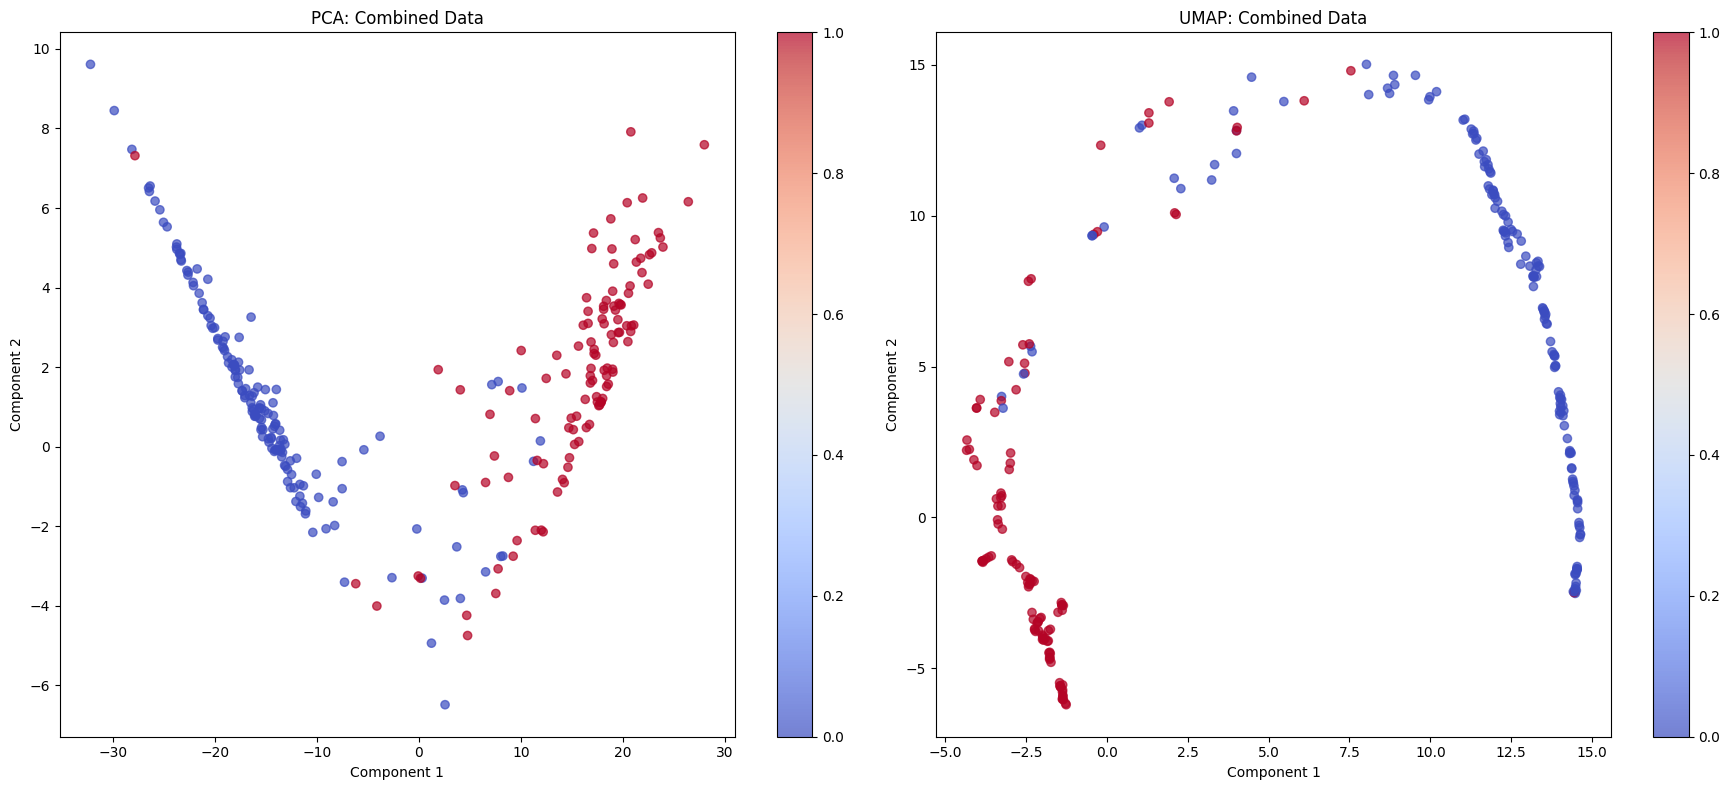

In [147]:
import matplotlib.pyplot as plt

import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import best_model_latent_plot_combined

fig, axes= best_model_latent_plot_combined(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, task)

plt.show()

/home/leilapirhaji/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



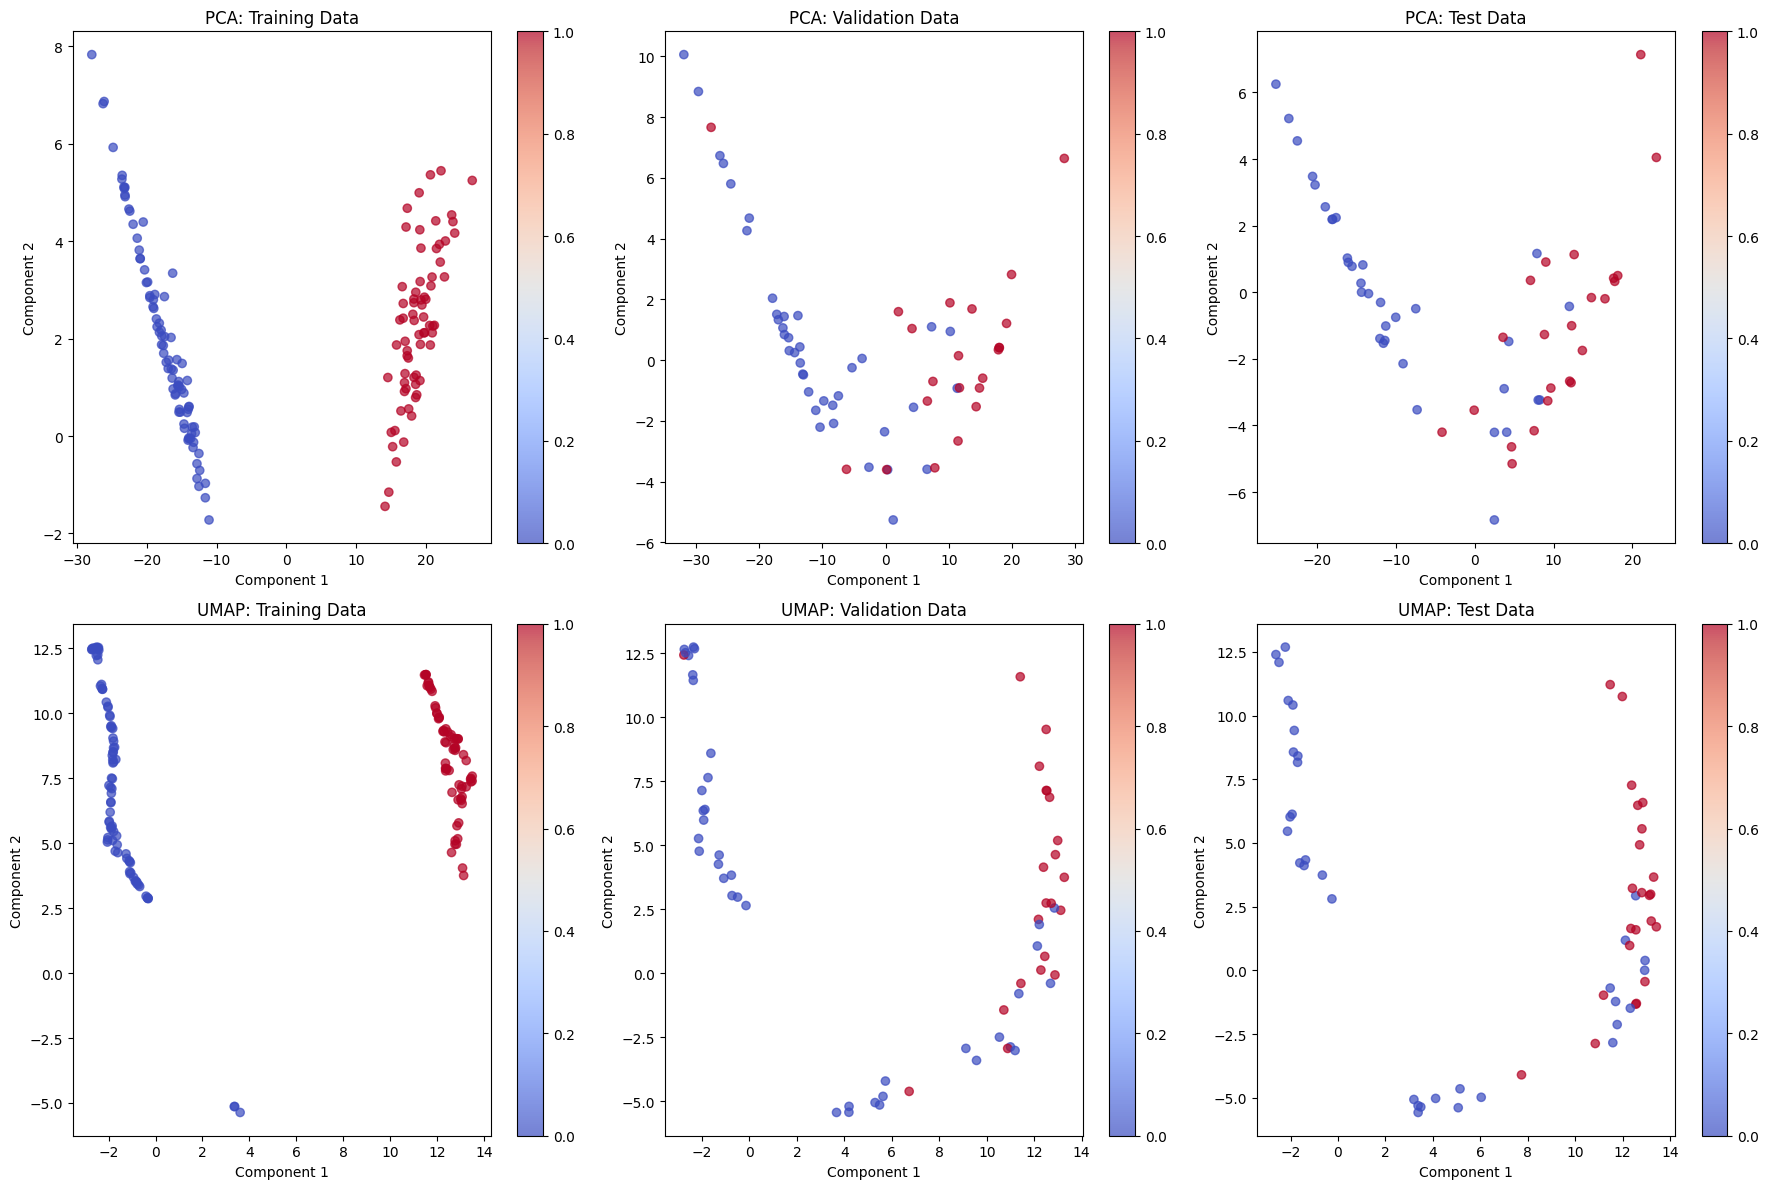

In [148]:
import matplotlib.pyplot as plt

import best_finetune_model_test_eval
importlib.reload(best_finetune_model_test_eval)
from best_finetune_model_test_eval import best_model_latent_plot


fig, axes=best_model_latent_plot(latent_rep_train, latent_rep_val, latent_rep_test, y_data_train, y_data_val, y_data_test, task)

plt.show()